In [1]:
# critical
import argparse
import os
import random
import time
import math

# machine learning
from sklearn.decomposition import PCA

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

/Users/tarineccleston/Documents/software-ds/gw-generative-models/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# set random seed for reproducibility
manualSeed = 99
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  99


In [80]:
# device = torch.device("mps")
device = torch.device("cpu")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 90

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of classes in the conditional dcgan
num_classes = 3

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = int(32 * (6000/1684))
# num_epochs = 32

# Learning rate for optimizers
lr_g = 0.00002
lr_d = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

### Dataloader

In [10]:
class GWDataset(Dataset):
    def __init__(self, signals_csv, parameters_csv):
        y = pd.read_csv(parameters_csv)
        self.data = pd.read_csv(signals_csv).astype('float32')
        # remove unusual parameters
        keep_signals_idx = np.array(y[y['beta1_IC_b'] > 0].index)
        y = y.iloc[keep_signals_idx,:]
        y = y['beta1_IC_b']

        # process beta_ic_b parameter by boundaries specified in literature
        # ranges = [0, 0.06, 0.17, 1]
        # labels = [0, 1, 2]
        # num_classes = len(labels)
        # y = pd.cut(y, bins=ranges, labels=labels).astype('int')
        # y = y.values

        print(y.shape)

        # process beta_ic_b parameter by equal freq bins
        num_classes = 2
        dummy, bin_boundaries = pd.qcut(y, q= num_classes, retbins=True, duplicates='drop')
        y = y.values
        y = np.digitize(y,bins=bin_boundaries[1:num_classes])

        y = np.eye(num_classes)[y]
        y = np.reshape(y, (y.shape[0], y.shape[1], 1)).astype('float32')

        self.parameters = y
        self.original_parameters = self.parameters
        self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1])).astype('float32')

        # drop corresponding signals which have erroneous parameter values
        self.data = self.data.iloc[:,keep_signals_idx]
        self.data = self.data.values
        self.original_data = self.data
        self.augmented_data = np.empty(shape = (256, 0)).astype('float32')

        ### signal manipulation section ###
        total_noise_mean = 0
        total_noise_std = 0
        
        temp_data = np.empty(shape = (256, 0)).astype('float32')

        for i in range(0, self.data.shape[1]):
            signal = self.data[:, i]
            signal = signal.reshape(1, -1)

            background_noise_segment = signal[:, 0:int(len(signal[0]) - 256)]
            cut_signal = signal[:, int(len(signal[0]) - 256):len(signal[0])]
            # middle_timestamps = len(signal[0]) // 2
            # signal = signal[:, middle_timestamps - 128: middle_timestamps + 128]

            temp_data = np.insert(temp_data, temp_data.shape[1], cut_signal, axis=1)            

            background_noise_mean = background_noise_segment.mean()
            background_noise_std = background_noise_segment.std()

            total_noise_mean = total_noise_mean + background_noise_mean
            total_noise_std = total_noise_std + background_noise_std

        self.background_noise_mean = total_noise_mean / self.data.shape[1]
        self.background_noise_std = total_noise_std / self.data.shape[1]

        self.data = temp_data
        ### end signal manipulation section ###

    ### augmentation methods ###
    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203
        noise = np.random.normal(0, 1, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal
    
    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 50, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(1, 0.5, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal
        return scaled_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # take window size of 10% of the signal with a warping factor of 2 or 0.5 (from literature)
        warping_factor =  np.random.choice([0.5, 2])
        # warping_factor = 0.5

        window_size = math.floor(signal.shape[1] / 10)
        scaled_window_size = warping_factor * window_size

        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 53

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal

        return warped_signal

    ### critical functions ###
    def calc_stats(self):
        self.mean = self.data.mean()
        print('Signal Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Signal Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Signal Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal

    def augmentation(self, desired_augmented_data_count):
        while self.data.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, 1684)
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            ### mixture augmentation only ###
            # find the class of signal_1 (assuming class is a column in self.parameters)
            beta_class_of_signal_1 = np.argmax(self.parameters[idx_1, :])
            # sample only from the same class for signal_2 and make sure it's not the same as signal_1
            candidate_indices = [x for x in range(0, 1684) if x != idx_1 and np.argmax(self.parameters[x, :]) == beta_class_of_signal_1]
            idx_2 = np.random.choice(candidate_indices)
            signal_2 = self.data[:, idx_2]
            signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            # augmented_signal = self.window_warping_augmentation(signal_1)
            augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            self.augmented_data = np.insert(self.augmented_data, self.augmented_data.shape[1], augmented_signal, axis=1)
            self.data = np.insert(self.data, self.data.shape[1], augmented_signal, axis=1)

            # just copy parameters for now
            augmented_parameter = self.parameters[idx_1, :]

            self.augmented_parameters = np.insert(self.augmented_parameters, self.augmented_parameters.shape[0], augmented_parameter, axis=0)
            self.parameters = np.insert(self.parameters, self.parameters.shape[0], augmented_parameter, axis=0)

        print("Signal Dataset Size after Data Augmentation: ", self.data.shape)
        print("Parameter Dataset Size after Data Augmentation: ", self.parameters.shape)

    ### overloads ###
    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]

        signal_standardized = self.standardize(signal)

        return signal_standardized, parameter

In [27]:
def plot_waveforms_standardised(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y, color='blue')

        ax.axvline(x=53, color='black', linestyle='--', alpha=0.5)
        ax.grid(True)
        ax.set_ylim((-4, 2))
        
        # Add axis titles
        ax.set_ylabel('distance * strain (cm^2)')
        ax.set_xlabel('n (timestamps)')

        parameters = real_parameter_batch[i, :].numpy()[0]

        # Add class label at the bottom of each subplot
        ax.text(0.5, -0.25, f'Rapid Rotation: {parameters}', transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='center')

    for i in range(407, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        ax.plot(x, y, color='blue')

        ax.axvline(x=53, color='black', linestyle='--', alpha=0.5)
        ax.grid(True)
        ax.set_ylim(ylim_signal)
        
        # Add axis titles
        ax.set_ylabel('distance * strain (cm^2)')
        ax.set_xlabel('n (timestamps)')

        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(407, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    # plt.savefig('../plots/signal-manipulation/gw_signals_cut.png')
    plt.show()

(1684,)
Signal Dataset mean:  -0.51635957
Signal Dataset std:  39.724163
Signal Dataset scaling factor (to match noise in generator):  5
Signal Batch Size:  torch.Size([32, 1, 256])
Parameter Batch Size:  torch.Size([32, 2, 1])


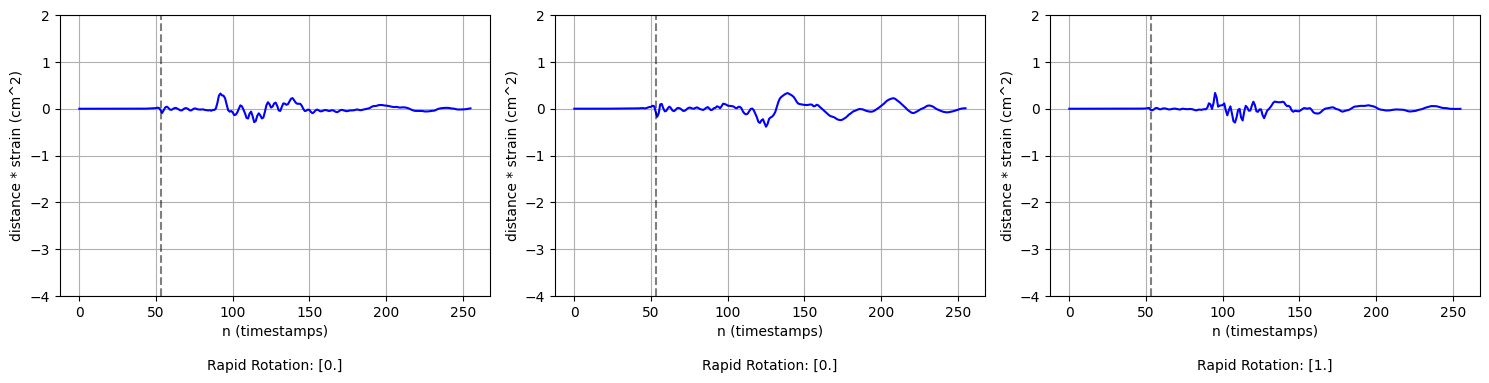

In [43]:
dataset = GWDataset("../data/input/richers_1764.csv", "../data/input/richers_1764_parameters.csv")

ylim_signal = dataset.get_common()
# dataset.augmentation(6000)
dataset.calc_stats()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_signals_batch, real_parameter_batch  = next(iter(dataloader))

print("Signal Batch Size: ", real_signals_batch.shape)
print("Parameter Batch Size: ", real_parameter_batch.shape)

ylim_signal_standardised = dataset.get_common()
parameter_names = ['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']

plot_waveforms_standardised(real_signals_batch, real_parameter_batch)
# plot_waveforms_standardised(real_signals_batch, real_parameter_batch)

In [29]:
dataset.__len__()

1684

### Weight Initialisation (Random Noise)

In [32]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [50]:
class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose1d(100, ngf * 32, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

            self.z_reshape = nn.Sequential(
                nn.Linear(nz, 64),
                nn.LeakyReLU(True)
            )
        
            self.y_reshape = nn.Sequential(
                nn.Linear(1, 10)
            )

        def forward(self, z, y):
            print(z.shape)
            print(y.shape)
            z = torch.reshape(z, (z.shape[0], z.shape[2], z.shape[1]))
            print(z.shape)
            # z = self.z_reshape(z)
            print(z.shape)
            # y = torch.reshape(y, (y.shape[0], y.shape[2], y.shape[1]))
            y = self.y_reshape(y)
            print(y.shape)
            z = torch.cat([z, y], 2)
            print(z.shape)
            z = torch.reshape(z, (z.shape[0], z.shape[2], z.shape[1]))
            print(z.shape)
            x = self.main(z)
            print(x.shape)
            return x

In [78]:
netG = Generator().to(device)

netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=[(nz, nc), (1, 1)])

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(100, 2048, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias

### Discriminator

In [65]:
class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(2, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                ### Can increase model complexity here ###
                # nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 32, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(1),
                nn.Sigmoid()
            )

            self.y_reshape = nn.Sequential(
                nn.Linear(1, 256)
            )

        def forward(self, x, y):
            print(x.shape)
            print(y.shape)
            y = self.y_reshape(y)
            print(y.shape)
            x = torch.cat([x, y], 1)
            print(x.shape)
            x = self.main(x)
            print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            print(x.shape)
            x = self.fc(x)
            print(x.shape)
            return x

In [66]:
netD = Discriminator().to(device)

netD.apply(weights_init)

print(netD)

model = Discriminator()
summary(model, input_size=[(nc, 256), (1, 1)])

Discriminator(
  (main): Sequential(
    (0): Conv1d(2, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout1d(p=0.2,

/Users/tarineccleston/Documents/software-ds/gw-generative-models/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Loss functions and Optimisers

In [75]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# learning-rate decay scheduler
schedulerD = lr_scheduler.LinearLR(optimizerD, start_factor=1.0, end_factor=0.5, total_iters=32)
schedulerG = lr_scheduler.LinearLR(optimizerG, start_factor=1.0, end_factor=0.5, total_iters=32)

# establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

In [81]:
# create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

fixed_random_indices = torch.randint(0, 1, (batch_size,)).long()
fixed_random_one_hot_encoding = torch.nn.functional.one_hot(fixed_random_indices, num_classes=1).float()
fixed_random_one_hot_encoding = fixed_random_one_hot_encoding.unsqueeze(-1)

# plot generated signals before training
with torch.no_grad():
    fake_signals = netG(fixed_noise,fixed_random_one_hot_encoding).detach().cpu()
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))

    axes = axes.flatten()

    # plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(407)
        y = fake_signals[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        background_noise_generated = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int(407-256))
        y = np.concatenate((background_noise_generated, y))
        ax.plot(x, y, color = 'red')

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.1)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(ylim_signal)

    for i in range(512, 8*4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    # plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_0.png')
    plt.show()

torch.Size([32, 90, 1])
torch.Size([32, 1, 1])
torch.Size([32, 1, 90])
torch.Size([32, 1, 90])


RuntimeError: Placeholder storage has not been allocated on MPS device!

### Training

Starting Training Loop...
[0/32][0/188]	Loss_D: 1.7392	Loss_G: 0.8053	D(x): 0.3593	D(G(z)): 0.4540 / 0.4625
[0/32][50/188]	Loss_D: 0.8013	Loss_G: 1.0728	D(x): 0.8251	D(G(z)): 0.3758 / 0.3563
[0/32][100/188]	Loss_D: 0.6320	Loss_G: 1.6577	D(x): 0.8713	D(G(z)): 0.2349 / 0.2174
[0/32][150/188]	Loss_D: 0.5845	Loss_G: 1.6595	D(x): 0.8884	D(G(z)): 0.2270 / 0.2218
Epoch 0: SGD Discriminator lr 0.0000200 -> 0.0000197
Epoch 0: SGD Generator lr 0.0000200 -> 0.0000197


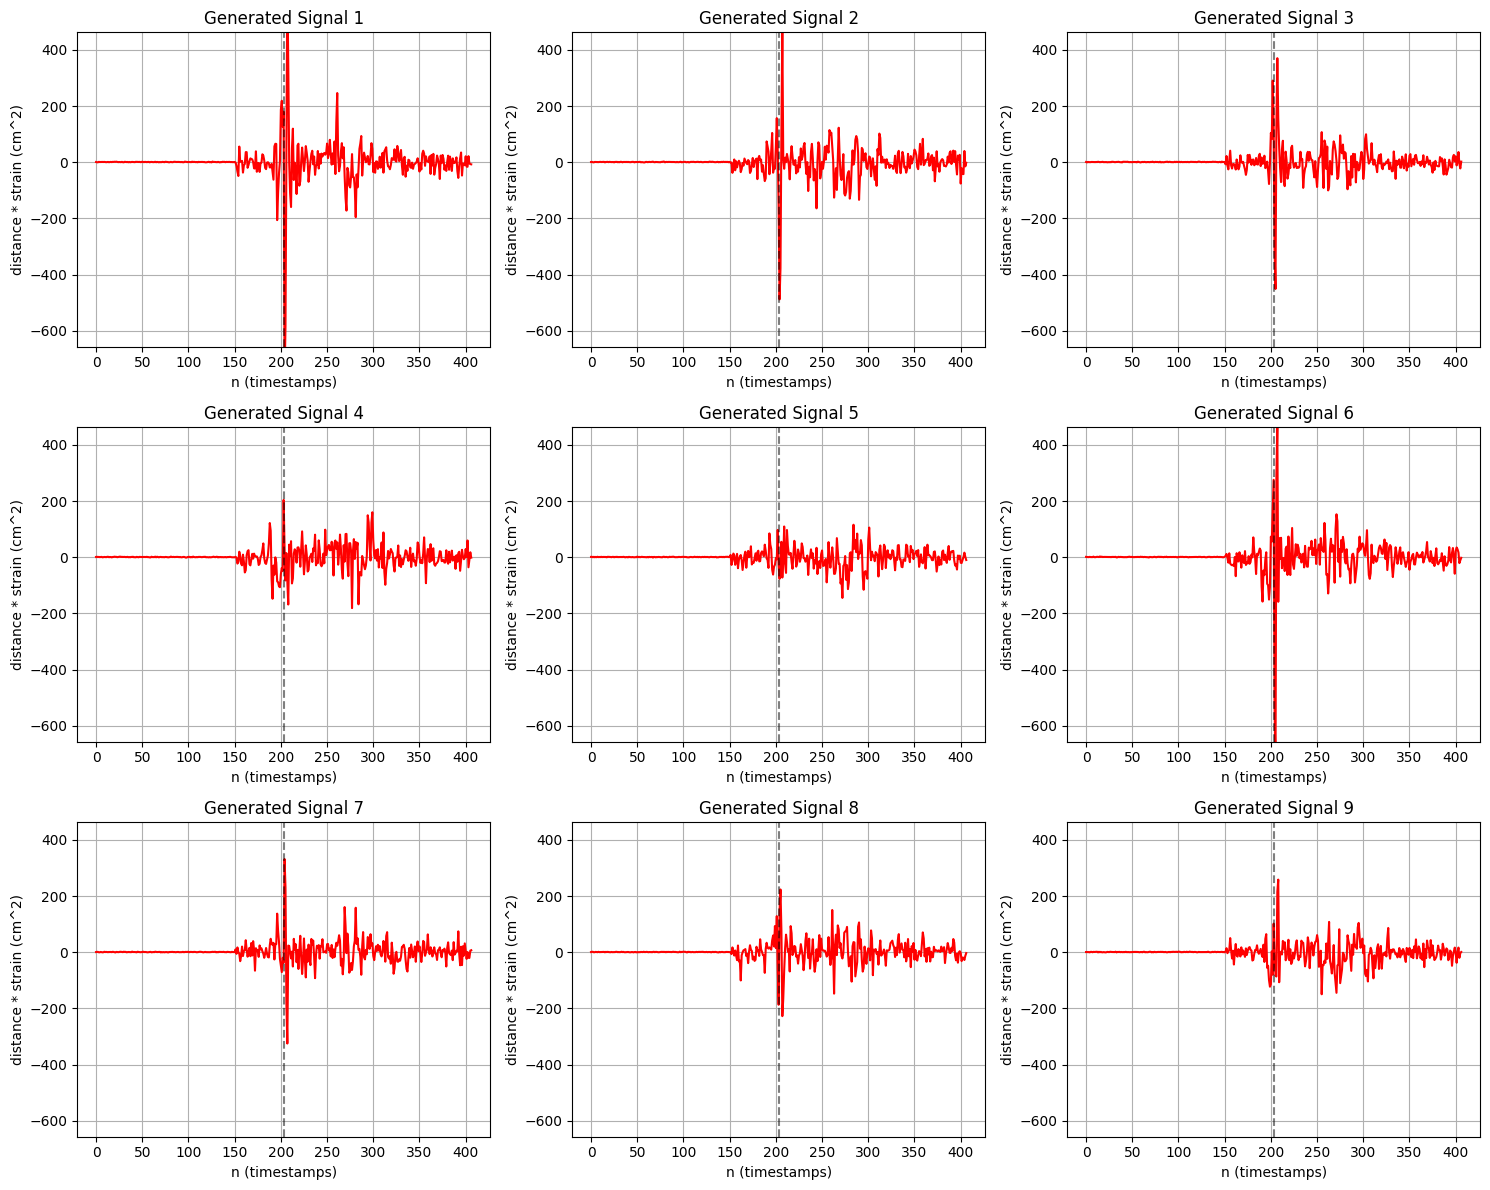

[1/32][0/188]	Loss_D: 0.5157	Loss_G: 1.8613	D(x): 0.9091	D(G(z)): 0.1888 / 0.1940
[1/32][50/188]	Loss_D: 0.6526	Loss_G: 1.5060	D(x): 0.8834	D(G(z)): 0.3182 / 0.2597
[1/32][100/188]	Loss_D: 0.5979	Loss_G: 1.3774	D(x): 0.9206	D(G(z)): 0.3103 / 0.3047
[1/32][150/188]	Loss_D: 0.5215	Loss_G: 1.5925	D(x): 0.9251	D(G(z)): 0.2089 / 0.2366
Epoch 1: SGD Discriminator lr 0.0000197 -> 0.0000194
Epoch 1: SGD Generator lr 0.0000197 -> 0.0000194


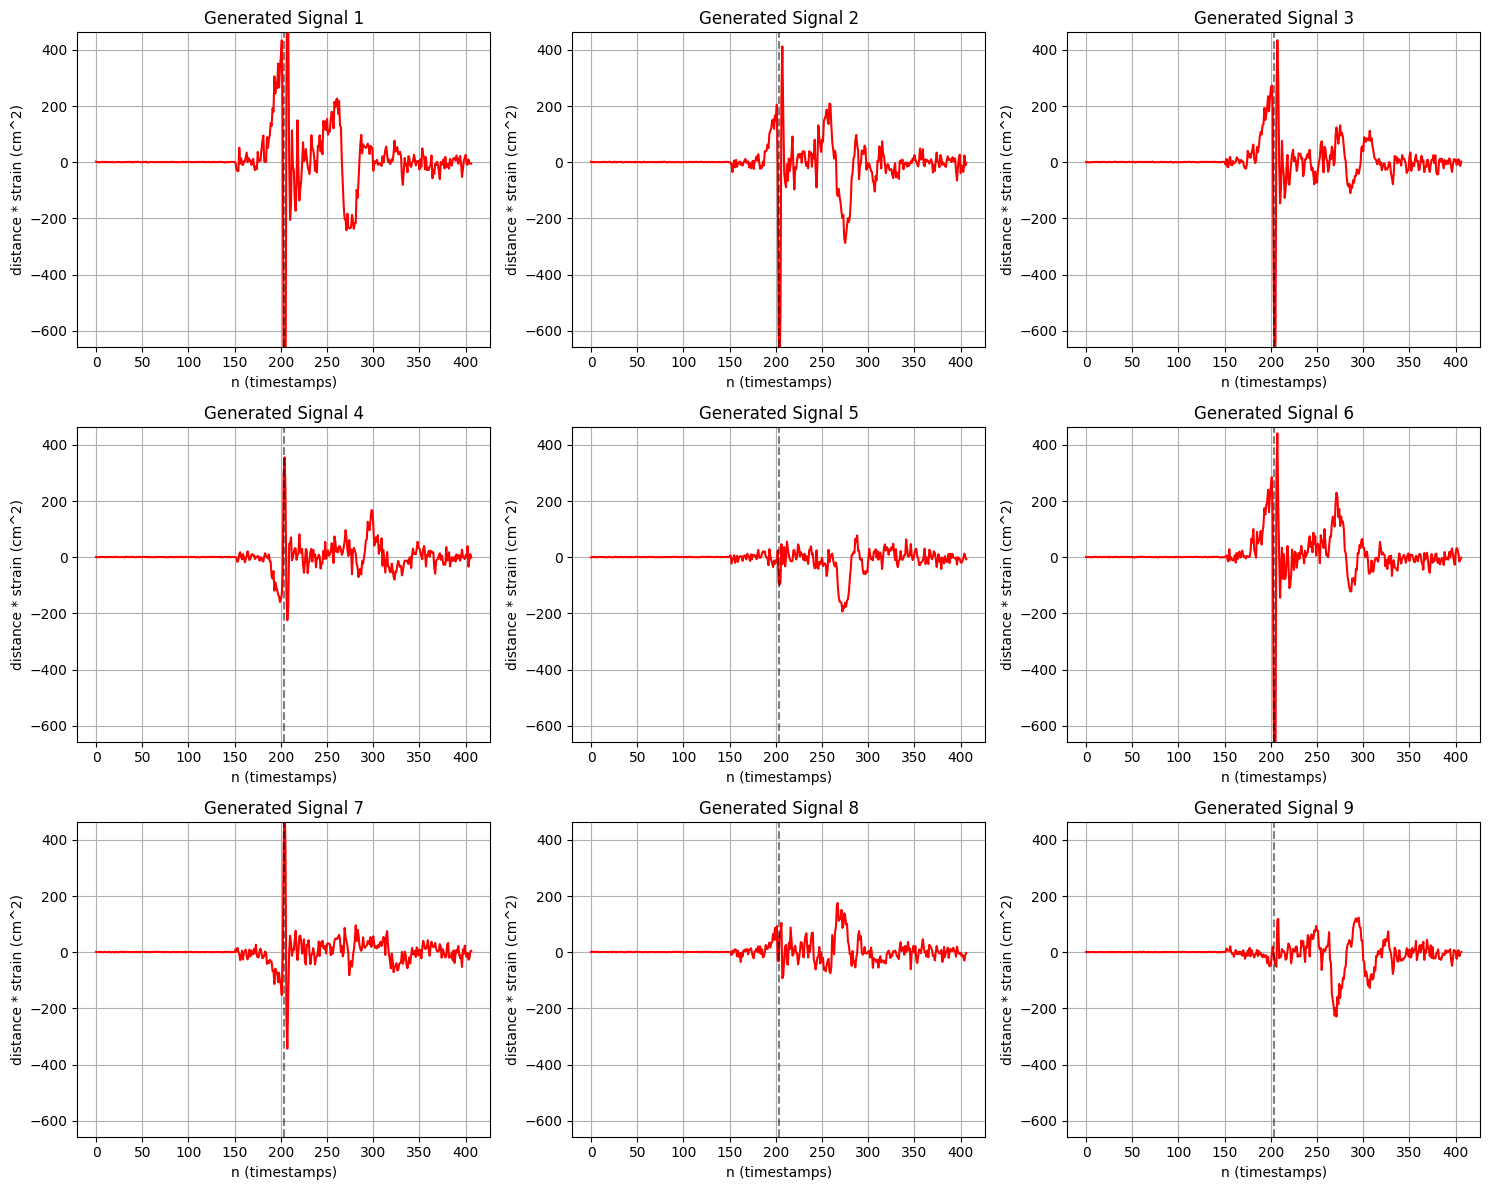

[2/32][0/188]	Loss_D: 0.5627	Loss_G: 1.4214	D(x): 0.9422	D(G(z)): 0.2622 / 0.2834
[2/32][50/188]	Loss_D: 0.5553	Loss_G: 1.8424	D(x): 0.9118	D(G(z)): 0.2067 / 0.1993
[2/32][100/188]	Loss_D: 0.5153	Loss_G: 2.5450	D(x): 0.9493	D(G(z)): 0.0912 / 0.0898
[2/32][150/188]	Loss_D: 0.4726	Loss_G: 1.8691	D(x): 0.9498	D(G(z)): 0.1851 / 0.1868
Epoch 2: SGD Discriminator lr 0.0000194 -> 0.0000191
Epoch 2: SGD Generator lr 0.0000194 -> 0.0000191


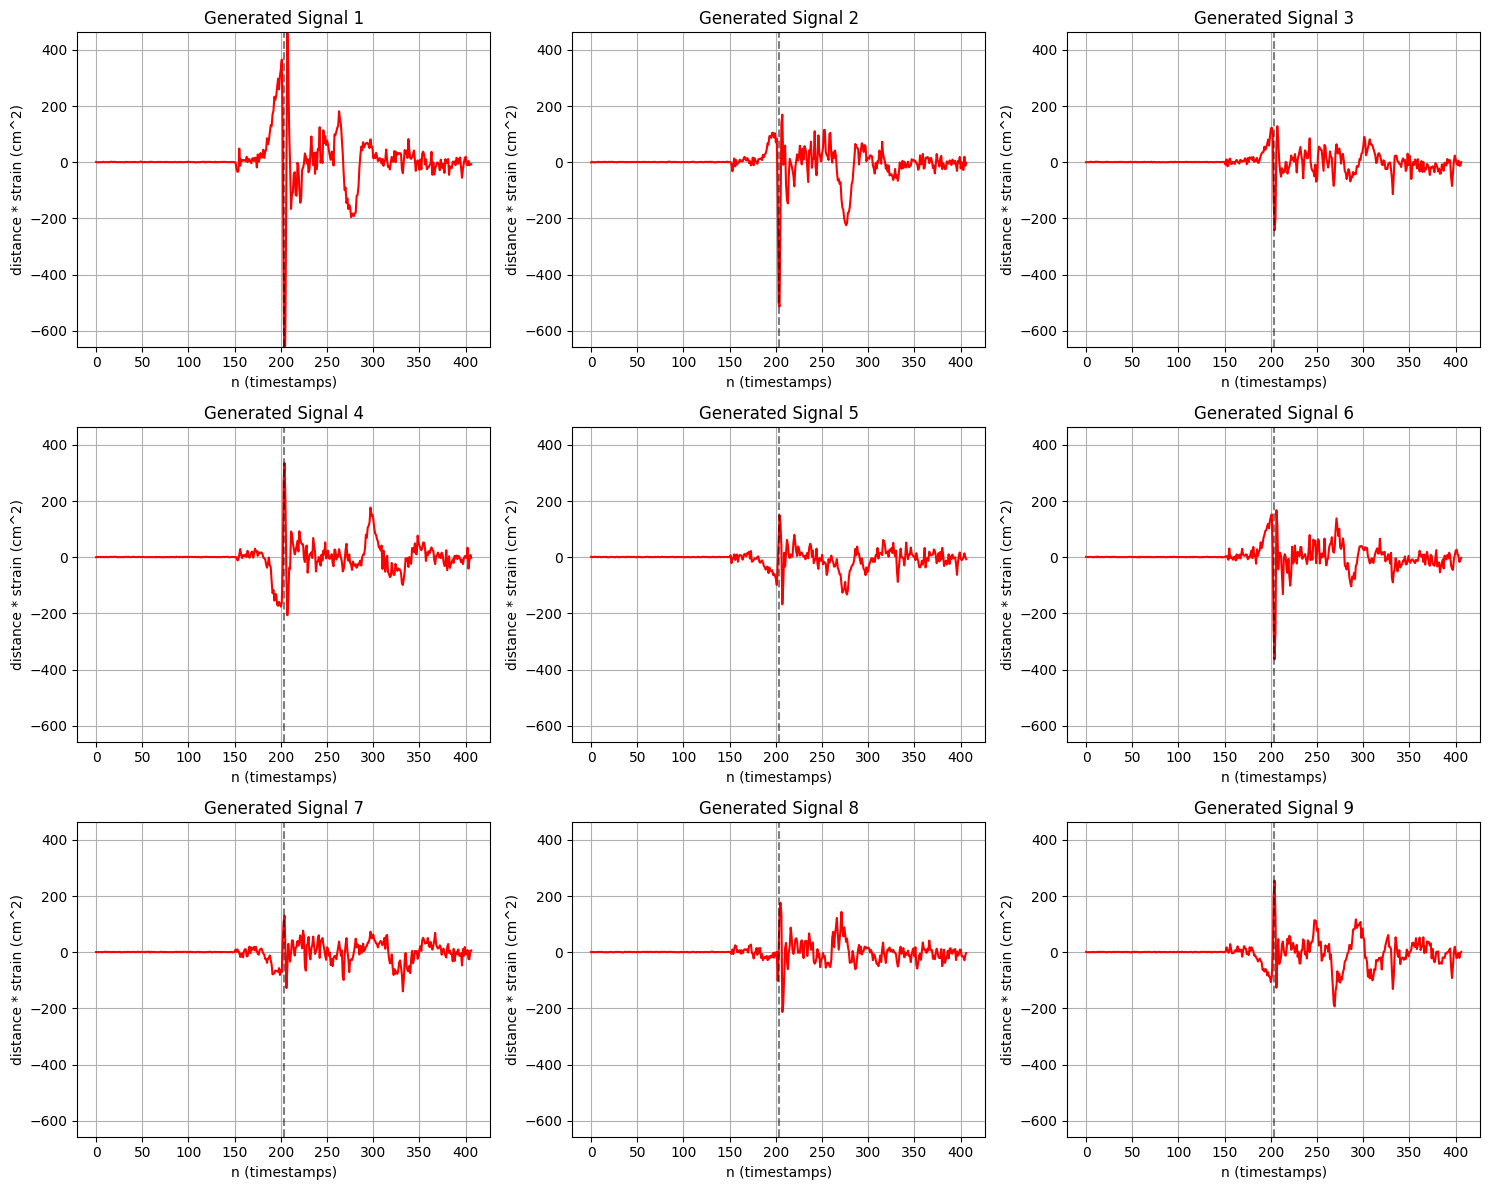

[3/32][0/188]	Loss_D: 0.4871	Loss_G: 2.5803	D(x): 0.9252	D(G(z)): 0.0990 / 0.0897
[3/32][50/188]	Loss_D: 0.5927	Loss_G: 1.5497	D(x): 0.9267	D(G(z)): 0.3029 / 0.2895
[3/32][100/188]	Loss_D: 0.5810	Loss_G: 1.8746	D(x): 0.9425	D(G(z)): 0.2070 / 0.2167
[3/32][150/188]	Loss_D: 0.4901	Loss_G: 2.1242	D(x): 0.9321	D(G(z)): 0.1147 / 0.1558
Epoch 3: SGD Discriminator lr 0.0000191 -> 0.0000188
Epoch 3: SGD Generator lr 0.0000191 -> 0.0000188


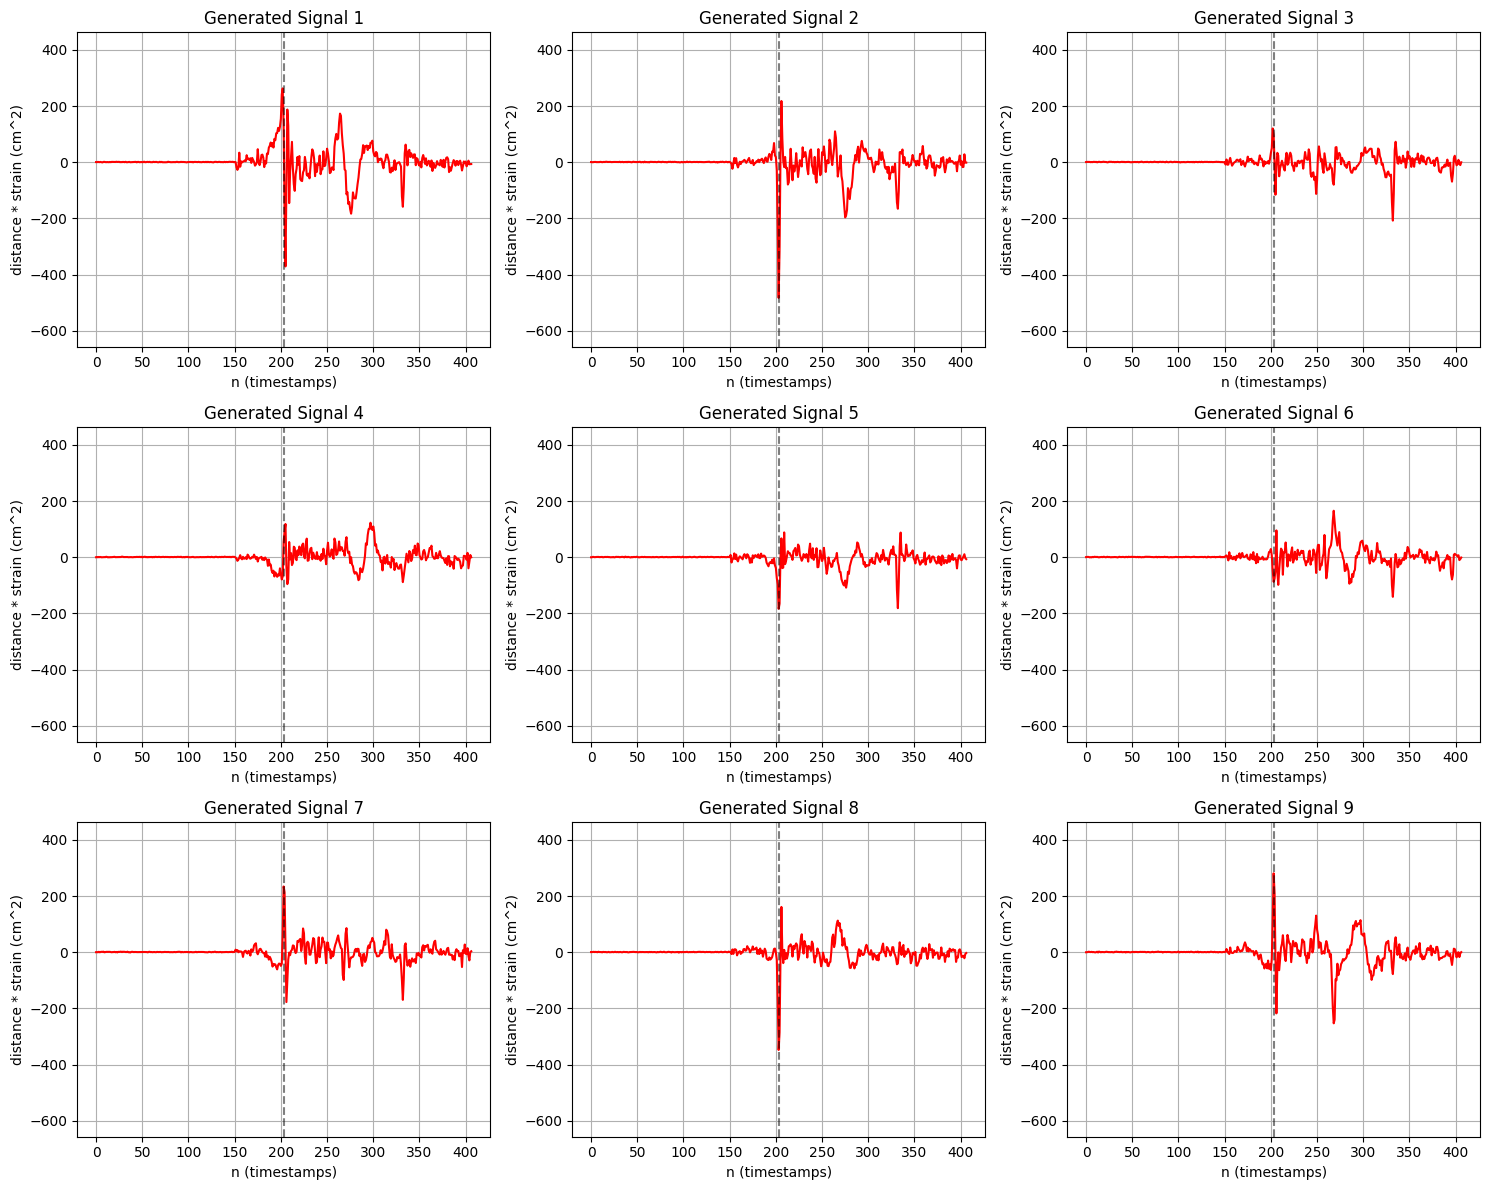

[4/32][0/188]	Loss_D: 0.5572	Loss_G: 1.5630	D(x): 0.9448	D(G(z)): 0.2500 / 0.2576
[4/32][50/188]	Loss_D: 0.5418	Loss_G: 2.3952	D(x): 0.9272	D(G(z)): 0.1359 / 0.1136
[4/32][100/188]	Loss_D: 0.4614	Loss_G: 3.0886	D(x): 0.9504	D(G(z)): 0.0505 / 0.0508
[4/32][150/188]	Loss_D: 0.4357	Loss_G: 2.2763	D(x): 0.9481	D(G(z)): 0.1194 / 0.1246
Epoch 4: SGD Discriminator lr 0.0000188 -> 0.0000184
Epoch 4: SGD Generator lr 0.0000188 -> 0.0000184


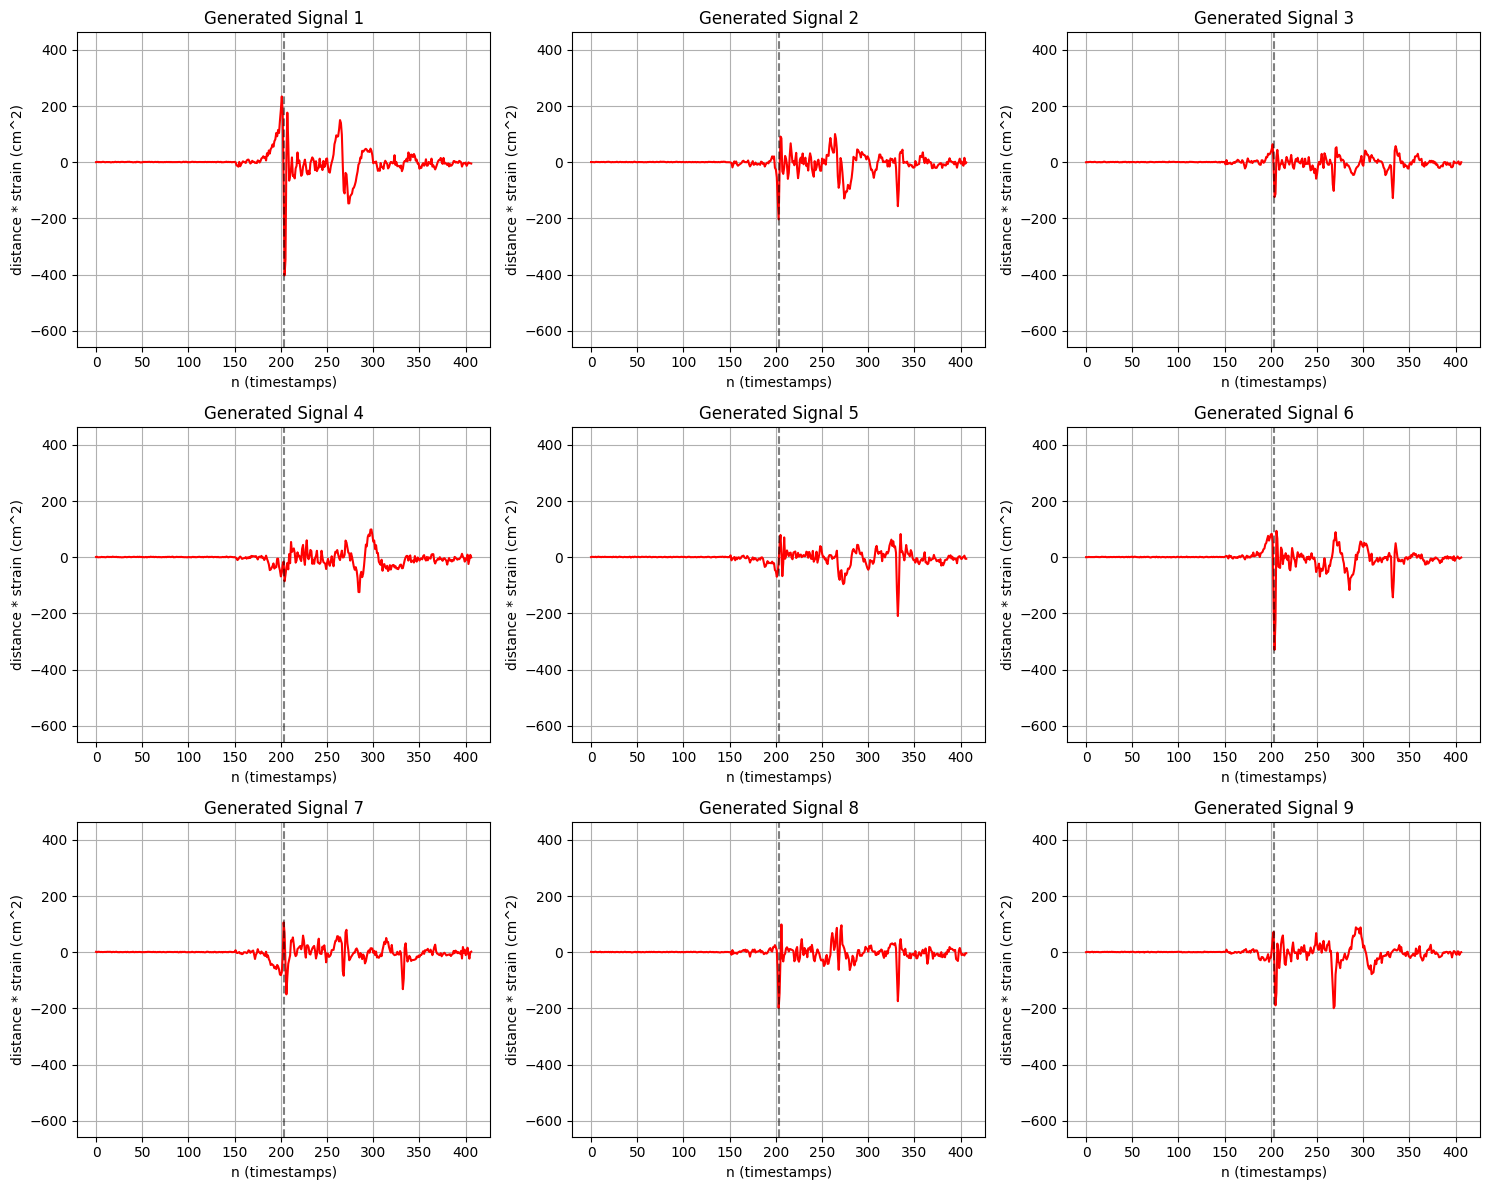

[5/32][0/188]	Loss_D: 0.7182	Loss_G: 1.3464	D(x): 0.9250	D(G(z)): 0.3824 / 0.3329
[5/32][50/188]	Loss_D: 0.6517	Loss_G: 1.6537	D(x): 0.9332	D(G(z)): 0.2949 / 0.2826
[5/32][100/188]	Loss_D: 0.6347	Loss_G: 1.8872	D(x): 0.9344	D(G(z)): 0.2332 / 0.2327
[5/32][150/188]	Loss_D: 0.6007	Loss_G: 1.8903	D(x): 0.8855	D(G(z)): 0.2032 / 0.2113
Epoch 5: SGD Discriminator lr 0.0000184 -> 0.0000181
Epoch 5: SGD Generator lr 0.0000184 -> 0.0000181


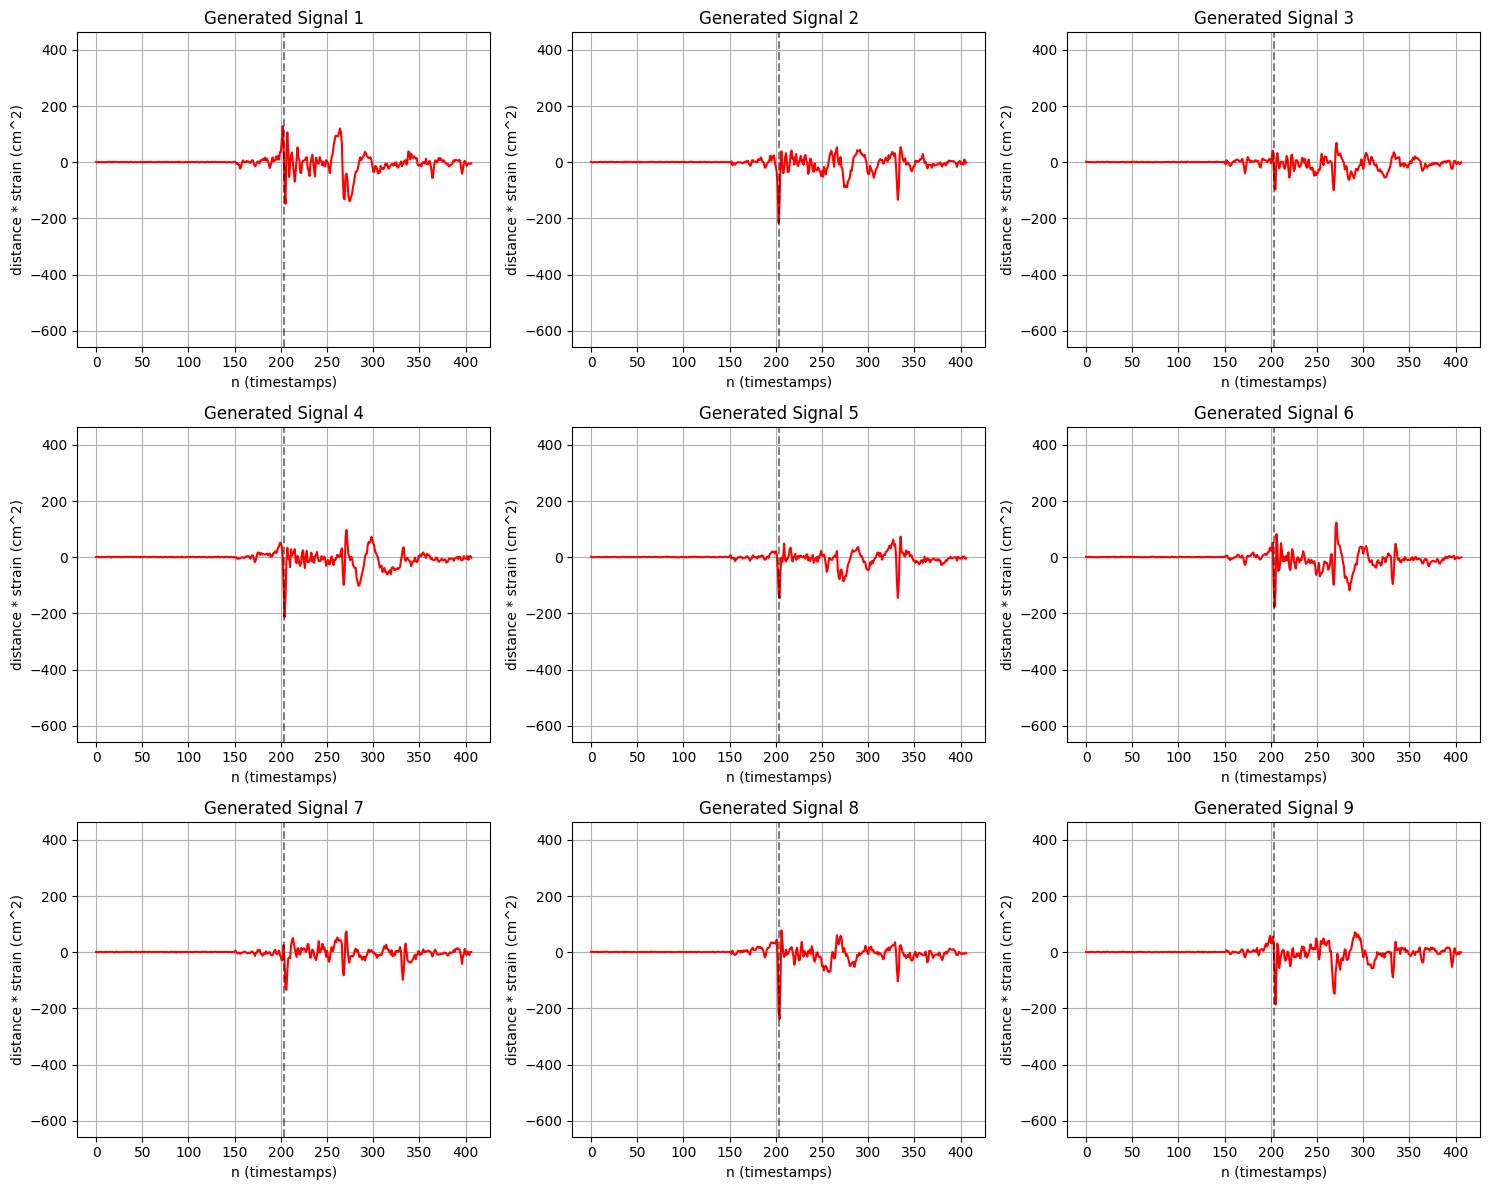

[6/32][0/188]	Loss_D: 0.5655	Loss_G: 1.9158	D(x): 0.8943	D(G(z)): 0.1413 / 0.1959
[6/32][50/188]	Loss_D: 0.6286	Loss_G: 2.0247	D(x): 0.9169	D(G(z)): 0.2472 / 0.2028
[6/32][100/188]	Loss_D: 0.6330	Loss_G: 2.0869	D(x): 0.9091	D(G(z)): 0.1974 / 0.2059
[6/32][150/188]	Loss_D: 0.5519	Loss_G: 2.1774	D(x): 0.9495	D(G(z)): 0.1937 / 0.1806
Epoch 6: SGD Discriminator lr 0.0000181 -> 0.0000178
Epoch 6: SGD Generator lr 0.0000181 -> 0.0000178


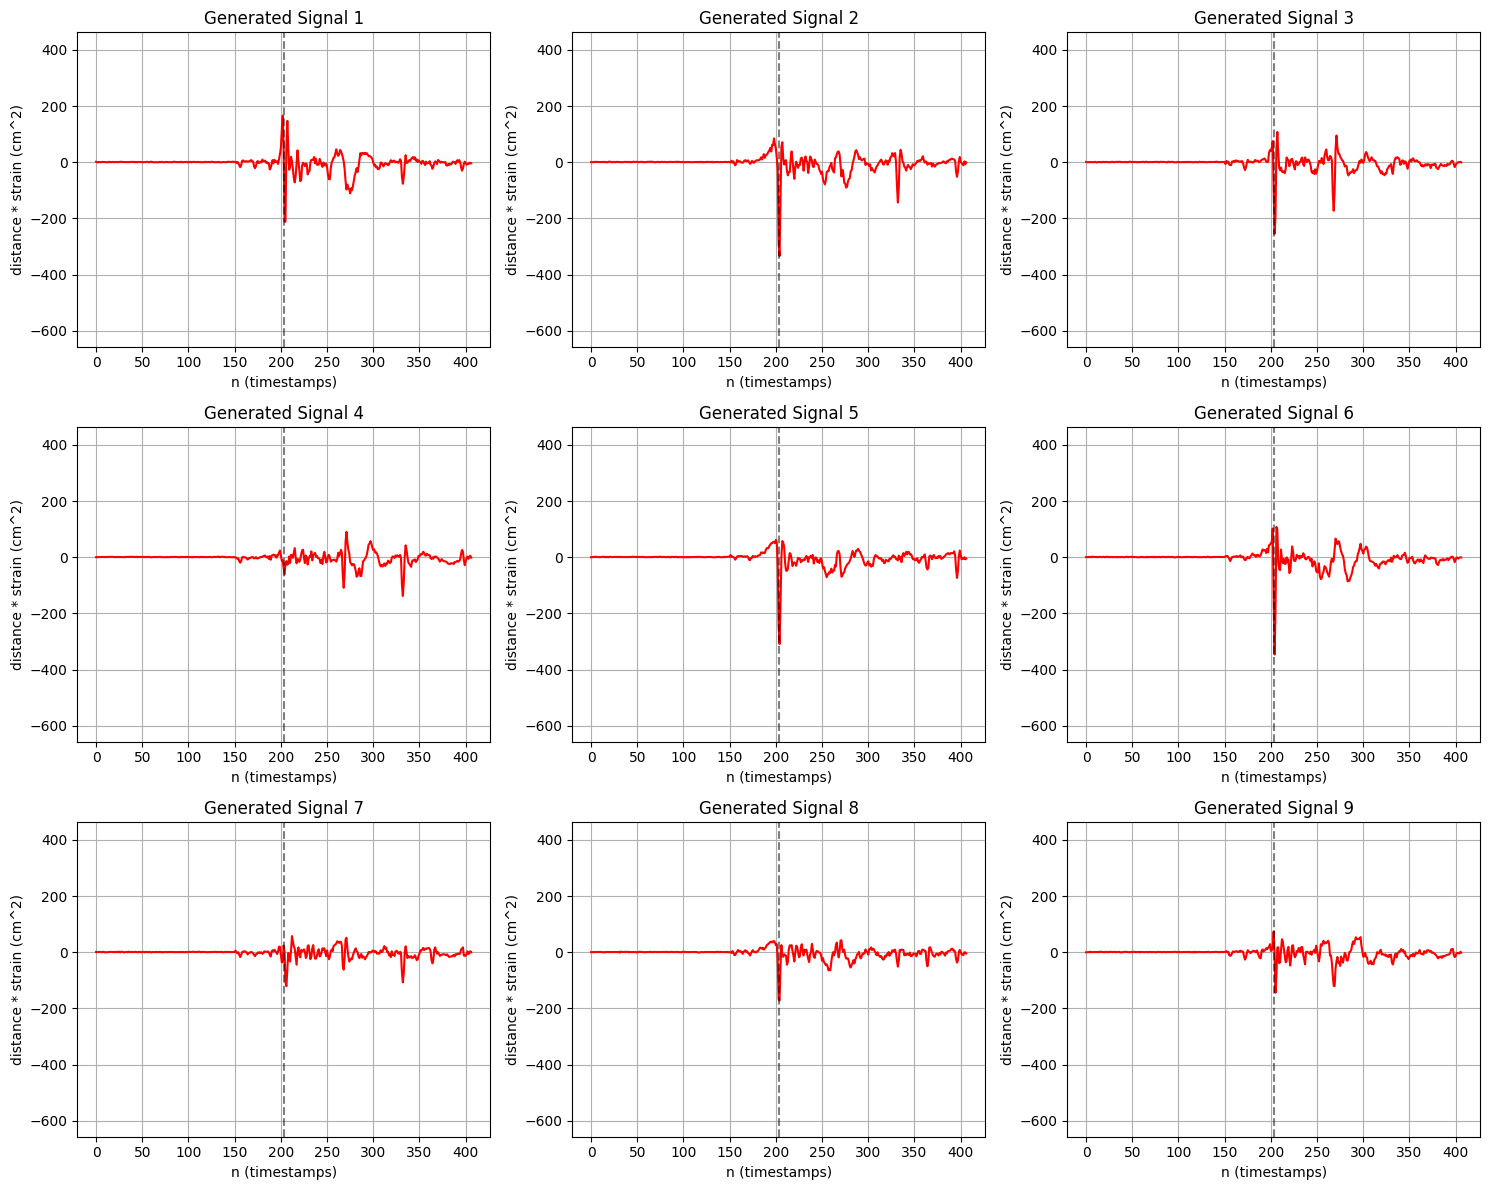

[7/32][0/188]	Loss_D: 0.5374	Loss_G: 1.9403	D(x): 0.9203	D(G(z)): 0.1633 / 0.1855
[7/32][50/188]	Loss_D: 0.5598	Loss_G: 1.7078	D(x): 0.9147	D(G(z)): 0.2158 / 0.2259
[7/32][100/188]	Loss_D: 0.5183	Loss_G: 2.0909	D(x): 0.9214	D(G(z)): 0.1604 / 0.1653
[7/32][150/188]	Loss_D: 0.5385	Loss_G: 1.9805	D(x): 0.9237	D(G(z)): 0.2039 / 0.1843
Epoch 7: SGD Discriminator lr 0.0000178 -> 0.0000175
Epoch 7: SGD Generator lr 0.0000178 -> 0.0000175


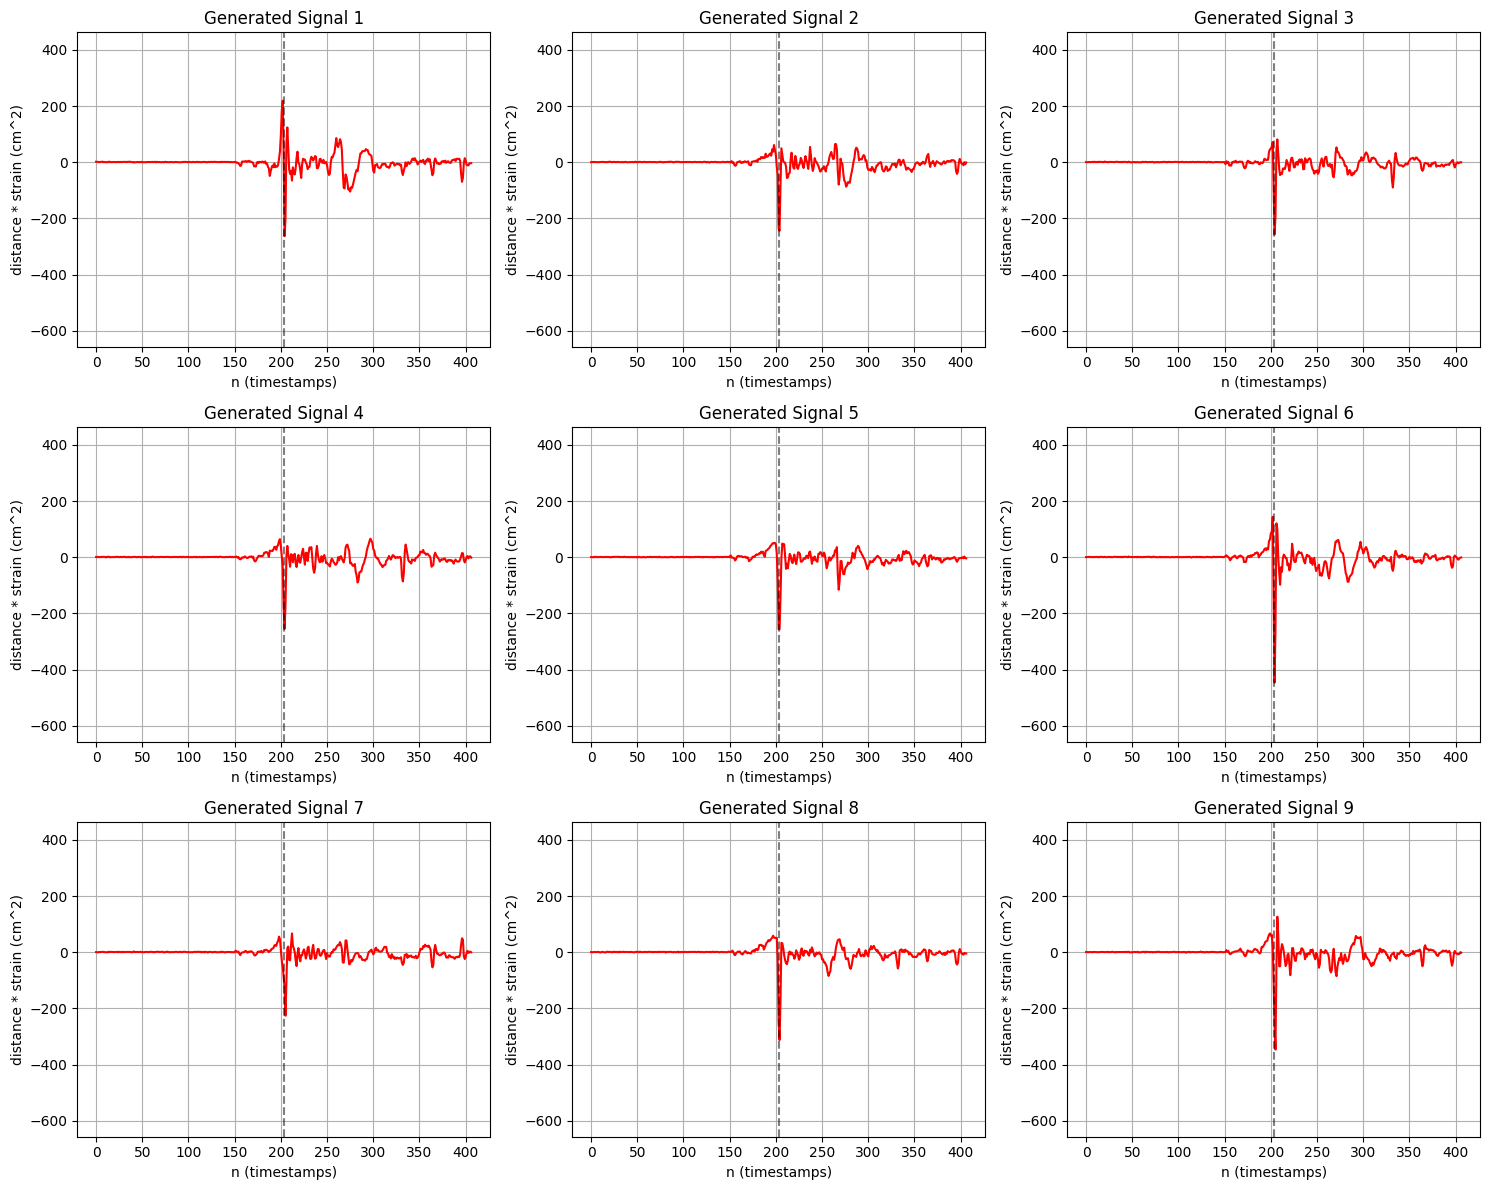

[8/32][0/188]	Loss_D: 0.5817	Loss_G: 2.2342	D(x): 0.8682	D(G(z)): 0.1446 / 0.1581
[8/32][50/188]	Loss_D: 0.5441	Loss_G: 2.0880	D(x): 0.9167	D(G(z)): 0.1924 / 0.1571
[8/32][100/188]	Loss_D: 0.5849	Loss_G: 1.6079	D(x): 0.9128	D(G(z)): 0.2359 / 0.2678
[8/32][150/188]	Loss_D: 0.5048	Loss_G: 2.3920	D(x): 0.9331	D(G(z)): 0.1340 / 0.1168
Epoch 8: SGD Discriminator lr 0.0000175 -> 0.0000172
Epoch 8: SGD Generator lr 0.0000175 -> 0.0000172


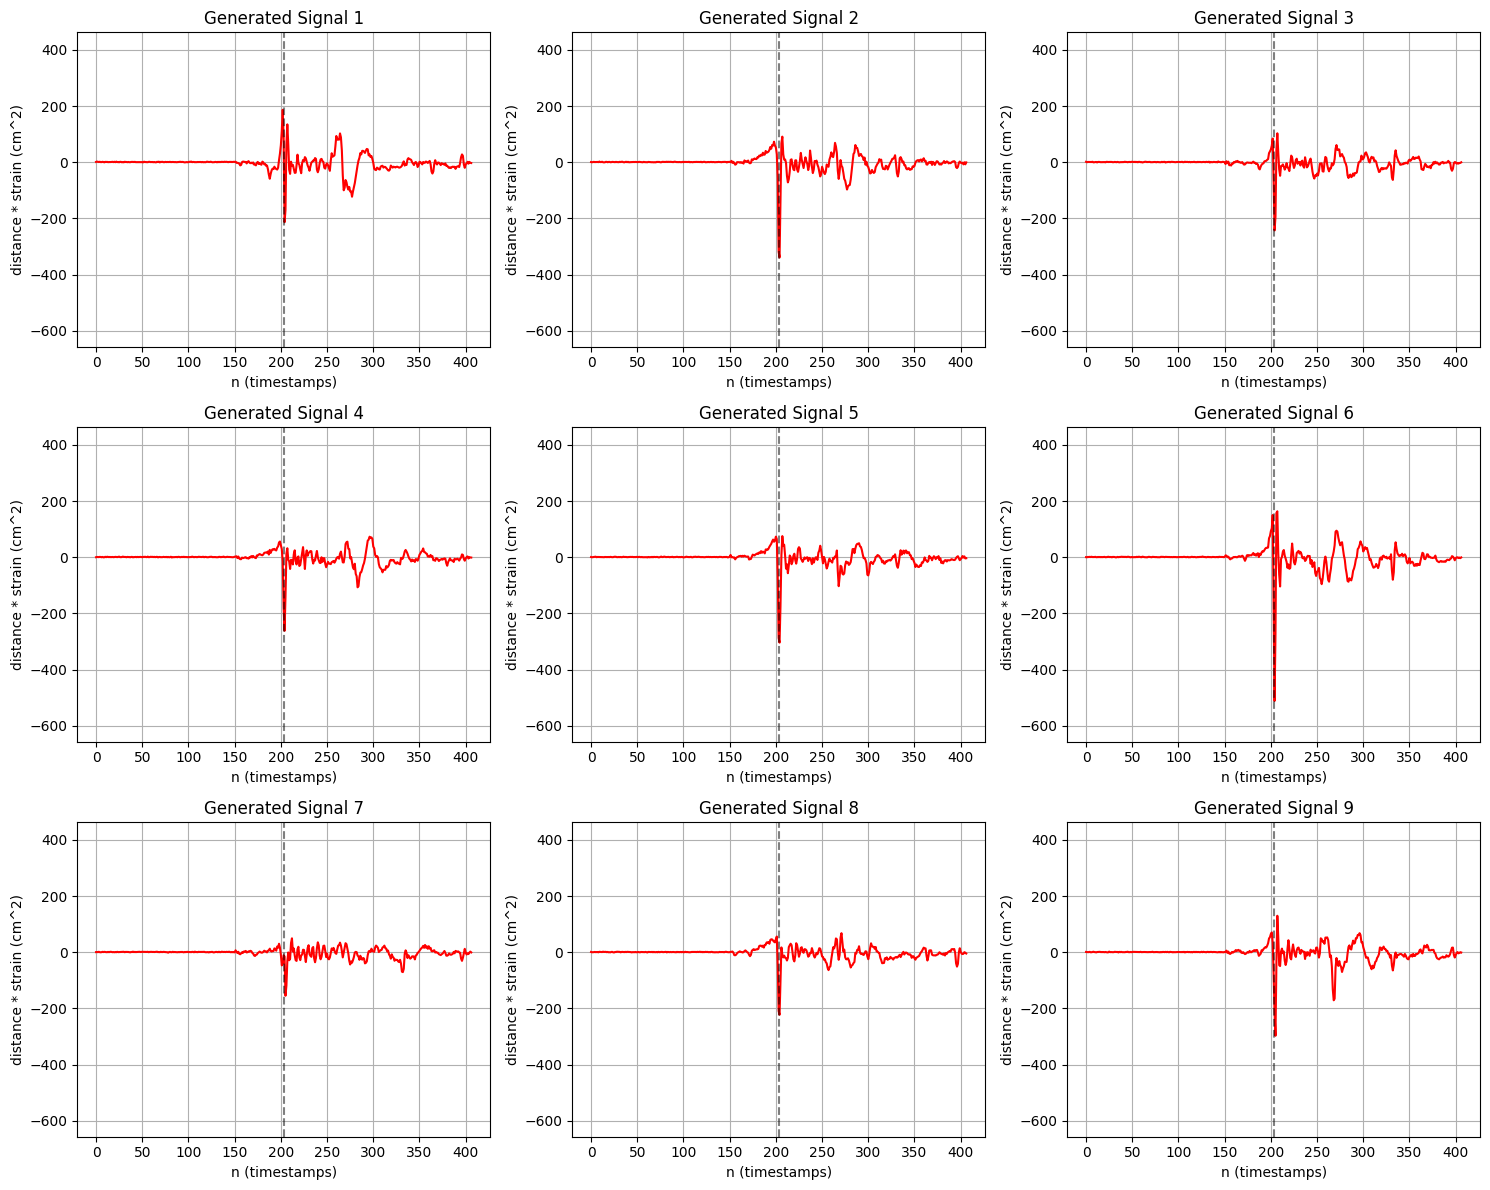

[9/32][0/188]	Loss_D: 0.4985	Loss_G: 1.7319	D(x): 0.9326	D(G(z)): 0.1776 / 0.2105
[9/32][50/188]	Loss_D: 0.5067	Loss_G: 1.9814	D(x): 0.9252	D(G(z)): 0.1417 / 0.2055
[9/32][100/188]	Loss_D: 0.5662	Loss_G: 1.8747	D(x): 0.9199	D(G(z)): 0.2105 / 0.1958
[9/32][150/188]	Loss_D: 0.5502	Loss_G: 1.7772	D(x): 0.9285	D(G(z)): 0.2556 / 0.1962
Epoch 9: SGD Discriminator lr 0.0000172 -> 0.0000169
Epoch 9: SGD Generator lr 0.0000172 -> 0.0000169


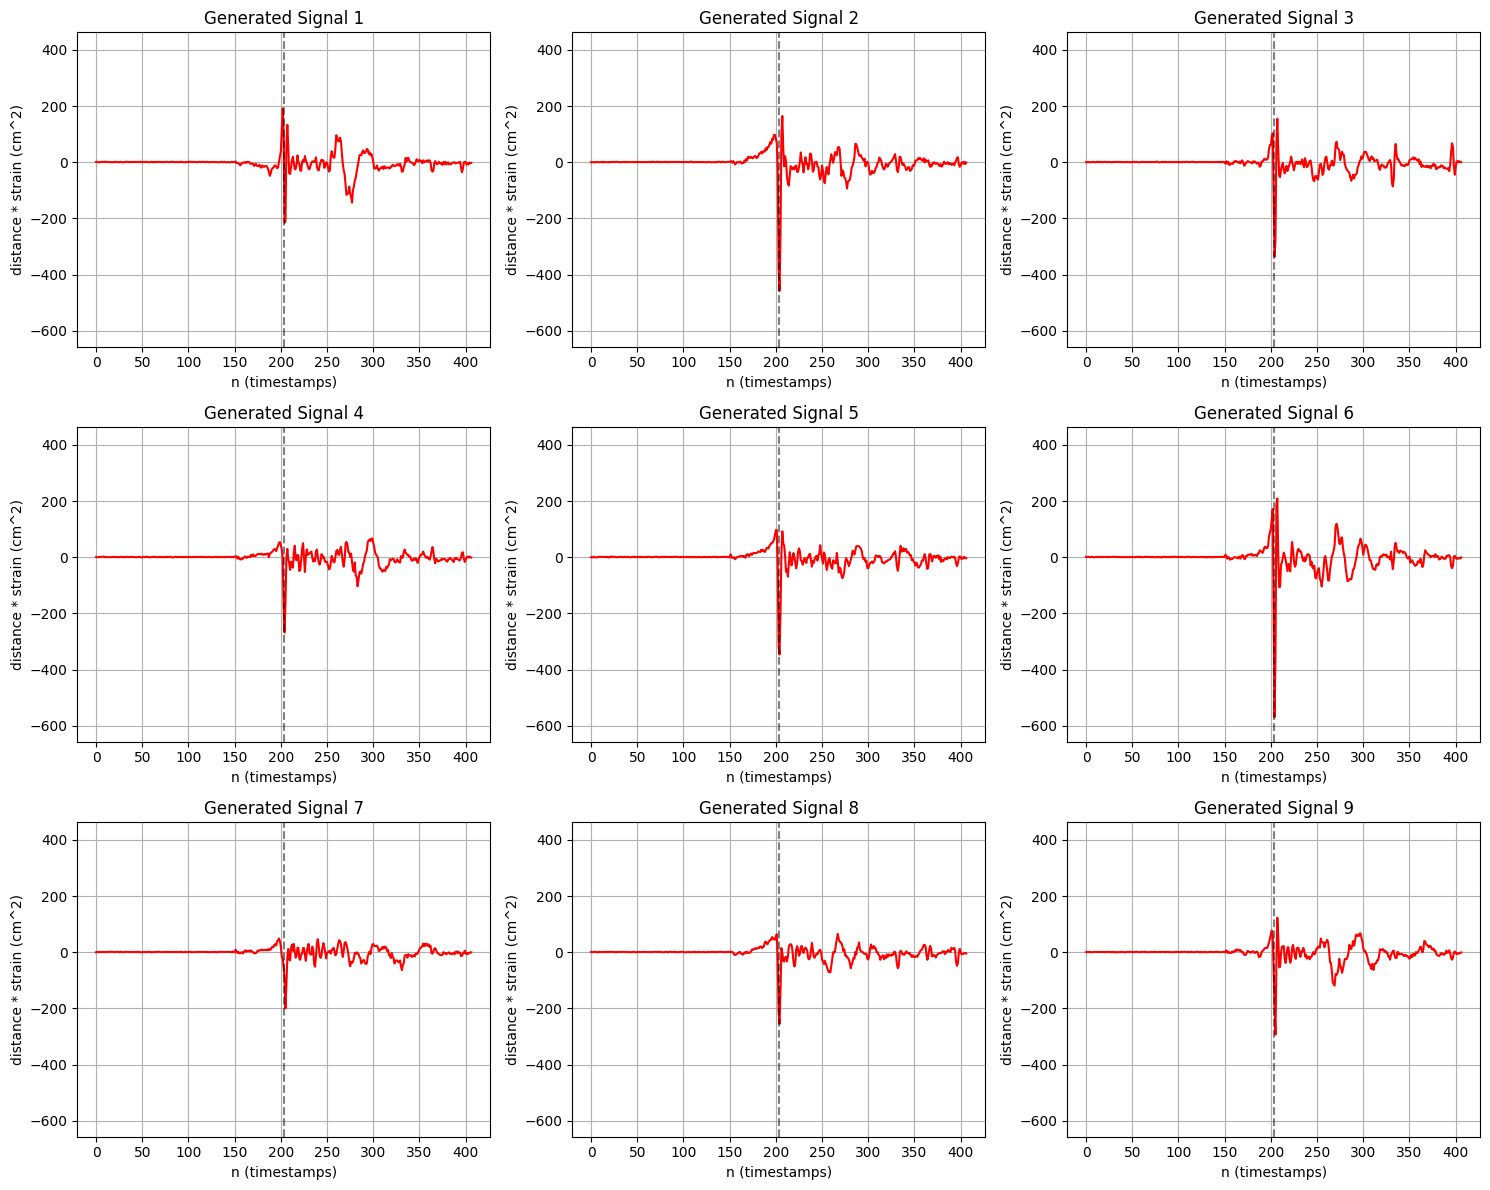

[10/32][0/188]	Loss_D: 0.5369	Loss_G: 1.5900	D(x): 0.9184	D(G(z)): 0.2484 / 0.2705
[10/32][50/188]	Loss_D: 0.5244	Loss_G: 2.2203	D(x): 0.9193	D(G(z)): 0.1705 / 0.1472
[10/32][100/188]	Loss_D: 0.5233	Loss_G: 2.4559	D(x): 0.9128	D(G(z)): 0.1005 / 0.1387
[10/32][150/188]	Loss_D: 0.5690	Loss_G: 1.8277	D(x): 0.9429	D(G(z)): 0.2379 / 0.2054
Epoch 10: SGD Discriminator lr 0.0000169 -> 0.0000166
Epoch 10: SGD Generator lr 0.0000169 -> 0.0000166


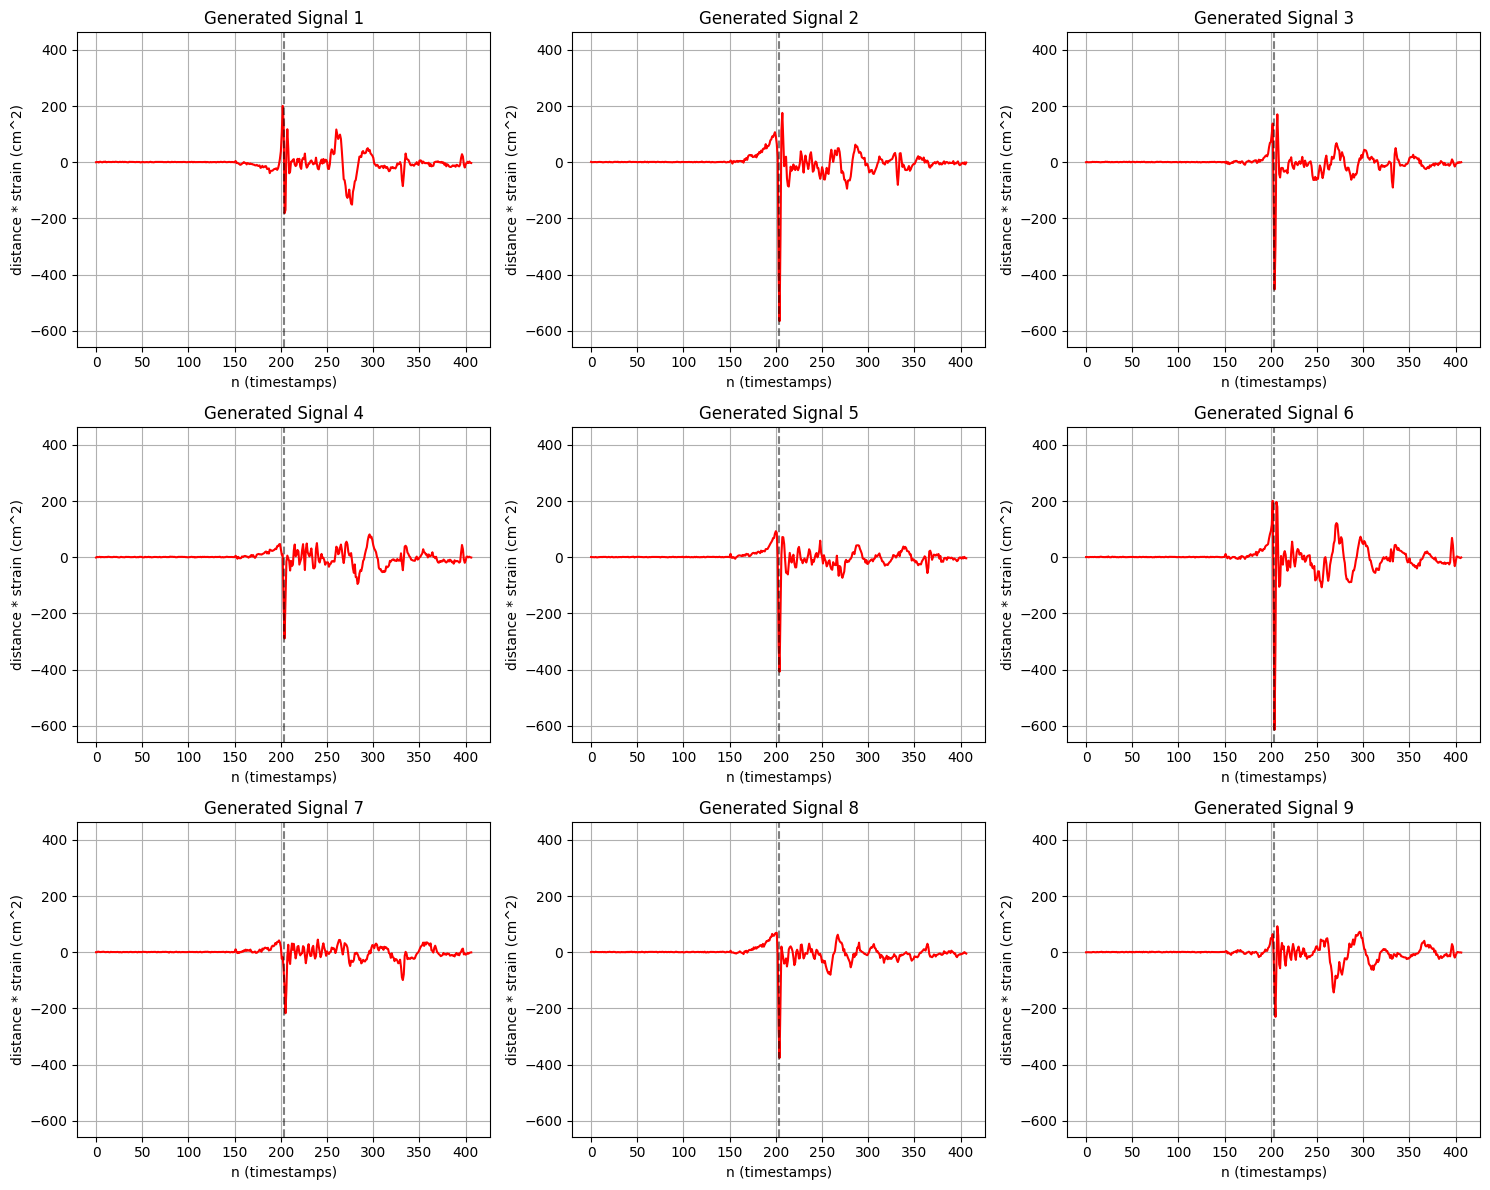

[11/32][0/188]	Loss_D: 0.5411	Loss_G: 2.0894	D(x): 0.9385	D(G(z)): 0.1946 / 0.1699
[11/32][50/188]	Loss_D: 0.4668	Loss_G: 1.9400	D(x): 0.9469	D(G(z)): 0.1459 / 0.1900
[11/32][100/188]	Loss_D: 0.5231	Loss_G: 2.0318	D(x): 0.9467	D(G(z)): 0.1717 / 0.1626
[11/32][150/188]	Loss_D: 0.5239	Loss_G: 1.9656	D(x): 0.9301	D(G(z)): 0.1873 / 0.1885
Epoch 11: SGD Discriminator lr 0.0000166 -> 0.0000162
Epoch 11: SGD Generator lr 0.0000166 -> 0.0000162


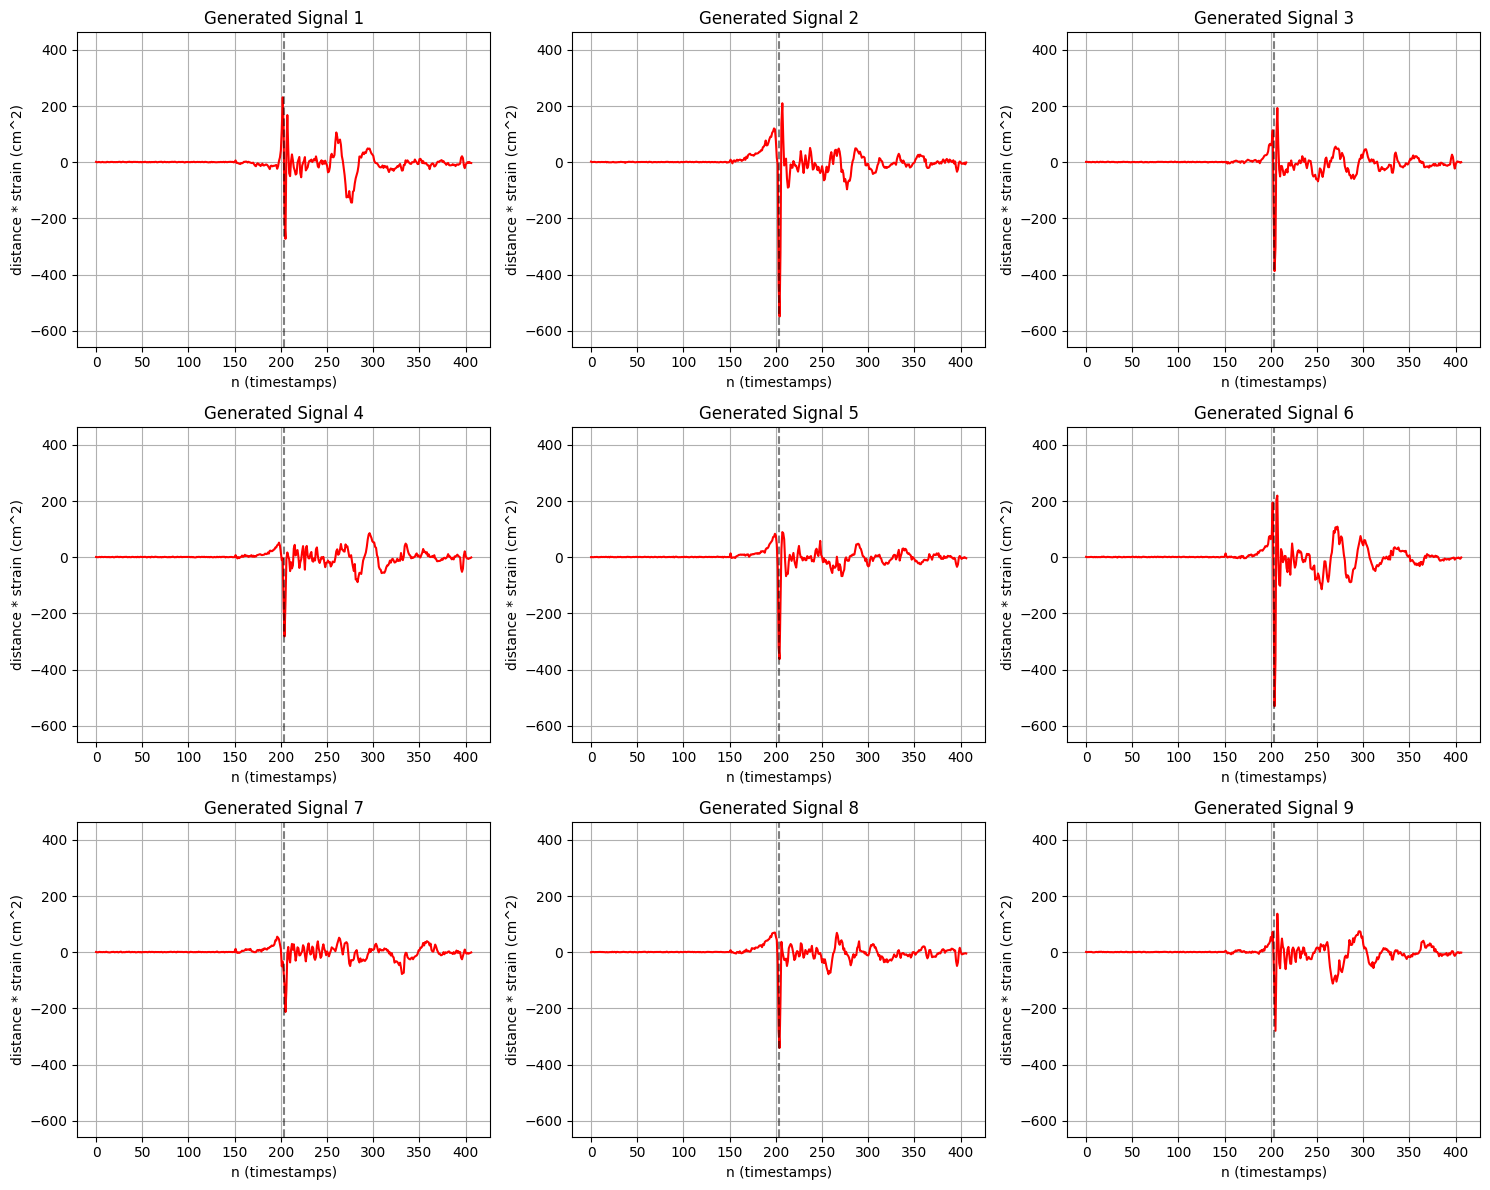

[12/32][0/188]	Loss_D: 0.5646	Loss_G: 2.2562	D(x): 0.9381	D(G(z)): 0.1584 / 0.1683
[12/32][50/188]	Loss_D: 0.5590	Loss_G: 2.0379	D(x): 0.9249	D(G(z)): 0.1722 / 0.1841
[12/32][100/188]	Loss_D: 0.4579	Loss_G: 2.0973	D(x): 0.9443	D(G(z)): 0.1577 / 0.1765
[12/32][150/188]	Loss_D: 0.4924	Loss_G: 1.8825	D(x): 0.9567	D(G(z)): 0.2014 / 0.1898
Epoch 12: SGD Discriminator lr 0.0000162 -> 0.0000159
Epoch 12: SGD Generator lr 0.0000162 -> 0.0000159


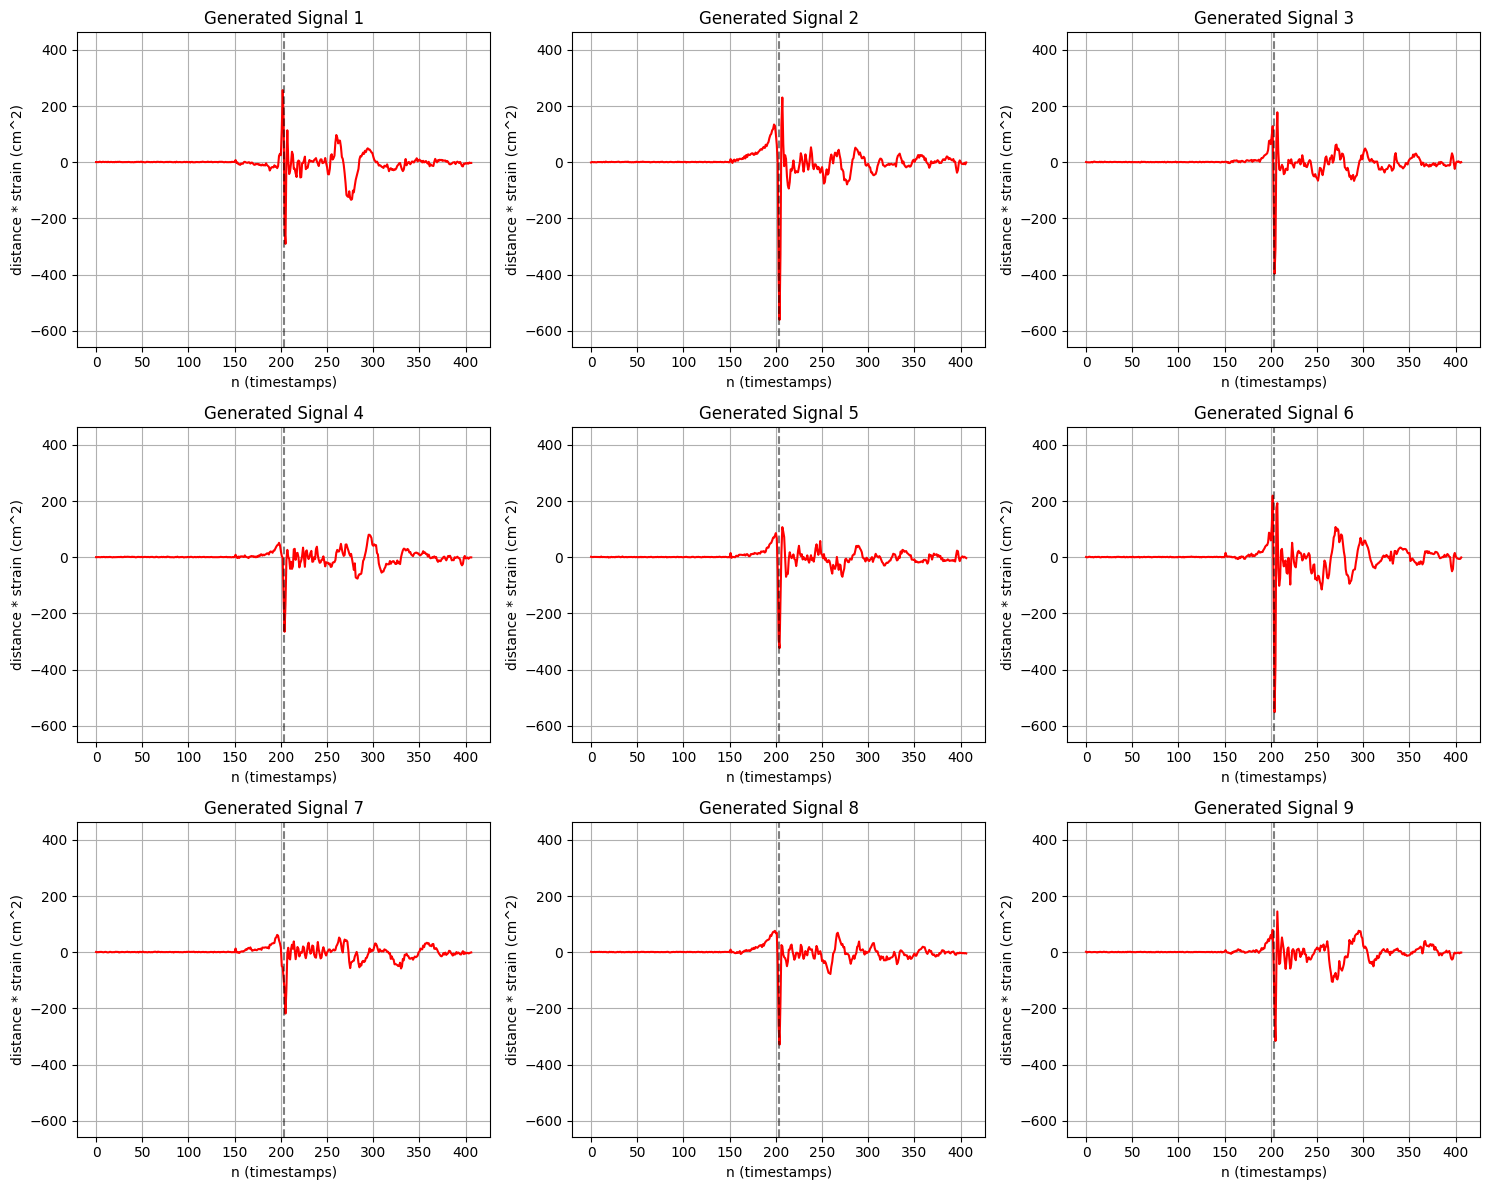

[13/32][0/188]	Loss_D: 0.5097	Loss_G: 1.9963	D(x): 0.9529	D(G(z)): 0.1725 / 0.1840
[13/32][50/188]	Loss_D: 0.5855	Loss_G: 1.8478	D(x): 0.9379	D(G(z)): 0.2530 / 0.2168
[13/32][100/188]	Loss_D: 0.4725	Loss_G: 1.8324	D(x): 0.9667	D(G(z)): 0.2039 / 0.2046
[13/32][150/188]	Loss_D: 0.5983	Loss_G: 2.0680	D(x): 0.9188	D(G(z)): 0.1299 / 0.1812
Epoch 13: SGD Discriminator lr 0.0000159 -> 0.0000156
Epoch 13: SGD Generator lr 0.0000159 -> 0.0000156


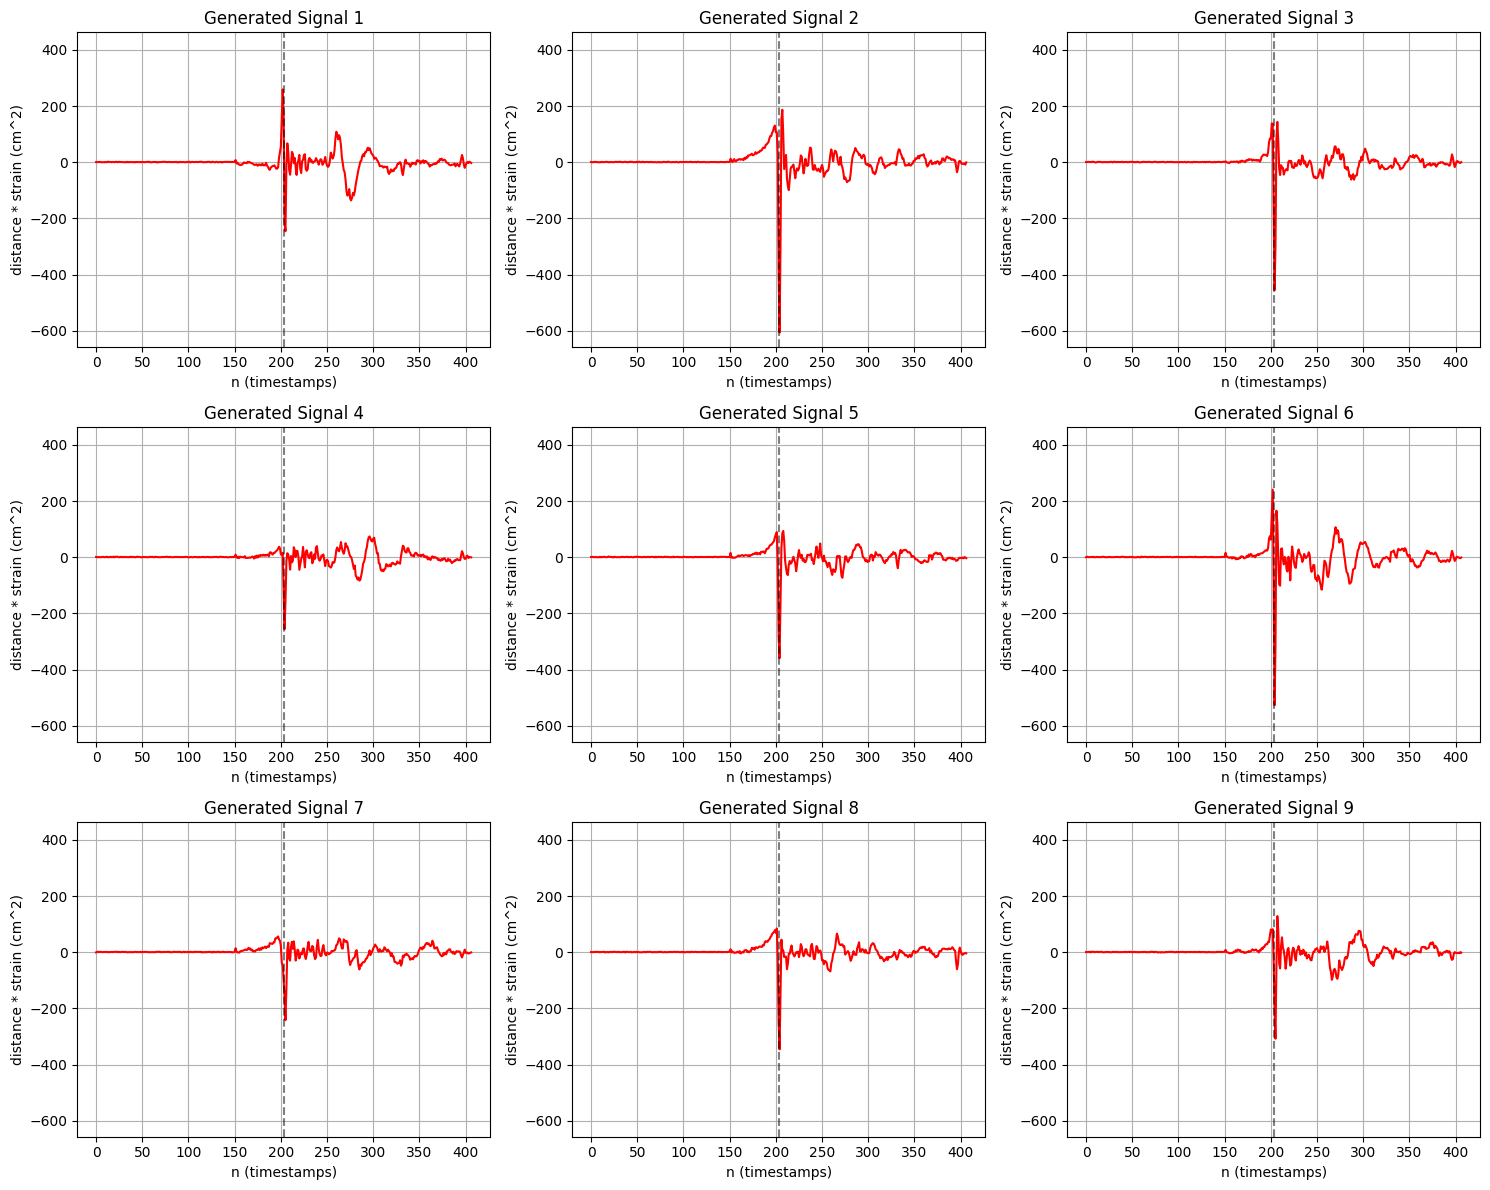

[14/32][0/188]	Loss_D: 0.5936	Loss_G: 1.7932	D(x): 0.9533	D(G(z)): 0.2628 / 0.2379
[14/32][50/188]	Loss_D: 0.4491	Loss_G: 1.9995	D(x): 0.9535	D(G(z)): 0.1640 / 0.1766
[14/32][100/188]	Loss_D: 0.4954	Loss_G: 1.9037	D(x): 0.9570	D(G(z)): 0.1630 / 0.1965
[14/32][150/188]	Loss_D: 0.6132	Loss_G: 1.9328	D(x): 0.9663	D(G(z)): 0.3508 / 0.2032
Epoch 14: SGD Discriminator lr 0.0000156 -> 0.0000153
Epoch 14: SGD Generator lr 0.0000156 -> 0.0000153


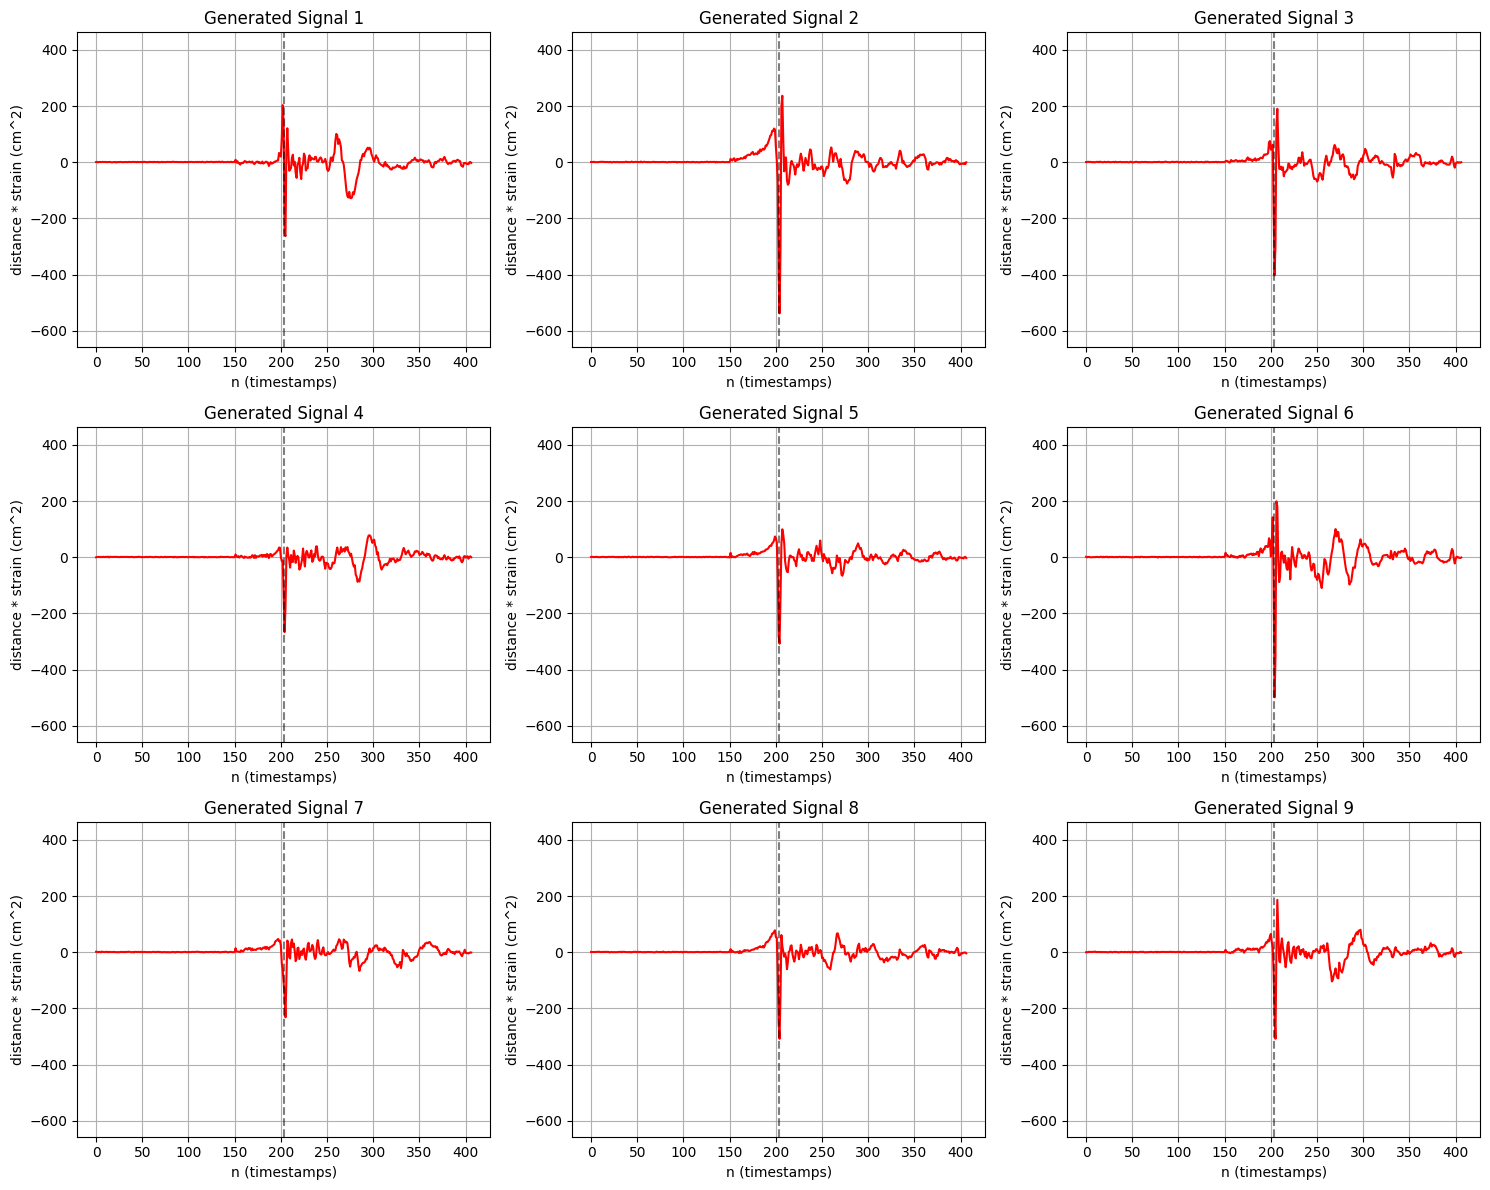

[15/32][0/188]	Loss_D: 0.4620	Loss_G: 2.2714	D(x): 0.9552	D(G(z)): 0.1613 / 0.1324
[15/32][50/188]	Loss_D: 0.4890	Loss_G: 2.2311	D(x): 0.9394	D(G(z)): 0.1572 / 0.1563
[15/32][100/188]	Loss_D: 0.5635	Loss_G: 1.7935	D(x): 0.9429	D(G(z)): 0.2759 / 0.2336
[15/32][150/188]	Loss_D: 0.4667	Loss_G: 2.1641	D(x): 0.9529	D(G(z)): 0.1938 / 0.1753
Epoch 15: SGD Discriminator lr 0.0000153 -> 0.0000150
Epoch 15: SGD Generator lr 0.0000153 -> 0.0000150


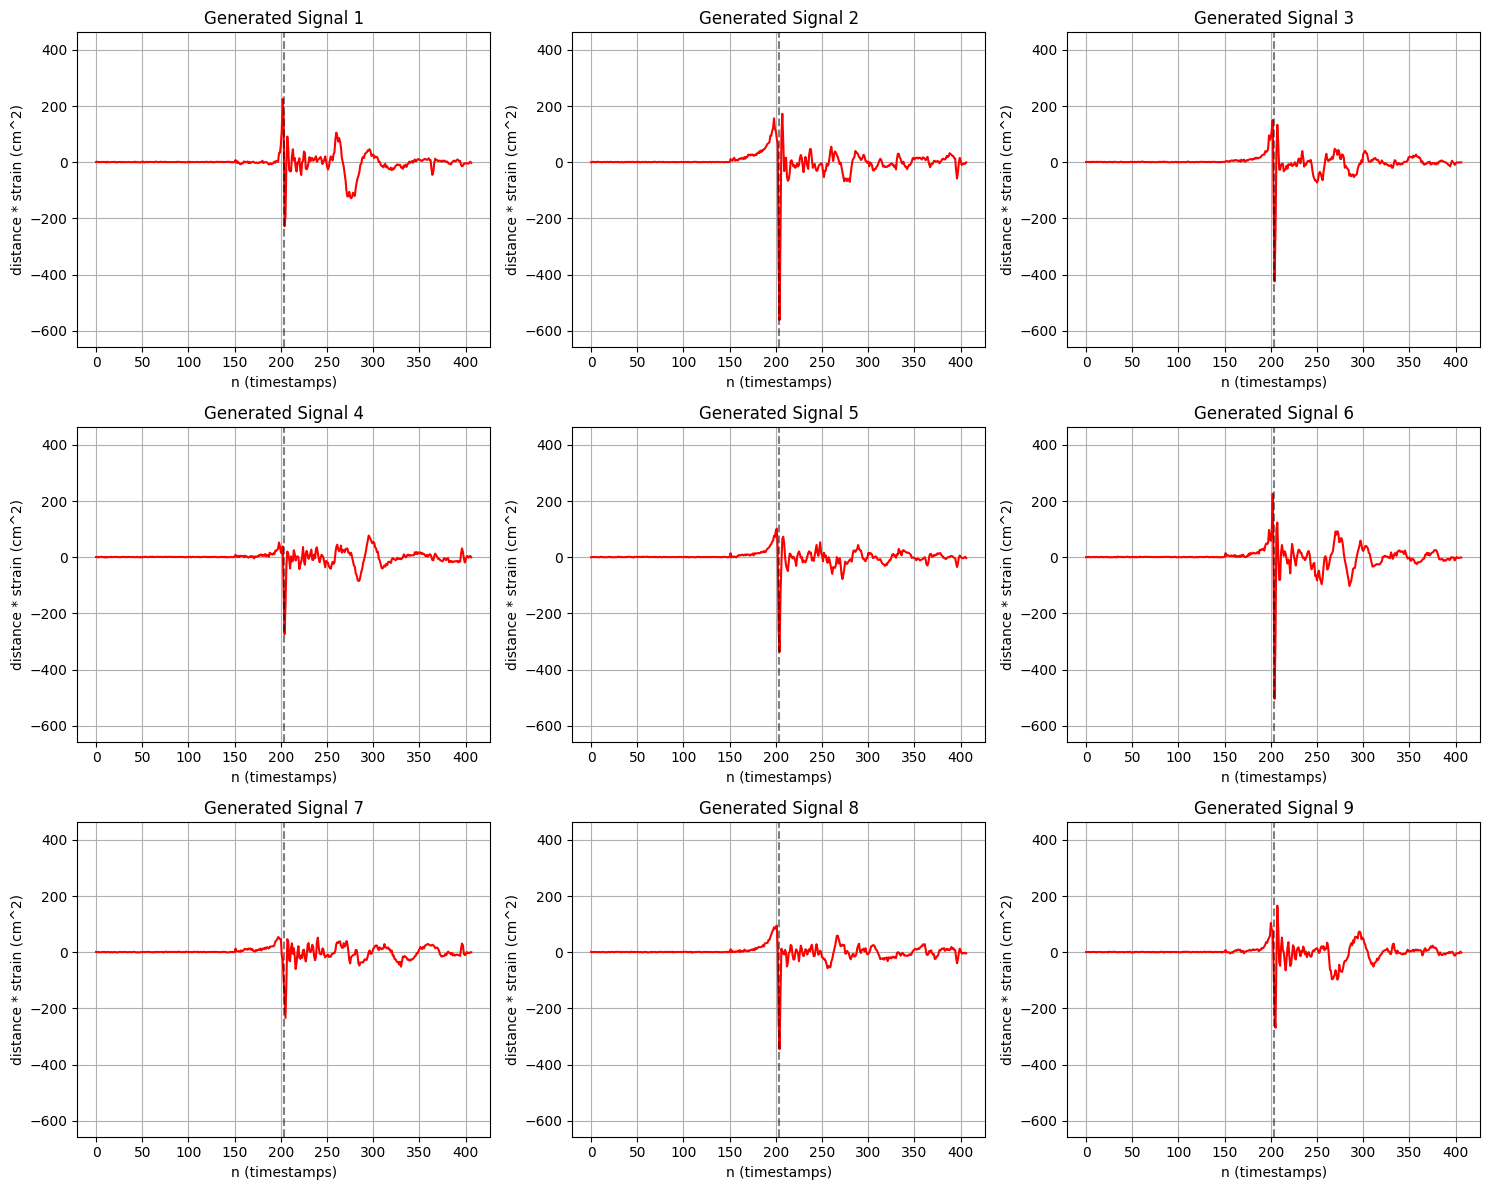

[16/32][0/188]	Loss_D: 0.5228	Loss_G: 1.5591	D(x): 0.9332	D(G(z)): 0.2248 / 0.2813
[16/32][50/188]	Loss_D: 0.6520	Loss_G: 2.8999	D(x): 0.8191	D(G(z)): 0.0685 / 0.0785
[16/32][100/188]	Loss_D: 0.5135	Loss_G: 2.2876	D(x): 0.9226	D(G(z)): 0.1269 / 0.1542
[16/32][150/188]	Loss_D: 0.5038	Loss_G: 1.8873	D(x): 0.9702	D(G(z)): 0.2295 / 0.2237
Epoch 16: SGD Discriminator lr 0.0000150 -> 0.0000147
Epoch 16: SGD Generator lr 0.0000150 -> 0.0000147


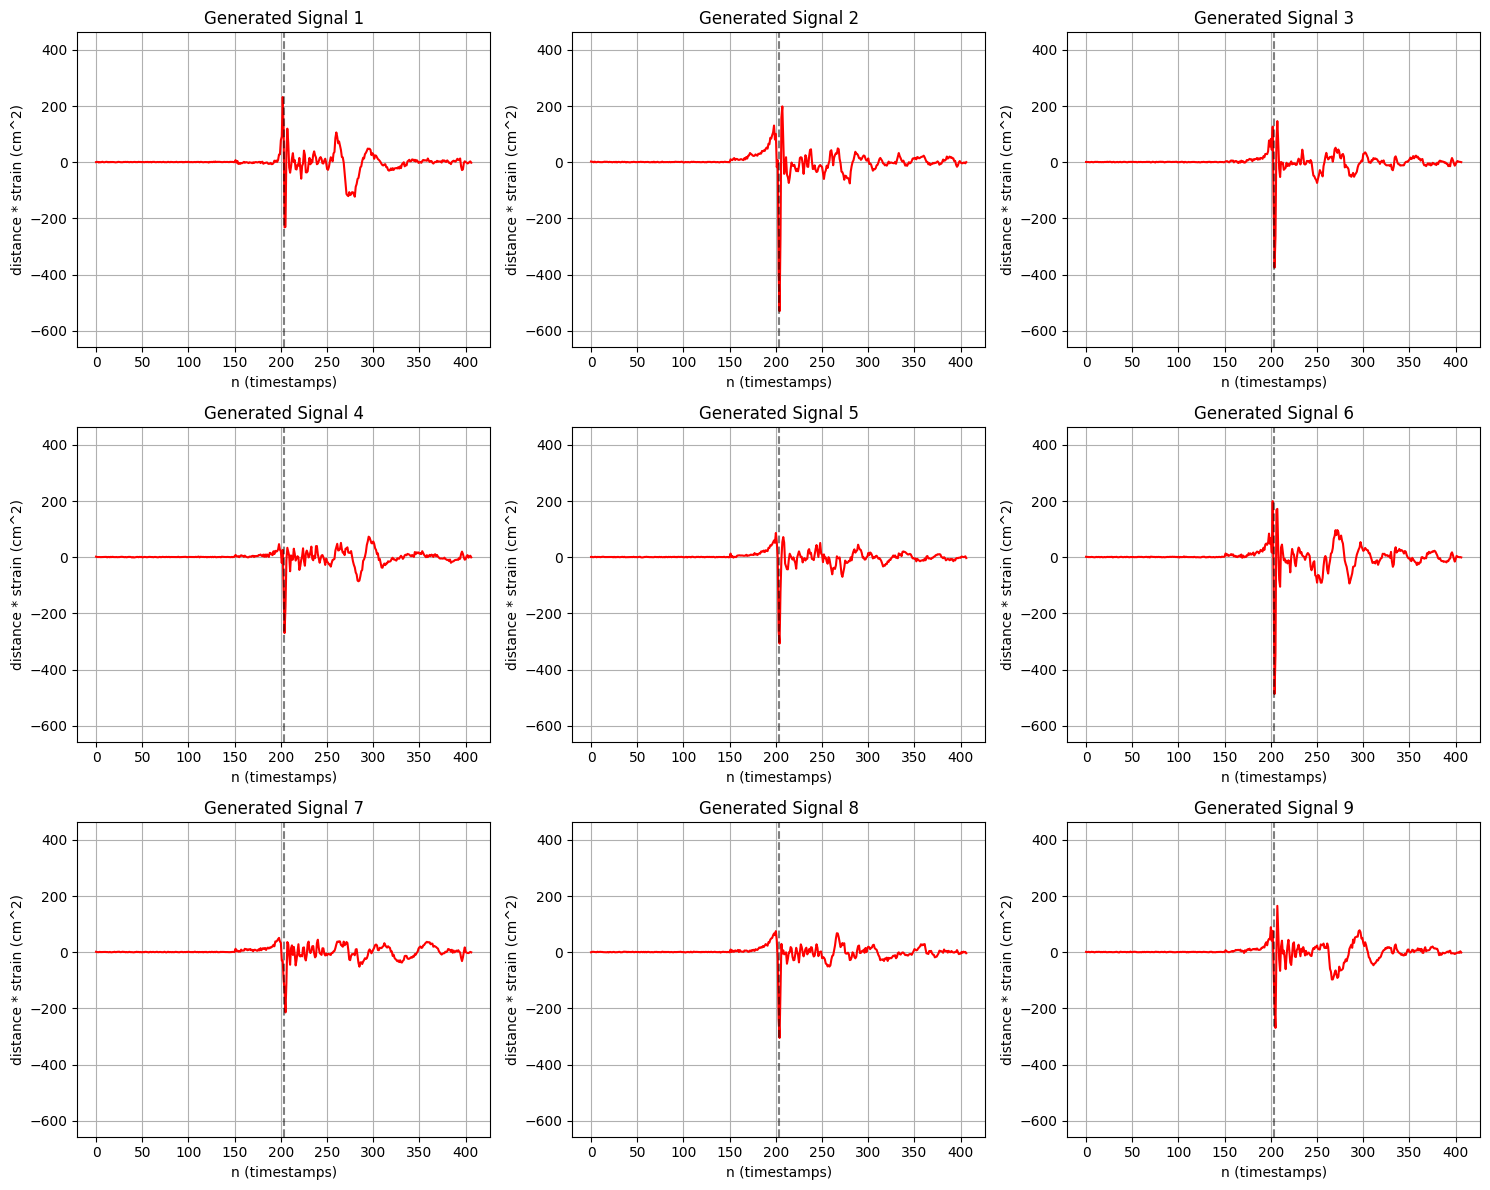

[17/32][0/188]	Loss_D: 0.5946	Loss_G: 1.5480	D(x): 0.9415	D(G(z)): 0.2586 / 0.2805
[17/32][50/188]	Loss_D: 0.4942	Loss_G: 2.2878	D(x): 0.9371	D(G(z)): 0.1493 / 0.1505
[17/32][100/188]	Loss_D: 0.4835	Loss_G: 2.3492	D(x): 0.9440	D(G(z)): 0.1406 / 0.1474
[17/32][150/188]	Loss_D: 0.4884	Loss_G: 2.2723	D(x): 0.9485	D(G(z)): 0.1834 / 0.1656
Epoch 17: SGD Discriminator lr 0.0000147 -> 0.0000144
Epoch 17: SGD Generator lr 0.0000147 -> 0.0000144


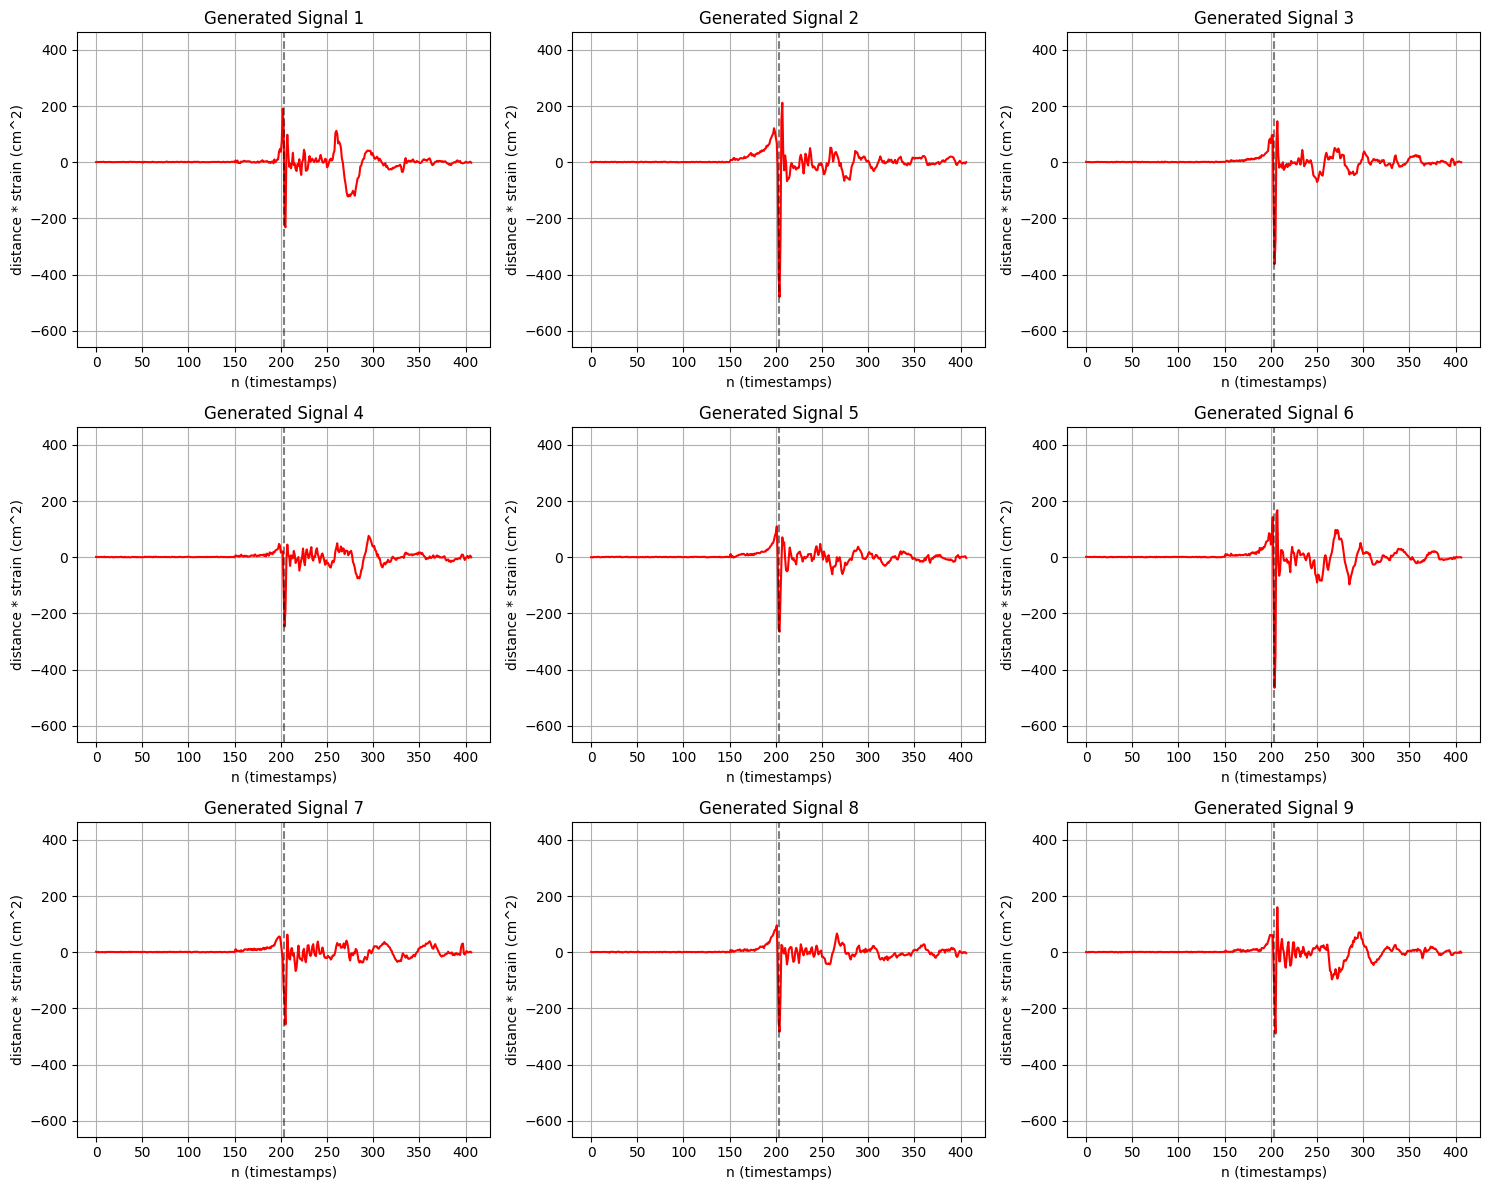

[18/32][0/188]	Loss_D: 0.4772	Loss_G: 2.2386	D(x): 0.9535	D(G(z)): 0.1550 / 0.1391
[18/32][50/188]	Loss_D: 0.4607	Loss_G: 1.8213	D(x): 0.9711	D(G(z)): 0.1928 / 0.1883
[18/32][100/188]	Loss_D: 0.5275	Loss_G: 2.0716	D(x): 0.9523	D(G(z)): 0.2461 / 0.1625
[18/32][150/188]	Loss_D: 0.5928	Loss_G: 2.1627	D(x): 0.9058	D(G(z)): 0.1963 / 0.1713
Epoch 18: SGD Discriminator lr 0.0000144 -> 0.0000141
Epoch 18: SGD Generator lr 0.0000144 -> 0.0000141


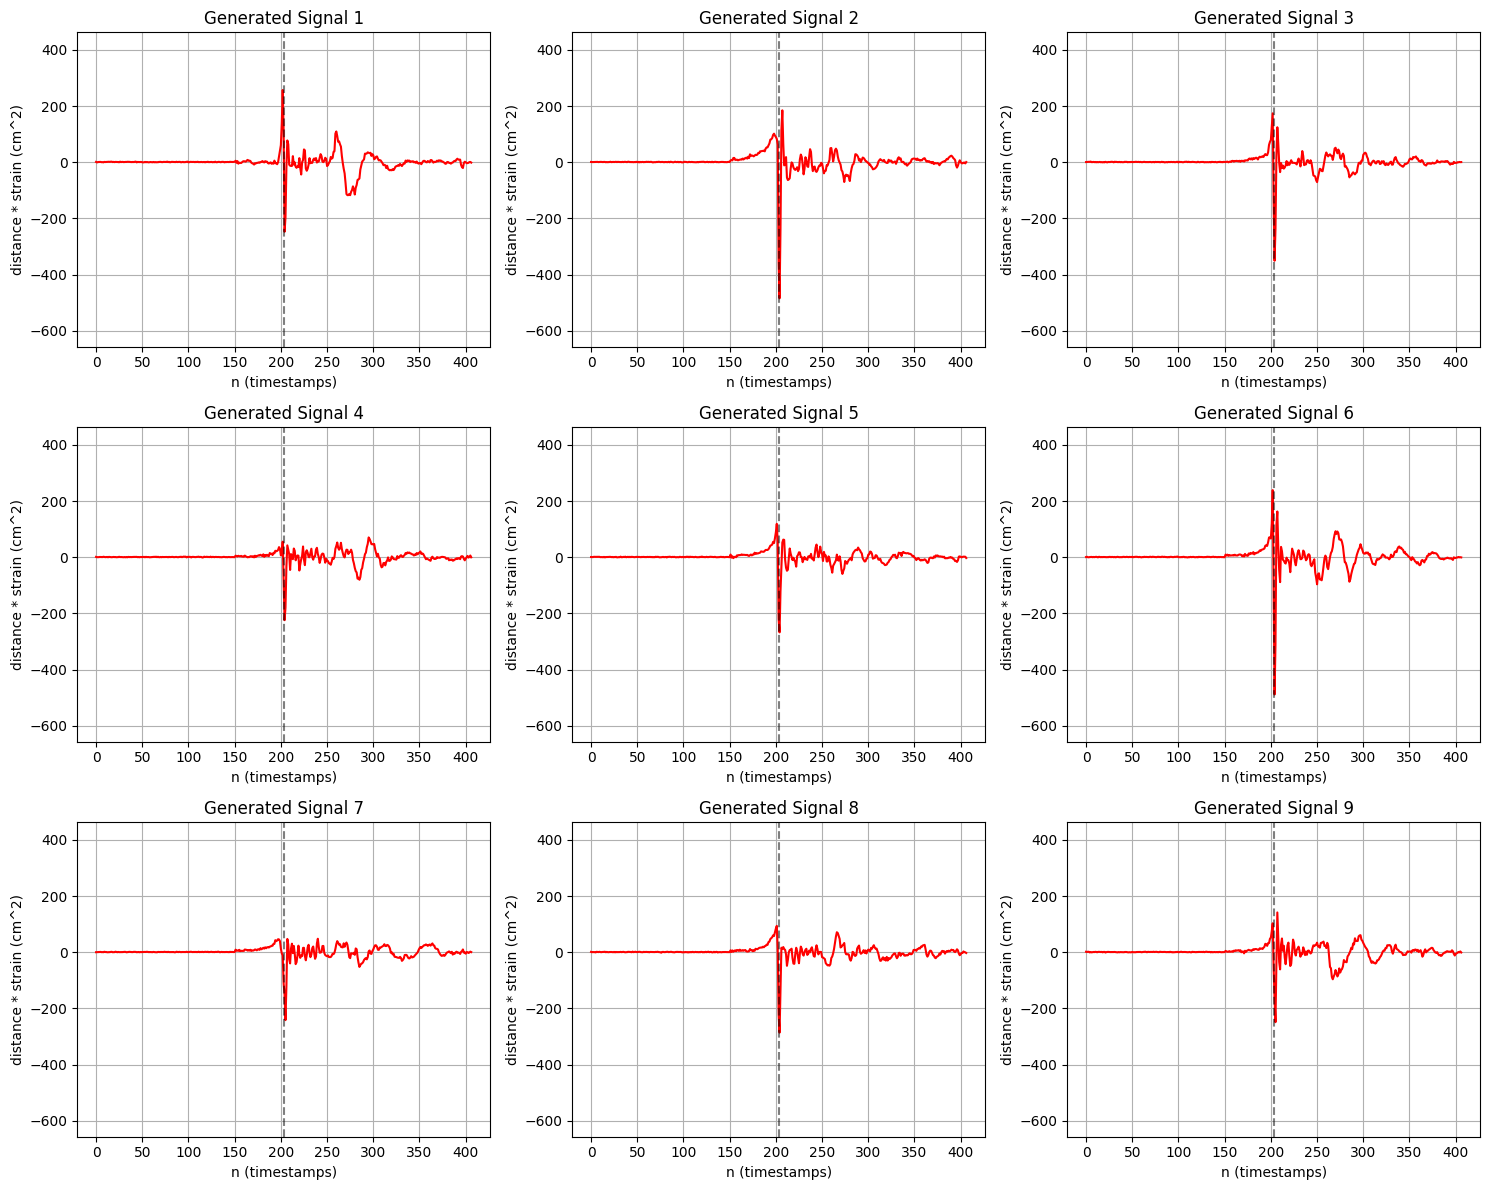

[19/32][0/188]	Loss_D: 0.4436	Loss_G: 2.0158	D(x): 0.9601	D(G(z)): 0.1804 / 0.1979
[19/32][50/188]	Loss_D: 0.4789	Loss_G: 2.6453	D(x): 0.9440	D(G(z)): 0.0713 / 0.0927
[19/32][100/188]	Loss_D: 0.4984	Loss_G: 2.0659	D(x): 0.9650	D(G(z)): 0.1180 / 0.1901
[19/32][150/188]	Loss_D: 0.4880	Loss_G: 1.9832	D(x): 0.9664	D(G(z)): 0.2039 / 0.1711
Epoch 19: SGD Discriminator lr 0.0000141 -> 0.0000137
Epoch 19: SGD Generator lr 0.0000141 -> 0.0000137


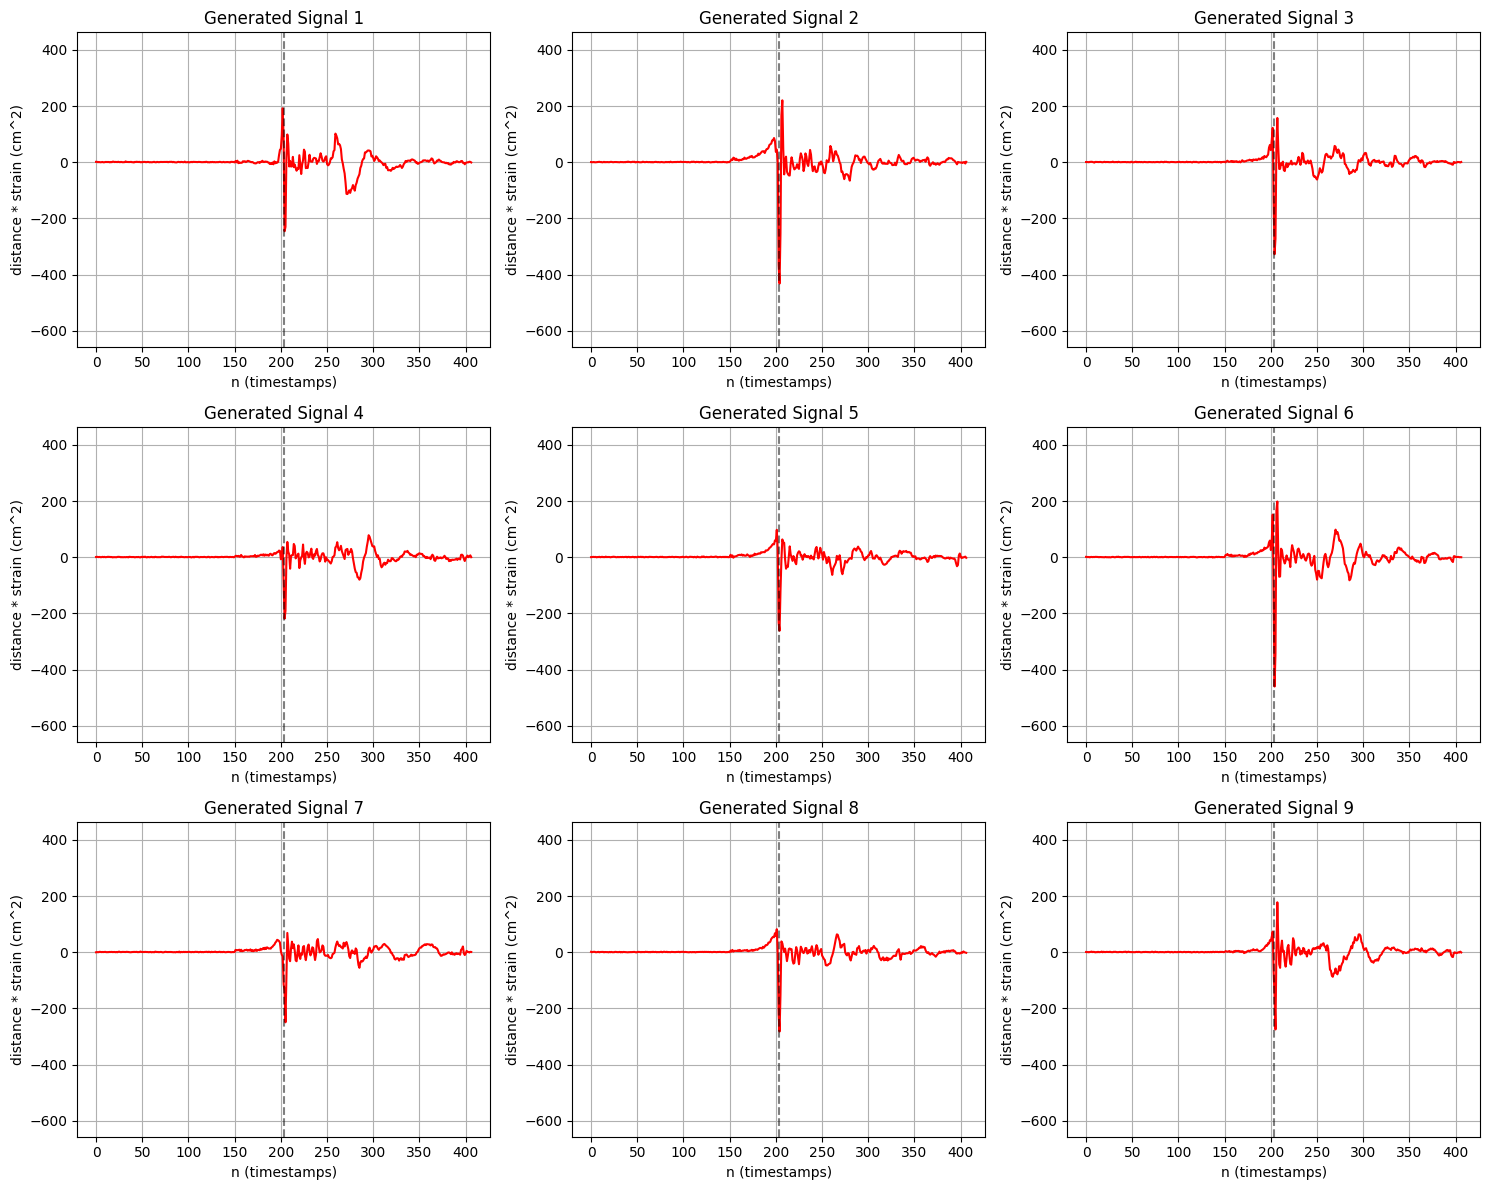

[20/32][0/188]	Loss_D: 0.5171	Loss_G: 2.5694	D(x): 0.9537	D(G(z)): 0.1314 / 0.1046
[20/32][50/188]	Loss_D: 0.4970	Loss_G: 1.8237	D(x): 0.9600	D(G(z)): 0.1762 / 0.2226
[20/32][100/188]	Loss_D: 0.6319	Loss_G: 2.1822	D(x): 0.8984	D(G(z)): 0.1972 / 0.1661
[20/32][150/188]	Loss_D: 0.5089	Loss_G: 2.2538	D(x): 0.9494	D(G(z)): 0.1991 / 0.1412
Epoch 20: SGD Discriminator lr 0.0000137 -> 0.0000134
Epoch 20: SGD Generator lr 0.0000137 -> 0.0000134


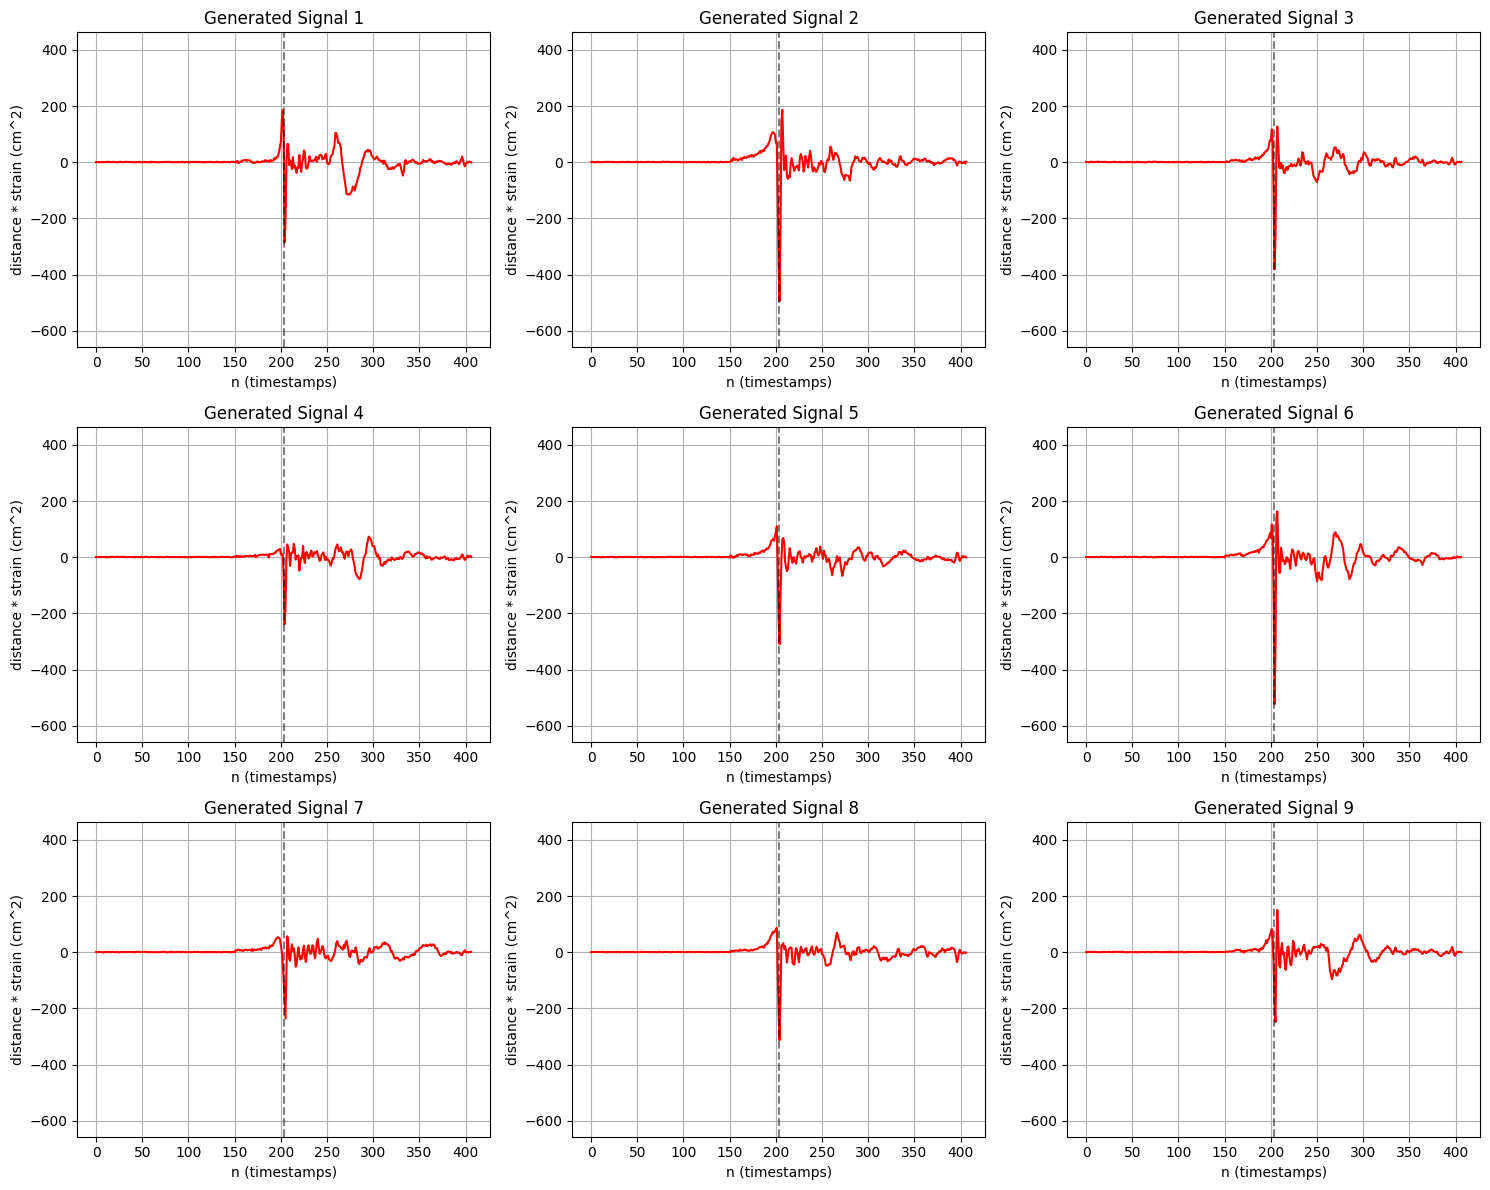

[21/32][0/188]	Loss_D: 0.4746	Loss_G: 2.5625	D(x): 0.9575	D(G(z)): 0.1388 / 0.1098
[21/32][50/188]	Loss_D: 0.5010	Loss_G: 2.4382	D(x): 0.9332	D(G(z)): 0.1480 / 0.1324
[21/32][100/188]	Loss_D: 0.5019	Loss_G: 2.2273	D(x): 0.9517	D(G(z)): 0.1614 / 0.1648
[21/32][150/188]	Loss_D: 0.4641	Loss_G: 2.1063	D(x): 0.9750	D(G(z)): 0.1521 / 0.1653
Epoch 21: SGD Discriminator lr 0.0000134 -> 0.0000131
Epoch 21: SGD Generator lr 0.0000134 -> 0.0000131


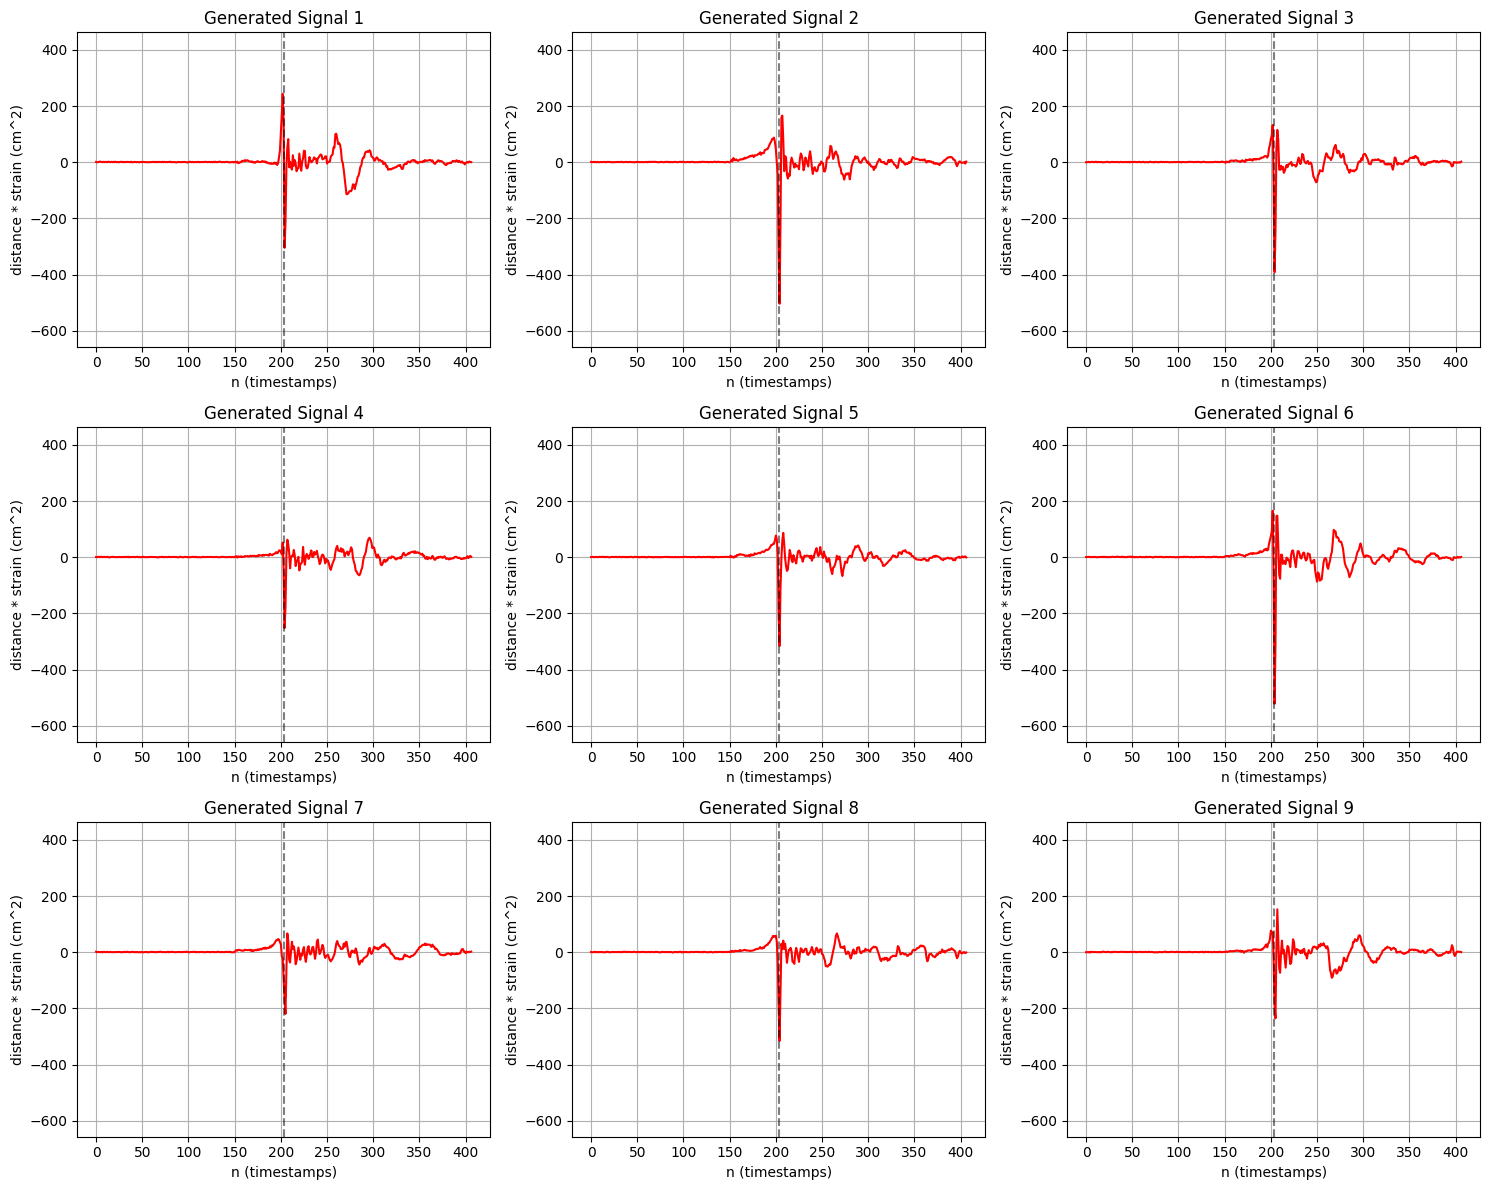

[22/32][0/188]	Loss_D: 0.4759	Loss_G: 2.4031	D(x): 0.9483	D(G(z)): 0.1175 / 0.1339
[22/32][50/188]	Loss_D: 0.5802	Loss_G: 2.6321	D(x): 0.9338	D(G(z)): 0.1026 / 0.1066
[22/32][100/188]	Loss_D: 0.4669	Loss_G: 1.9907	D(x): 0.9539	D(G(z)): 0.1858 / 0.1797
[22/32][150/188]	Loss_D: 0.5258	Loss_G: 2.4389	D(x): 0.9613	D(G(z)): 0.1696 / 0.1502
Epoch 22: SGD Discriminator lr 0.0000131 -> 0.0000128
Epoch 22: SGD Generator lr 0.0000131 -> 0.0000128


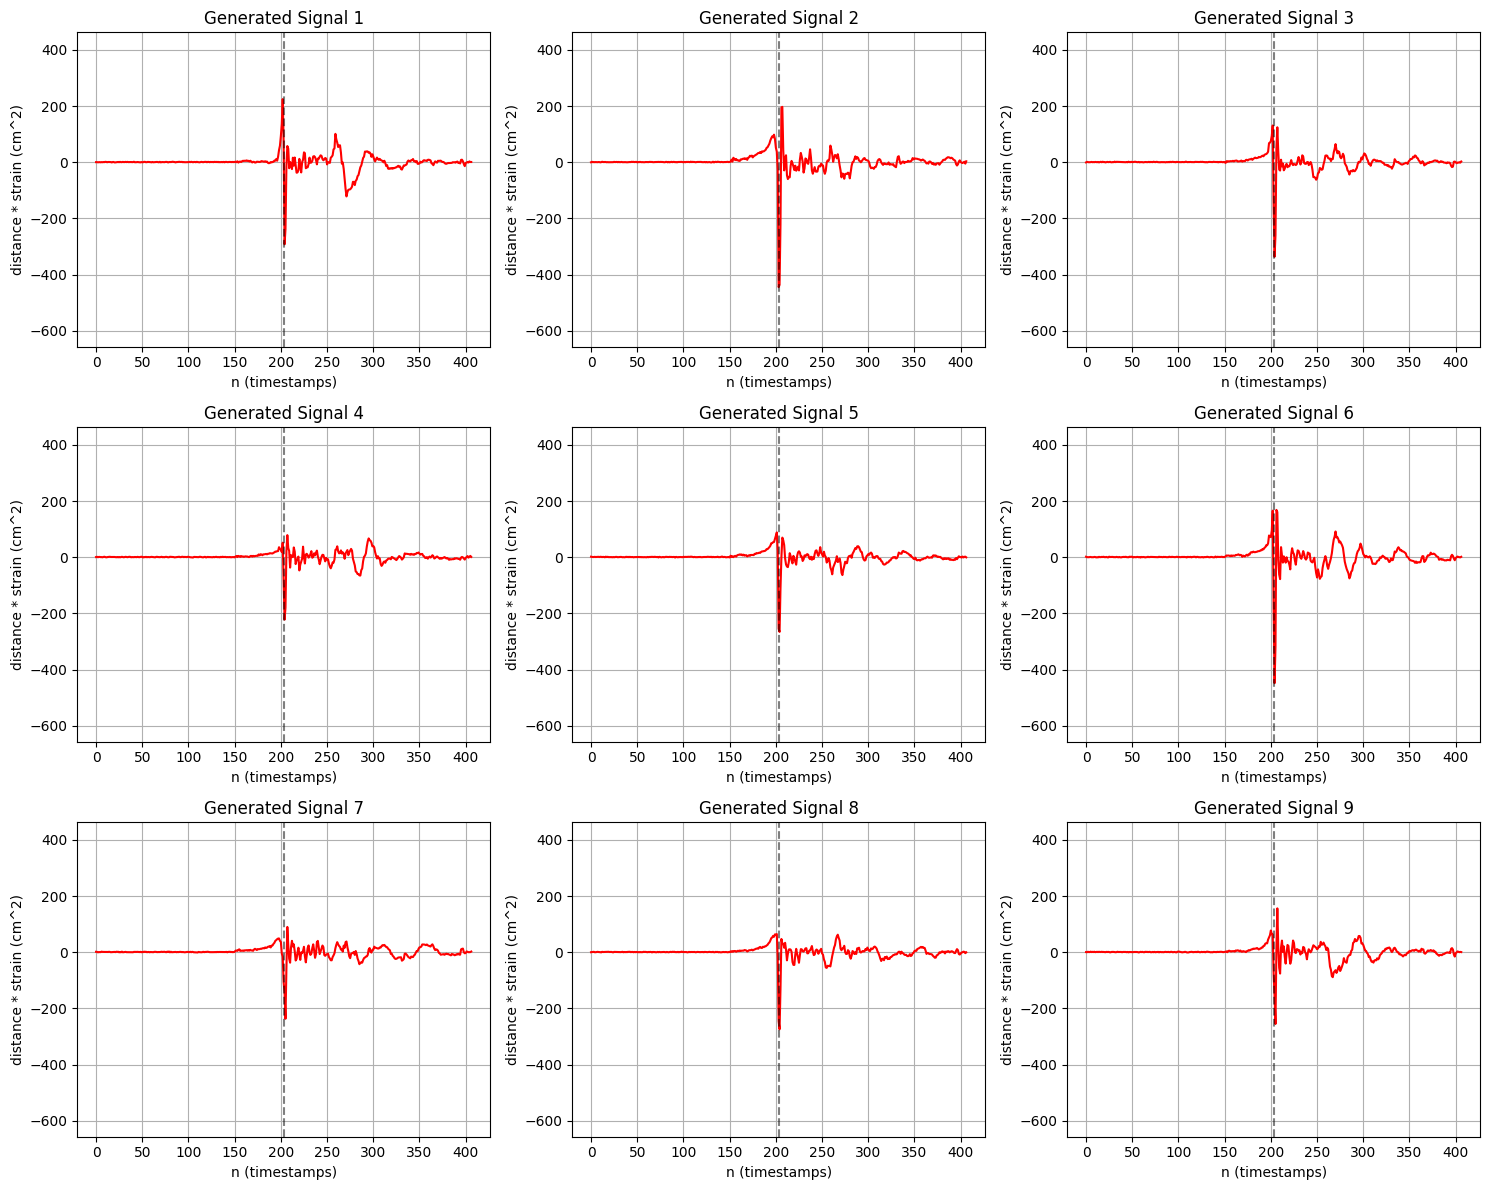

[23/32][0/188]	Loss_D: 0.5252	Loss_G: 2.1794	D(x): 0.9503	D(G(z)): 0.2523 / 0.1632
[23/32][50/188]	Loss_D: 0.4758	Loss_G: 2.3265	D(x): 0.9461	D(G(z)): 0.1378 / 0.1547
[23/32][100/188]	Loss_D: 0.5782	Loss_G: 1.7504	D(x): 0.9007	D(G(z)): 0.2293 / 0.2215
[23/32][150/188]	Loss_D: 0.5222	Loss_G: 1.9420	D(x): 0.9407	D(G(z)): 0.1818 / 0.1903
Epoch 23: SGD Discriminator lr 0.0000128 -> 0.0000125
Epoch 23: SGD Generator lr 0.0000128 -> 0.0000125


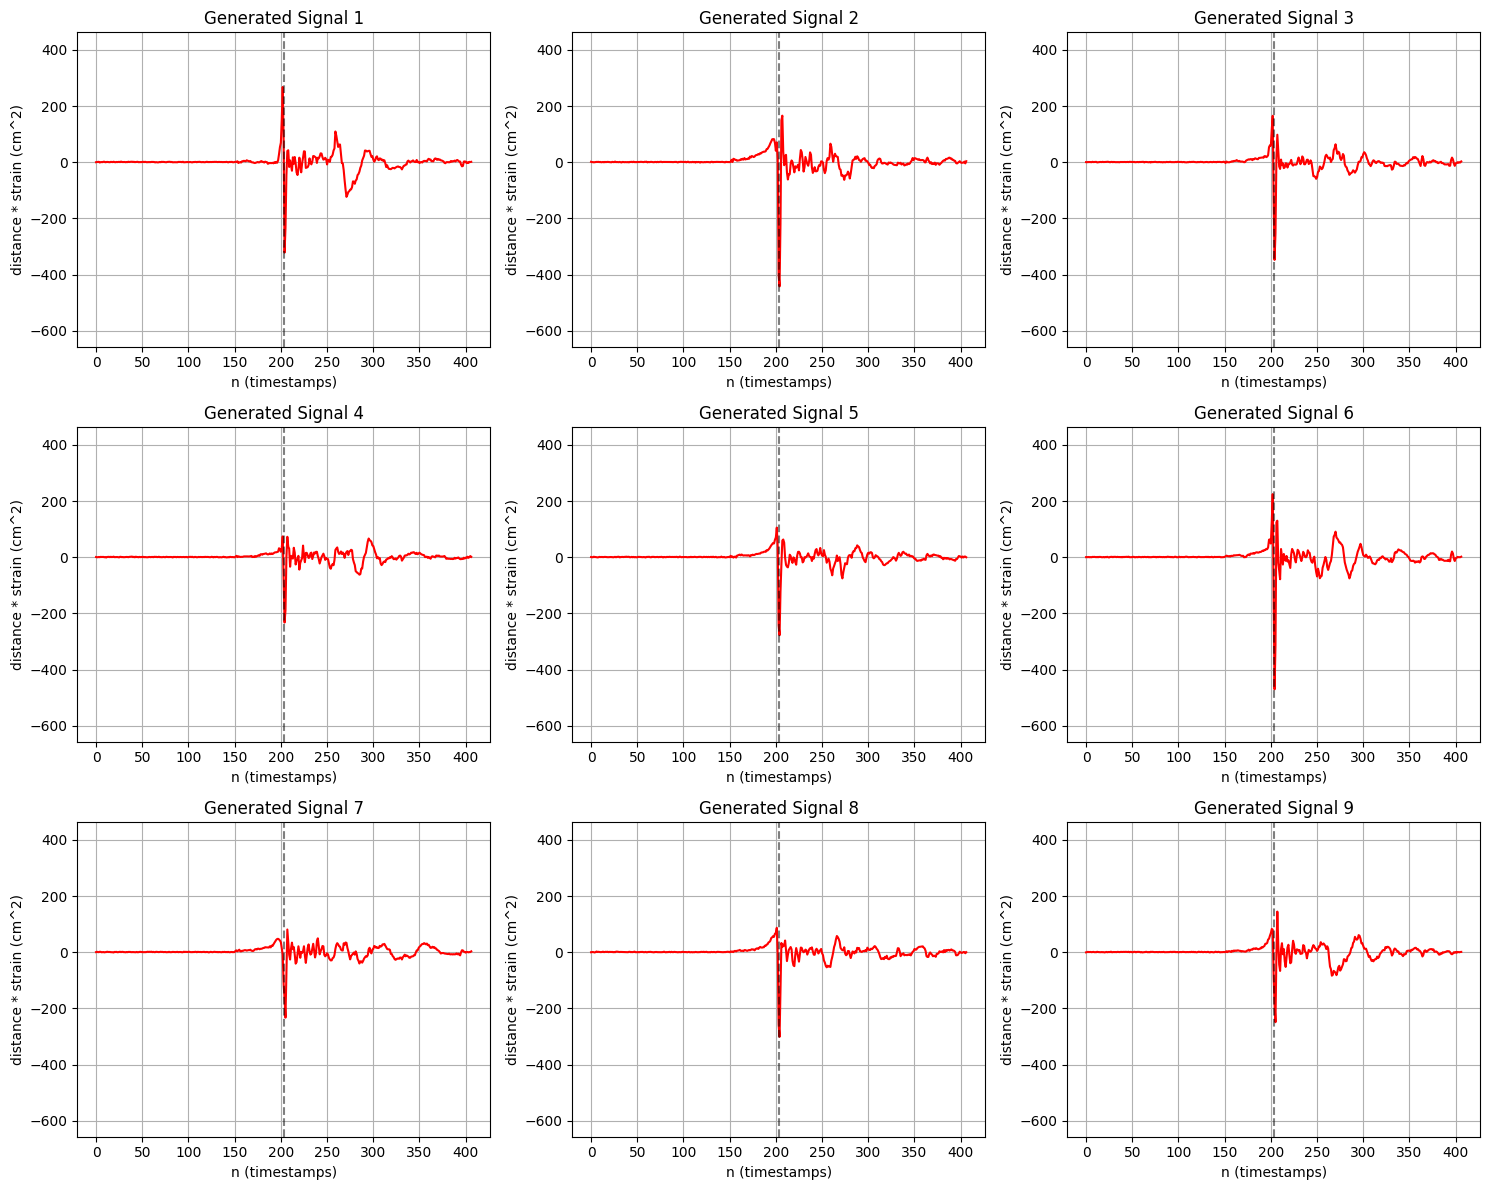

[24/32][0/188]	Loss_D: 0.4921	Loss_G: 2.1765	D(x): 0.9248	D(G(z)): 0.1212 / 0.1483
[24/32][50/188]	Loss_D: 0.4907	Loss_G: 2.3823	D(x): 0.9296	D(G(z)): 0.1155 / 0.1295
[24/32][100/188]	Loss_D: 0.4473	Loss_G: 2.1216	D(x): 0.9720	D(G(z)): 0.1460 / 0.1735
[24/32][150/188]	Loss_D: 0.4701	Loss_G: 1.7737	D(x): 0.9752	D(G(z)): 0.2167 / 0.2086
Epoch 24: SGD Discriminator lr 0.0000125 -> 0.0000122
Epoch 24: SGD Generator lr 0.0000125 -> 0.0000122


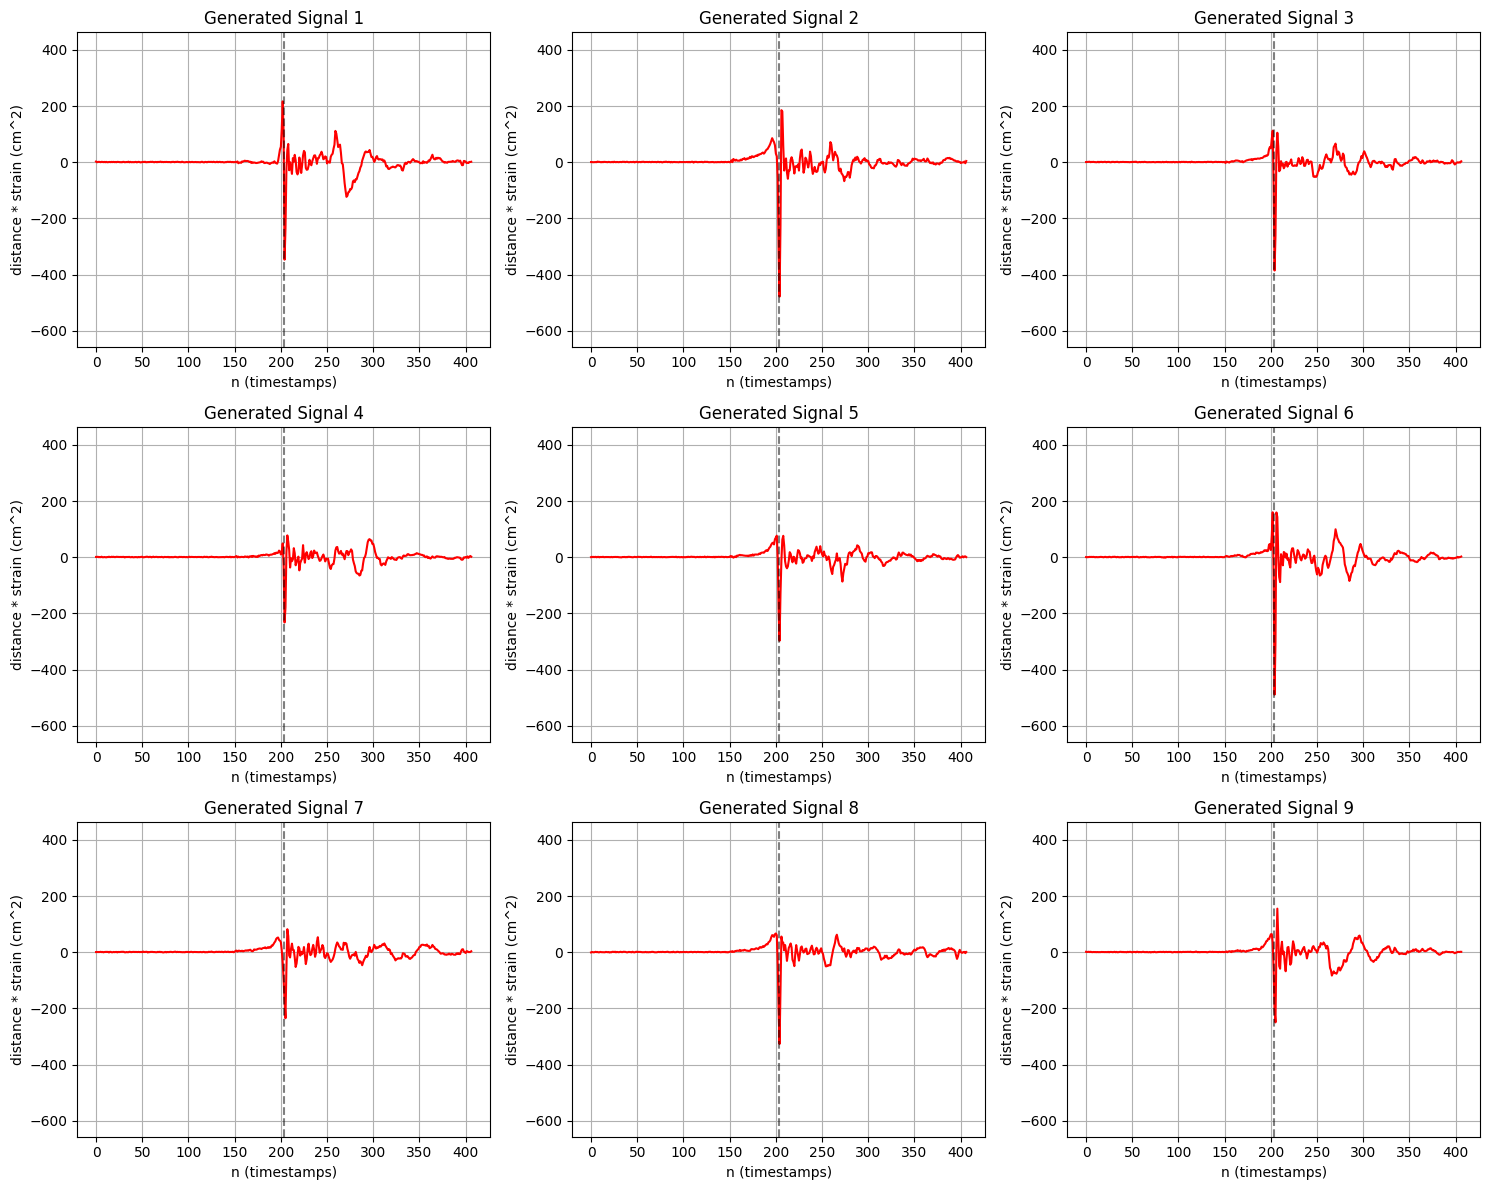

[25/32][0/188]	Loss_D: 0.5688	Loss_G: 2.4589	D(x): 0.9159	D(G(z)): 0.1422 / 0.1251
[25/32][50/188]	Loss_D: 0.5417	Loss_G: 2.3754	D(x): 0.9339	D(G(z)): 0.1717 / 0.1336
[25/32][100/188]	Loss_D: 0.5166	Loss_G: 2.2744	D(x): 0.9345	D(G(z)): 0.1118 / 0.1327
[25/32][150/188]	Loss_D: 0.5309	Loss_G: 2.3299	D(x): 0.9437	D(G(z)): 0.1149 / 0.1298
Epoch 25: SGD Discriminator lr 0.0000122 -> 0.0000119
Epoch 25: SGD Generator lr 0.0000122 -> 0.0000119


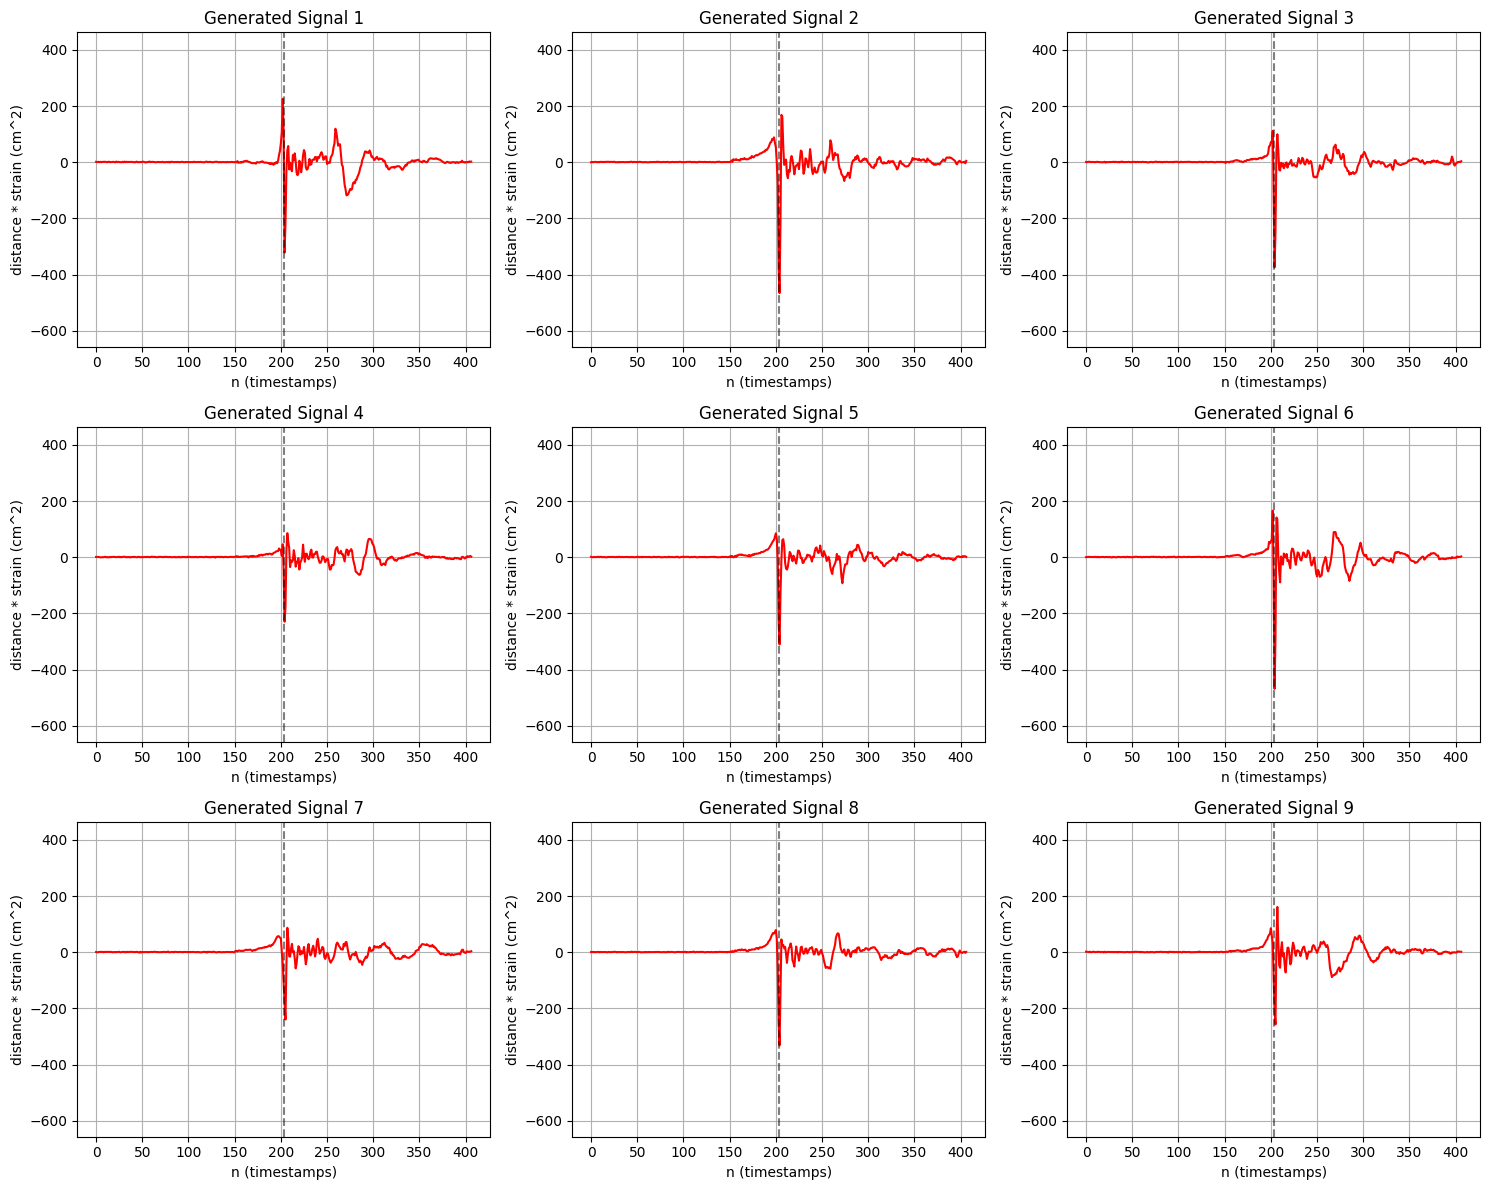

[26/32][0/188]	Loss_D: 0.5266	Loss_G: 2.3386	D(x): 0.9278	D(G(z)): 0.1673 / 0.1304
[26/32][50/188]	Loss_D: 0.4582	Loss_G: 2.2112	D(x): 0.9526	D(G(z)): 0.1913 / 0.1444
[26/32][100/188]	Loss_D: 0.4714	Loss_G: 2.9184	D(x): 0.9629	D(G(z)): 0.0785 / 0.0728
[26/32][150/188]	Loss_D: 0.5477	Loss_G: 1.8869	D(x): 0.9545	D(G(z)): 0.2640 / 0.2228
Epoch 26: SGD Discriminator lr 0.0000119 -> 0.0000116
Epoch 26: SGD Generator lr 0.0000119 -> 0.0000116


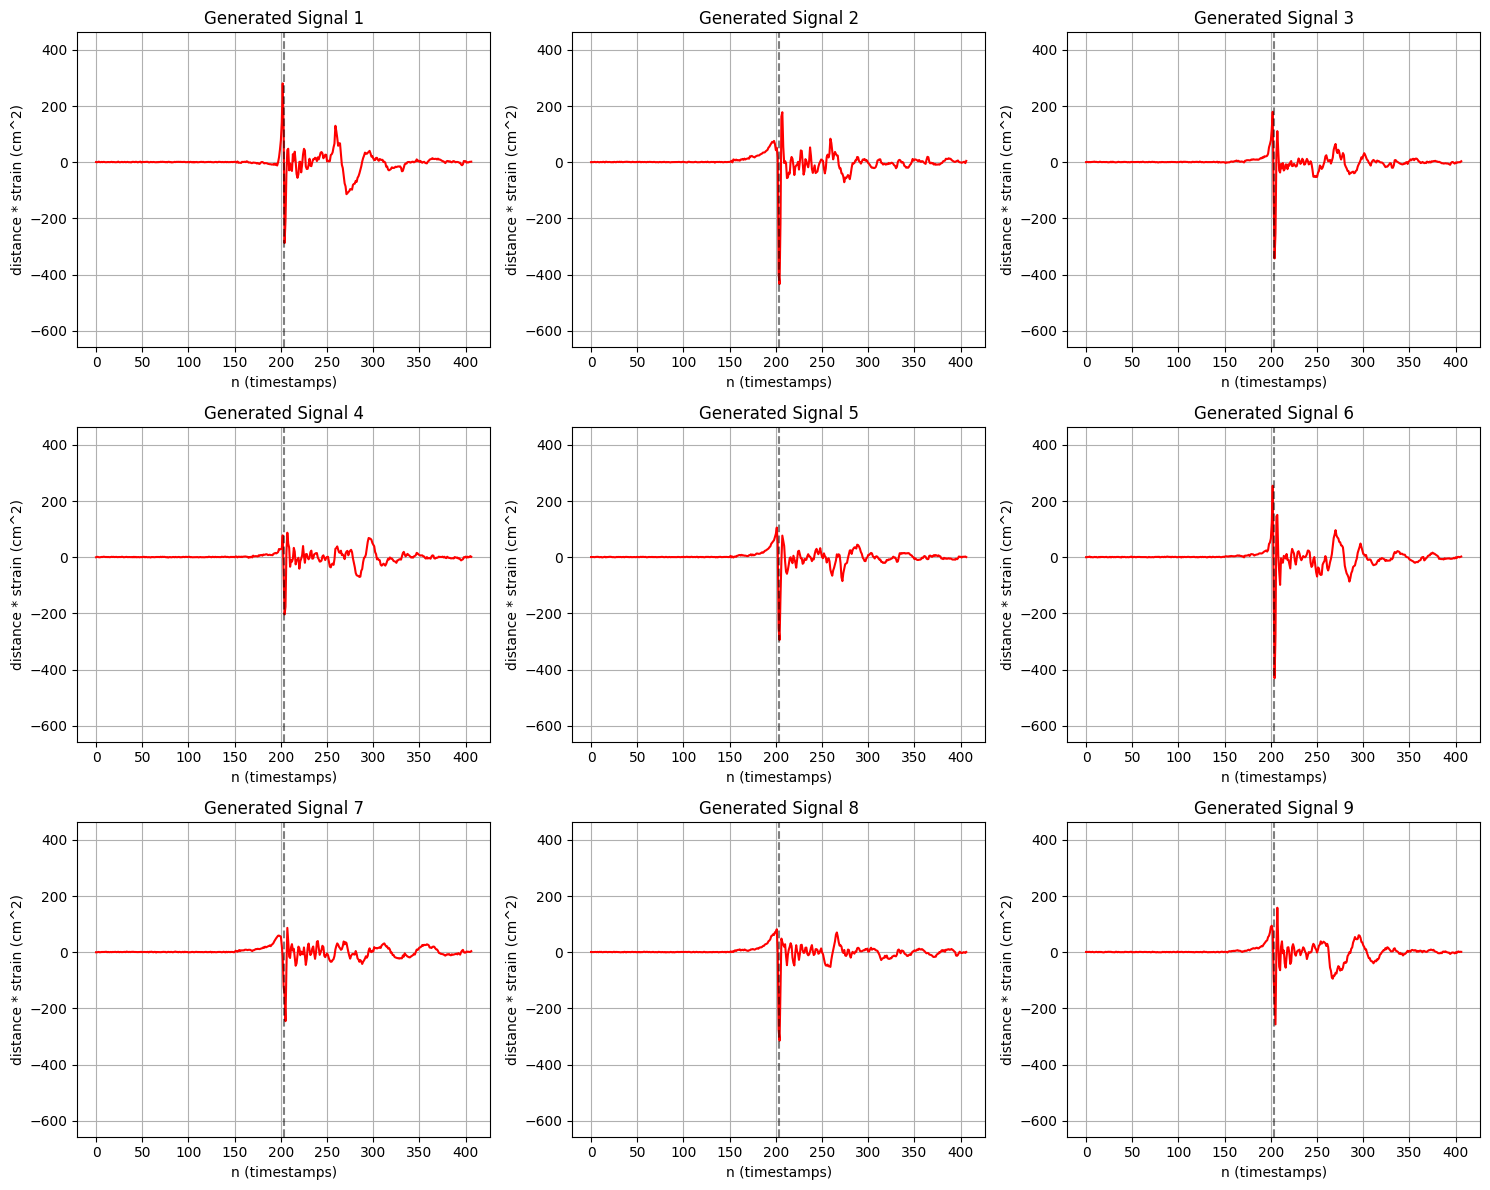

[27/32][0/188]	Loss_D: 0.4349	Loss_G: 2.2439	D(x): 0.9792	D(G(z)): 0.1297 / 0.1457
[27/32][50/188]	Loss_D: 0.5597	Loss_G: 2.0949	D(x): 0.9569	D(G(z)): 0.2396 / 0.1902
[27/32][100/188]	Loss_D: 0.5659	Loss_G: 2.3168	D(x): 0.9410	D(G(z)): 0.1420 / 0.1333
[27/32][150/188]	Loss_D: 0.5120	Loss_G: 2.0706	D(x): 0.9646	D(G(z)): 0.1990 / 0.1630
Epoch 27: SGD Discriminator lr 0.0000116 -> 0.0000112
Epoch 27: SGD Generator lr 0.0000116 -> 0.0000112


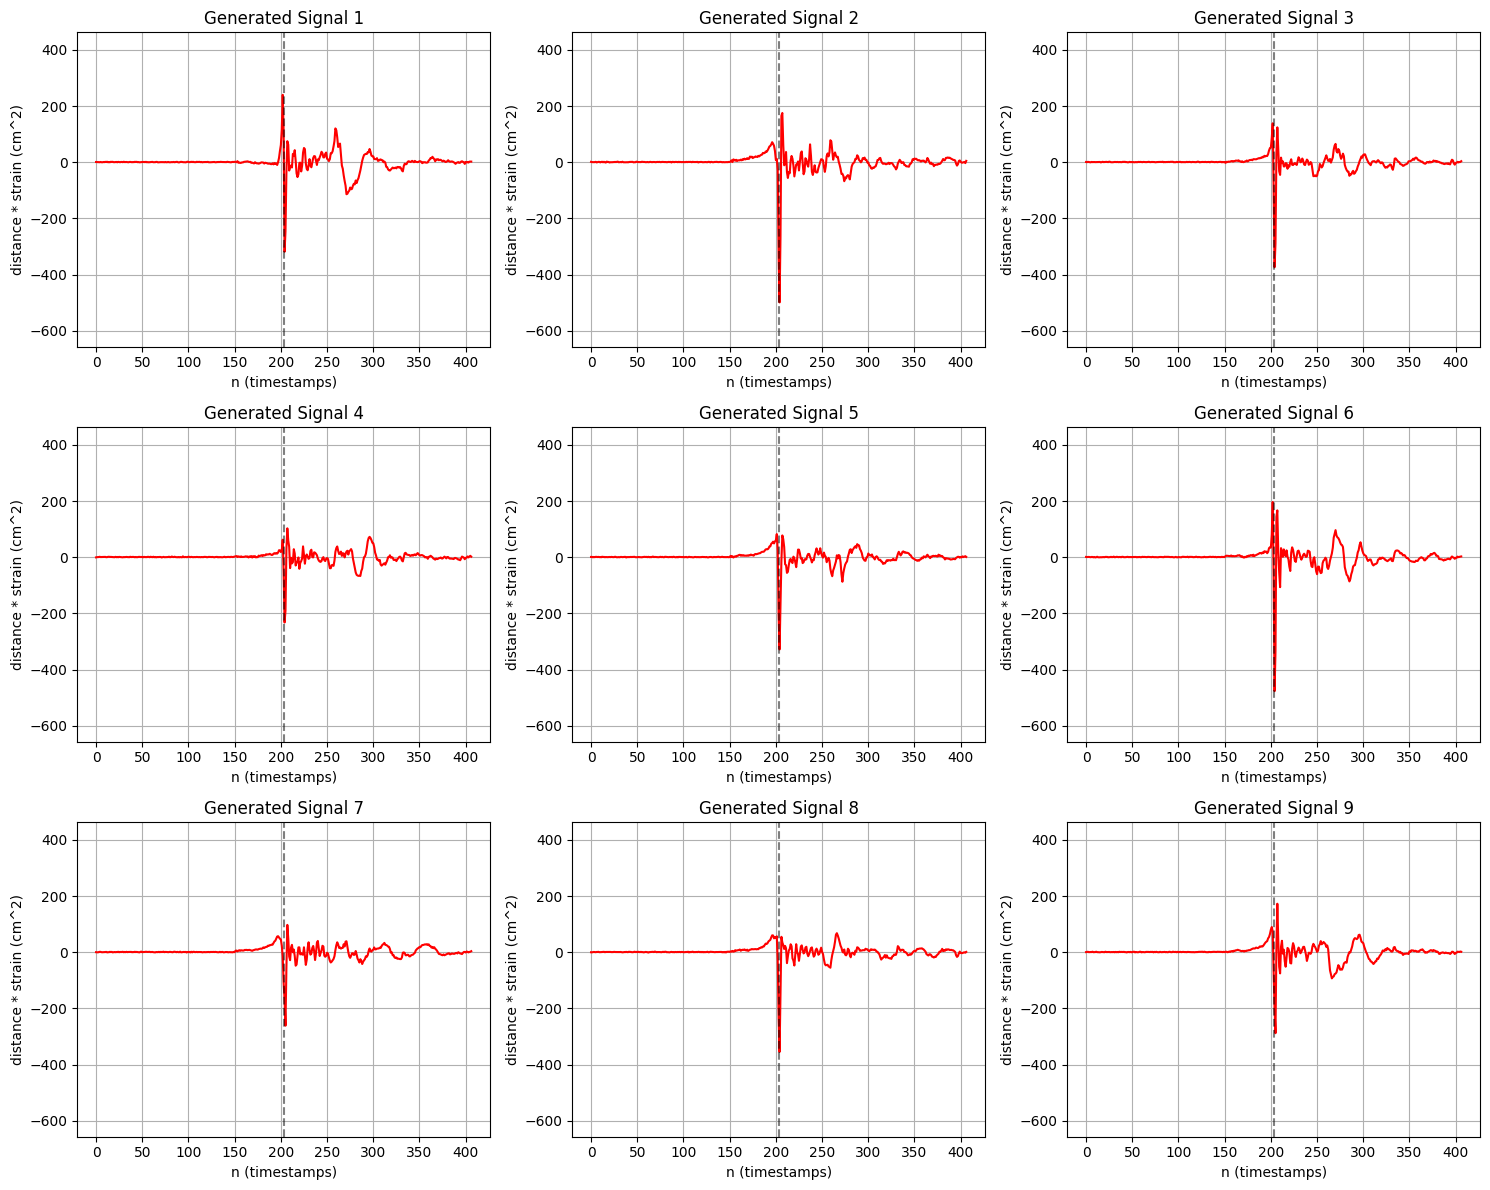

[28/32][0/188]	Loss_D: 0.4510	Loss_G: 2.1905	D(x): 0.9451	D(G(z)): 0.1063 / 0.1401
[28/32][50/188]	Loss_D: 0.4967	Loss_G: 1.8001	D(x): 0.9734	D(G(z)): 0.2741 / 0.2246
[28/32][100/188]	Loss_D: 0.4158	Loss_G: 2.4761	D(x): 0.9523	D(G(z)): 0.1360 / 0.1163
[28/32][150/188]	Loss_D: 0.5772	Loss_G: 2.0581	D(x): 0.9091	D(G(z)): 0.1869 / 0.1710
Epoch 28: SGD Discriminator lr 0.0000112 -> 0.0000109
Epoch 28: SGD Generator lr 0.0000112 -> 0.0000109


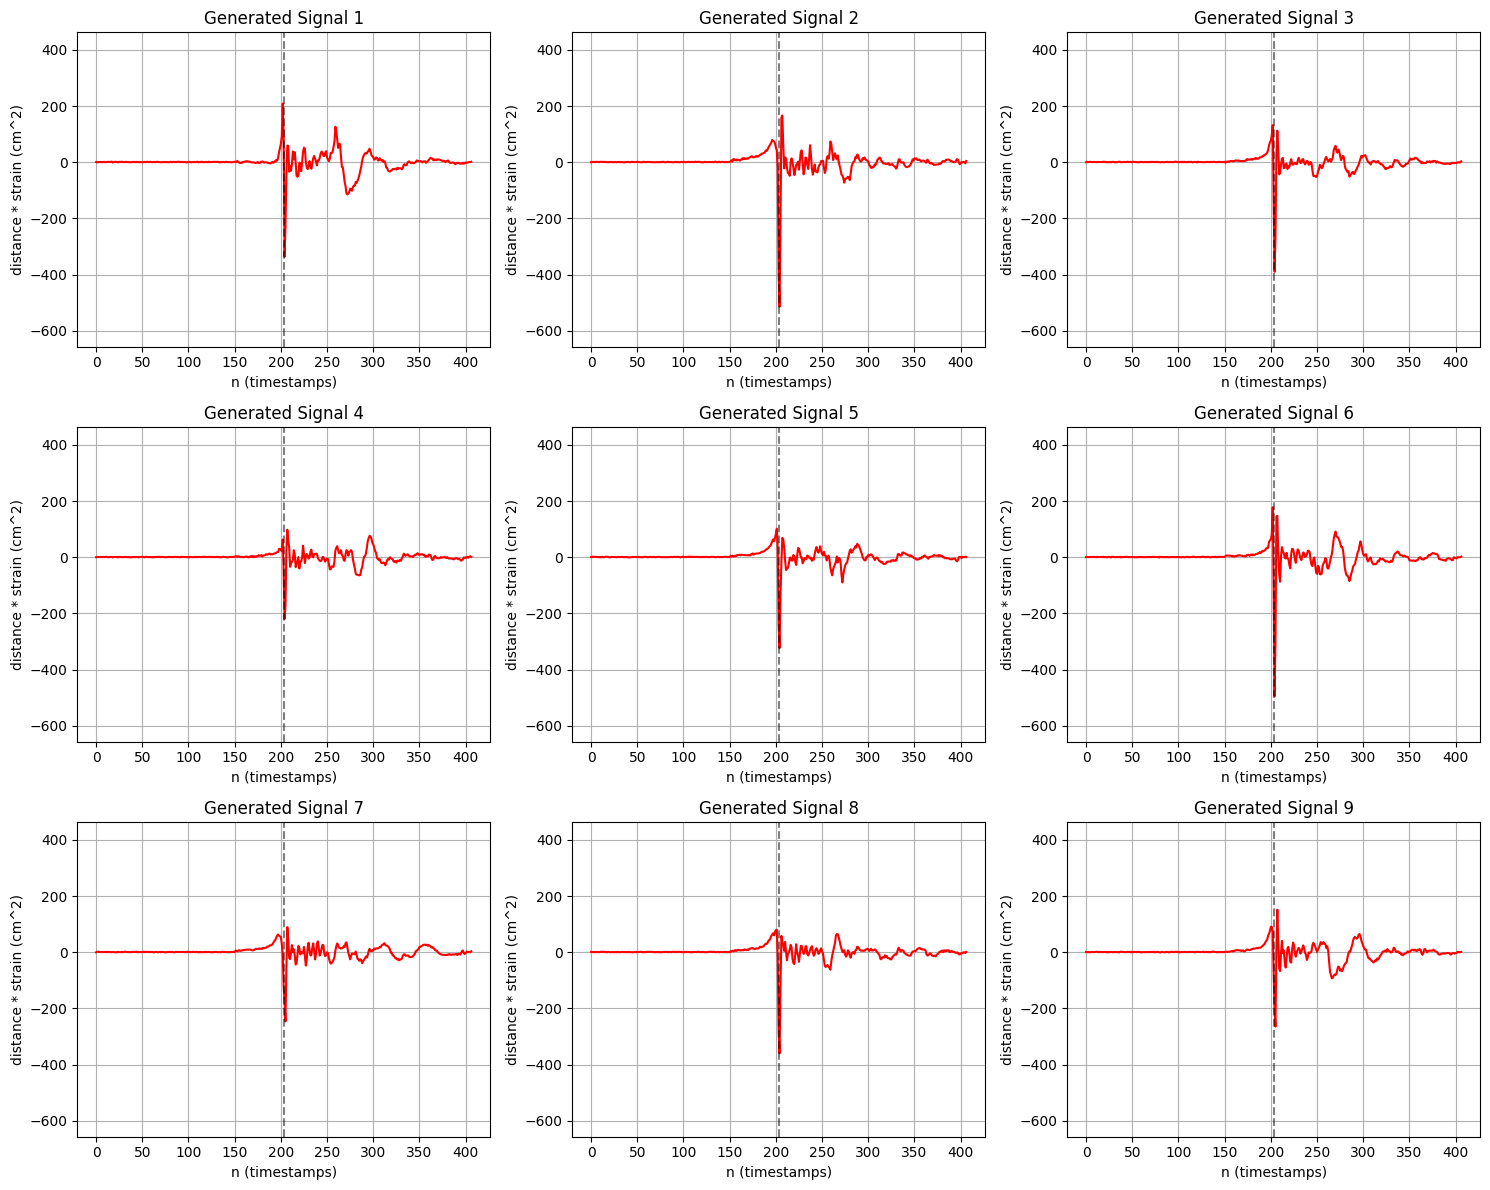

[29/32][0/188]	Loss_D: 0.4140	Loss_G: 2.4480	D(x): 0.9680	D(G(z)): 0.0987 / 0.1287
[29/32][50/188]	Loss_D: 0.5062	Loss_G: 2.4631	D(x): 0.9639	D(G(z)): 0.1900 / 0.1300
[29/32][100/188]	Loss_D: 0.4965	Loss_G: 2.0644	D(x): 0.9398	D(G(z)): 0.1634 / 0.1963
[29/32][150/188]	Loss_D: 0.6254	Loss_G: 1.6977	D(x): 0.9763	D(G(z)): 0.3252 / 0.2095
Epoch 29: SGD Discriminator lr 0.0000109 -> 0.0000106
Epoch 29: SGD Generator lr 0.0000109 -> 0.0000106


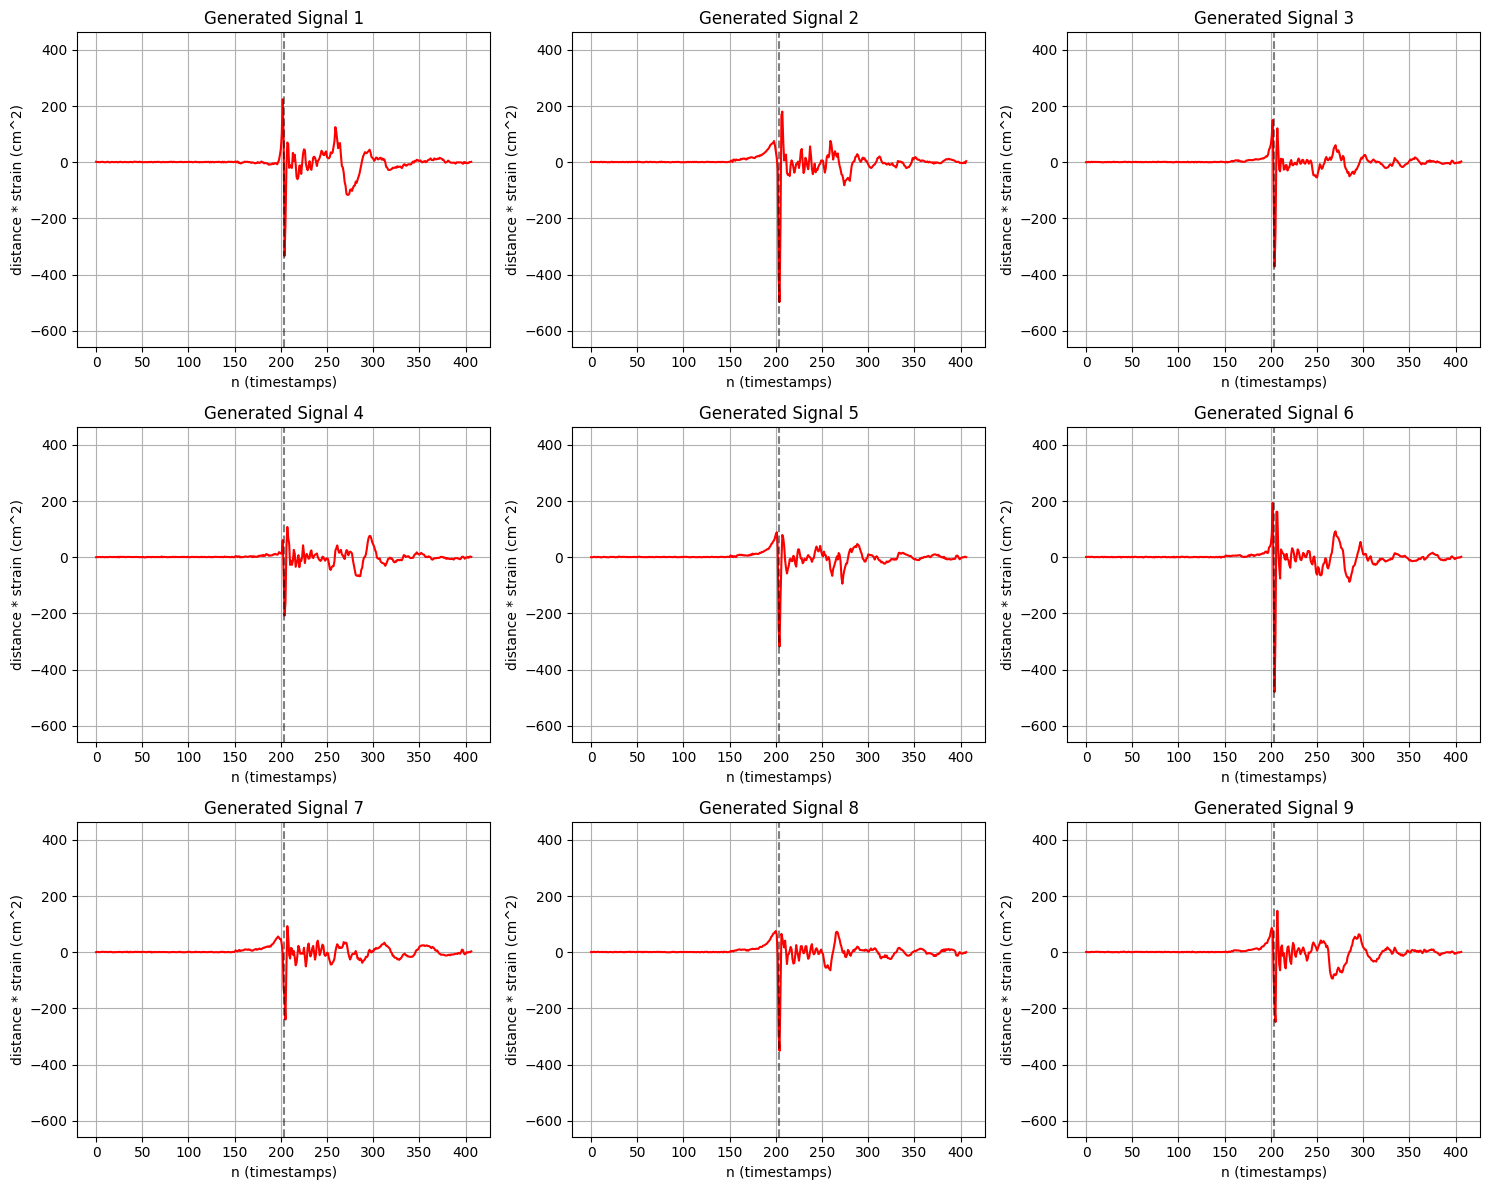

[30/32][0/188]	Loss_D: 0.5237	Loss_G: 1.8546	D(x): 0.9476	D(G(z)): 0.2013 / 0.2256
[30/32][50/188]	Loss_D: 0.4872	Loss_G: 1.8890	D(x): 0.9512	D(G(z)): 0.1632 / 0.1924
[30/32][100/188]	Loss_D: 0.3875	Loss_G: 2.3746	D(x): 0.9613	D(G(z)): 0.1370 / 0.1429
[30/32][150/188]	Loss_D: 0.4544	Loss_G: 2.1772	D(x): 0.9670	D(G(z)): 0.1955 / 0.1512
Epoch 30: SGD Discriminator lr 0.0000106 -> 0.0000103
Epoch 30: SGD Generator lr 0.0000106 -> 0.0000103


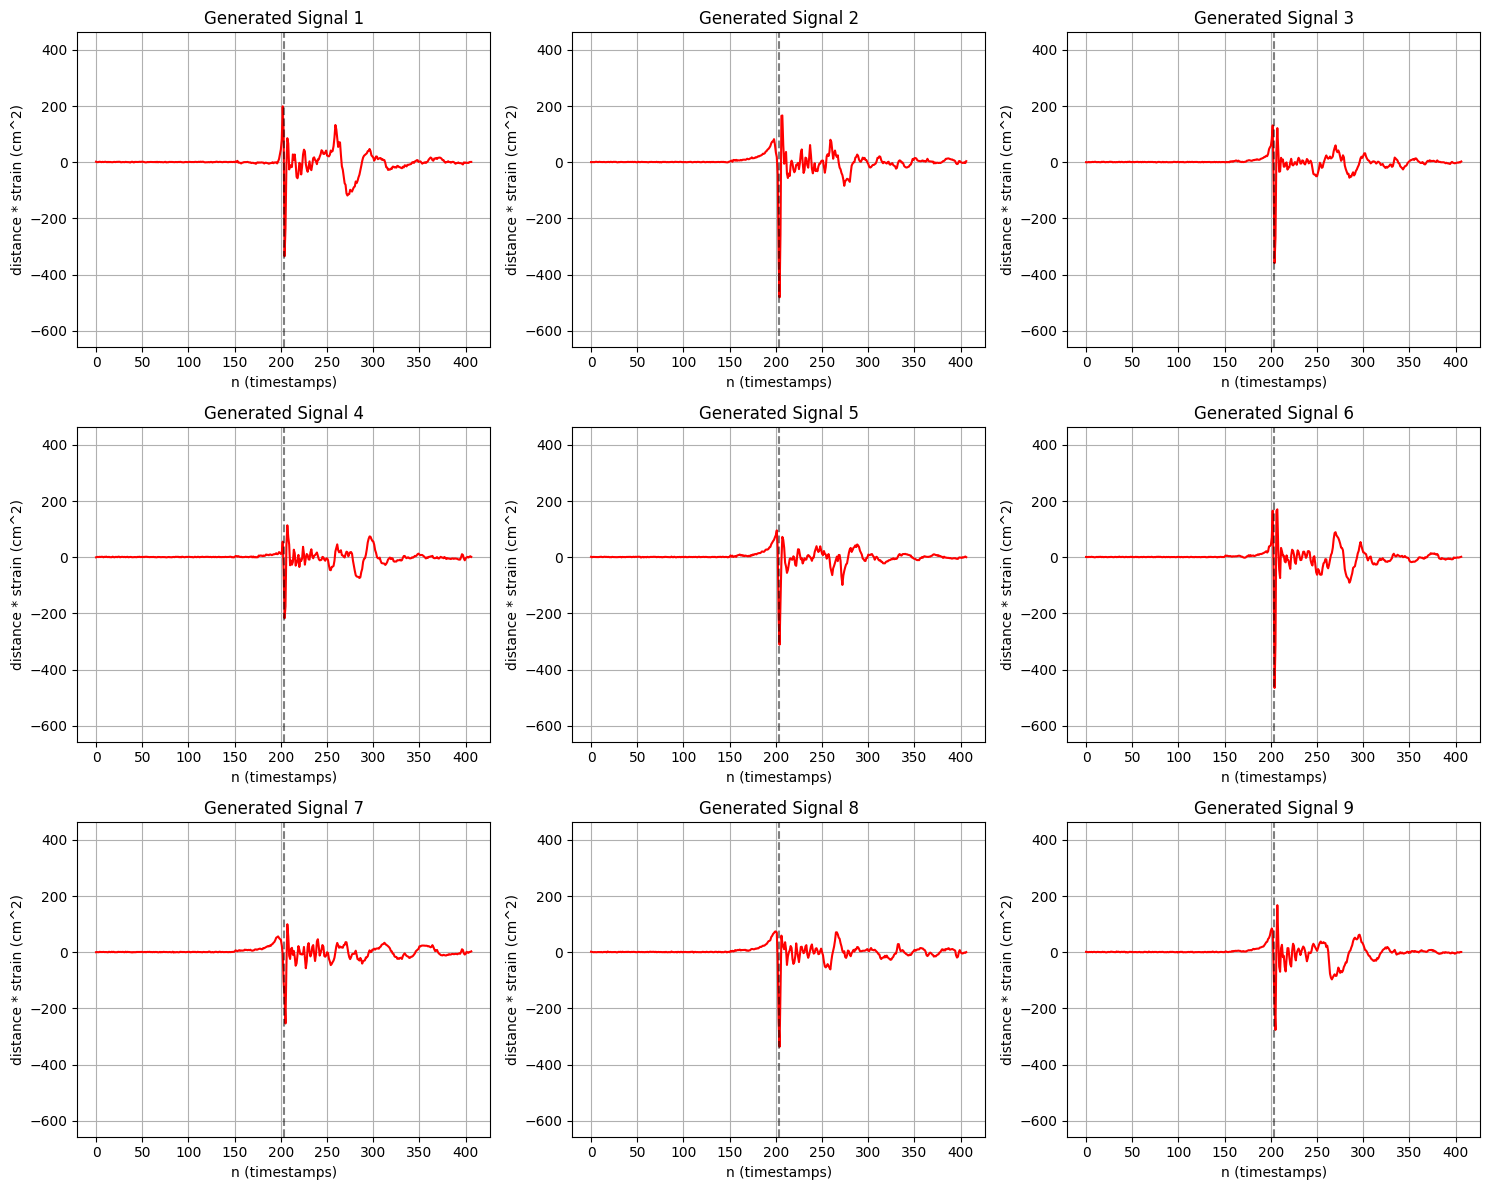

[31/32][0/188]	Loss_D: 0.5564	Loss_G: 1.3453	D(x): 0.9777	D(G(z)): 0.2959 / 0.3032
[31/32][50/188]	Loss_D: 0.4460	Loss_G: 2.5465	D(x): 0.9583	D(G(z)): 0.1322 / 0.0975
[31/32][100/188]	Loss_D: 0.3844	Loss_G: 2.5572	D(x): 0.9721	D(G(z)): 0.1403 / 0.1261
[31/32][150/188]	Loss_D: 0.5093	Loss_G: 1.9916	D(x): 0.9677	D(G(z)): 0.1508 / 0.1888
Epoch 31: SGD Discriminator lr 0.0000103 -> 0.0000100
Epoch 31: SGD Generator lr 0.0000103 -> 0.0000100


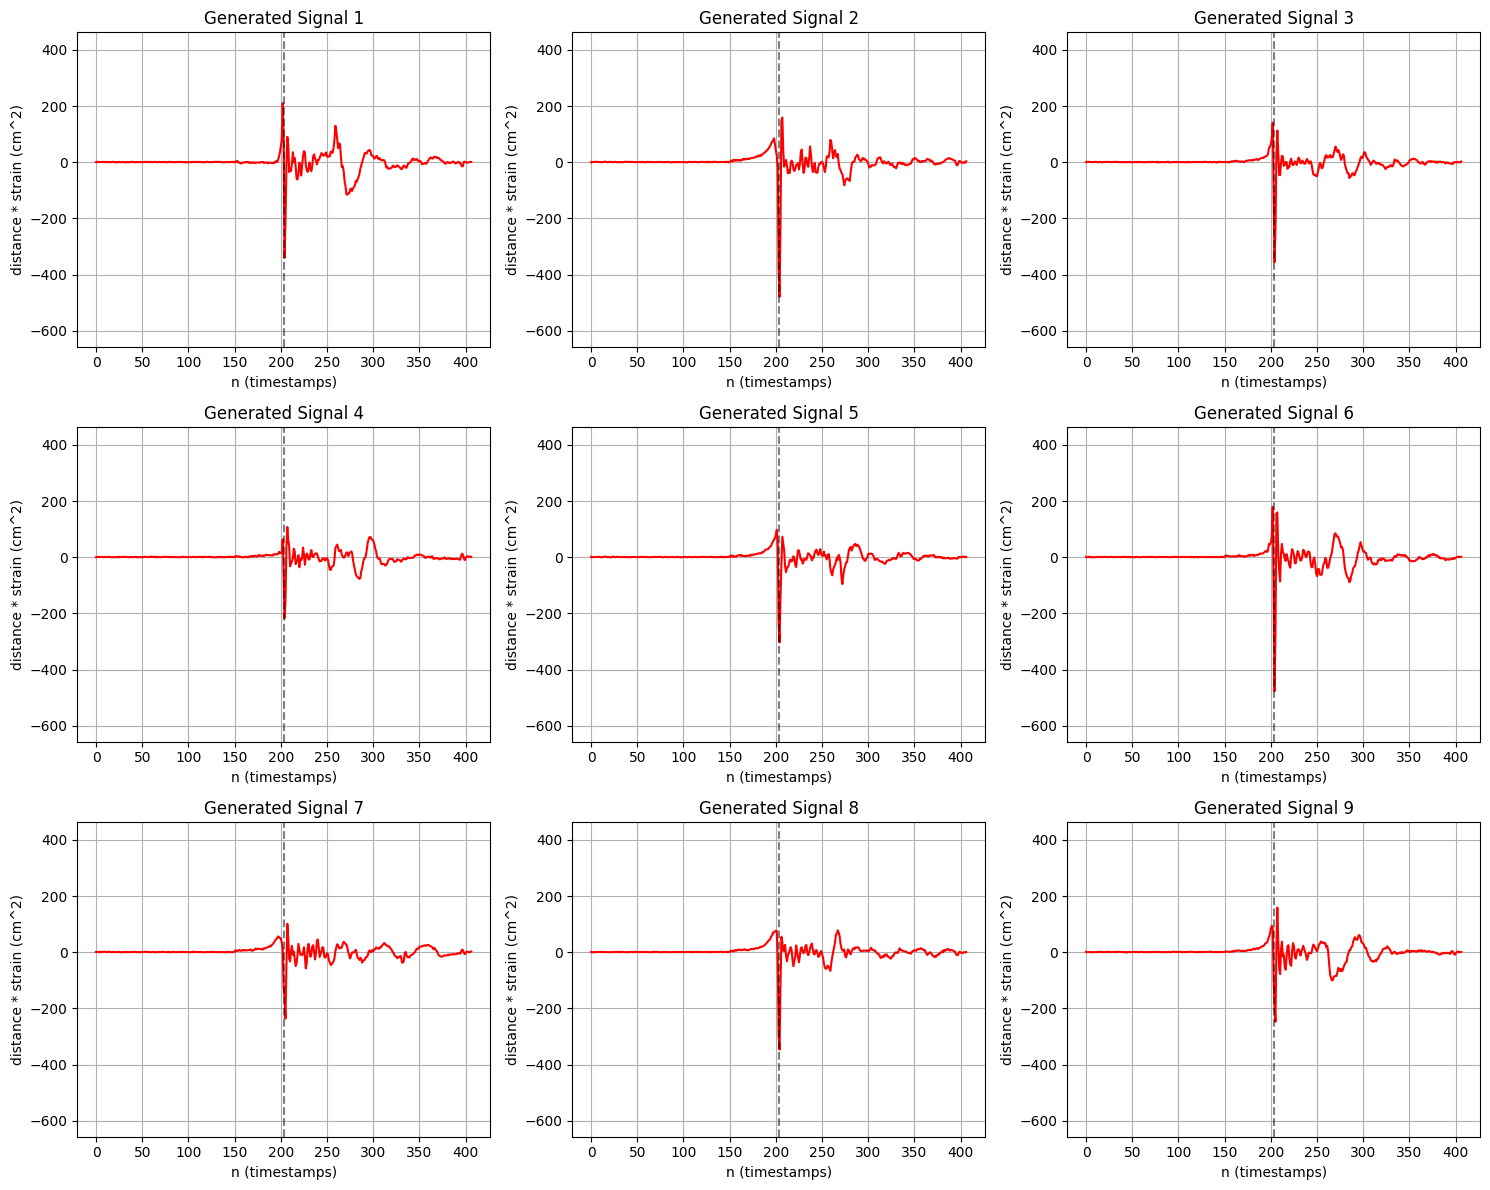

In [102]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

if (gans_type == 'dcgans' or gans_type == 'gans'):
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_gpu = data[0].to(device)
            real_parameters_gpu = data[1].to(device)
            b_size = real_gpu.size(0)
            label_real = torch.FloatTensor(b_size).uniform_(1.0, 1.0).to(device)
            # Forward pass real batch through D
            output = netD(real_gpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label_real)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, device=device)
            # Generate fake signal batch with G
            fake = netG(noise)
            label_fake = torch.FloatTensor(b_size).uniform_(0.0, 0.25).to(device)
            # label_fake = torch.FloatTensor(b_size).uniform_(0.0, 0.0).to(device)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label_fake)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
            # Calculate gradients of discriminator parameters
            D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label_real = torch.FloatTensor(b_size).uniform_(1.0, 1.0).to(device)
            # label_real = 1.0 - label_fake
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label_real)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            # Calculate gradients of generator parameters
            G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1 
        
        # learning-rate decay
        before_lr = optimizerD.param_groups[0]["lr"]
        schedulerD.step()
        after_lr = optimizerD.param_groups[0]["lr"]
        print("Epoch %d: SGD Discriminator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

        before_lr = optimizerG.param_groups[0]["lr"]
        schedulerG.step()
        after_lr = optimizerG.param_groups[0]["lr"]
        print("Epoch %d: SGD Generator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))
        
        with torch.no_grad():
            fake_signals = netG(fixed_noise).detach().cpu()
            fig, axes = plt.subplots(3, 3, figsize=(15, 12))

            axes = axes.flatten()

            # plot each signal on a separate subplot
            for i, ax in enumerate(axes):
                x = np.arange(407)
                y = fake_signals[i, :, :].flatten()
                y = y * dataset.scaling_factor
                y = y * dataset.std + dataset.mean
                background_noise_generated = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int(407-256))
                # background_noise_generated_1st_half = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int((407-256)/2))
                # background_noise_generated_2nd_half = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int((407-256)/2 + 1))
                y = np.concatenate((background_noise_generated, y))
                
                ax.plot(x, y, color = 'red')

                ax.axvline(x=203, color='black', linestyle='--', alpha=0.5)
                ax.set_title(f'Generated Signal {i + 1}')
                ax.grid(True)
                ax.set_ylim(ylim_signal)
                ax.set_ylabel('distance * strain (cm^2)')
                ax.set_xlabel('n (timestamps)')

            for i in range(407, 8*4):
                fig.delaxes(axes[i])

            plt.tight_layout()
            # plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_non_augment_%d.png' % (epoch + 1))
            plt.show()
        
        signal_list.append(fake_signals)

### Gradients

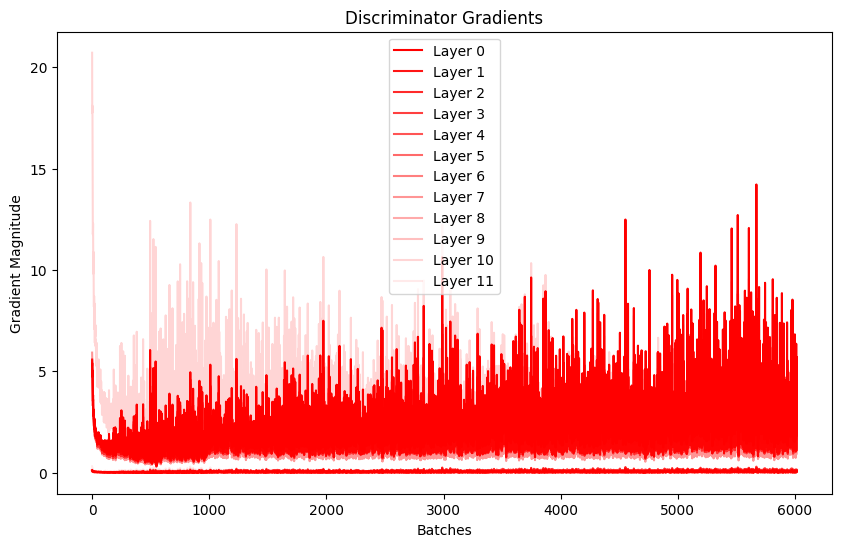

In [103]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Batches')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
# plt.savefig("../plots/architecture/gw_d_gradients_status_quo_32e.png")
plt.show()

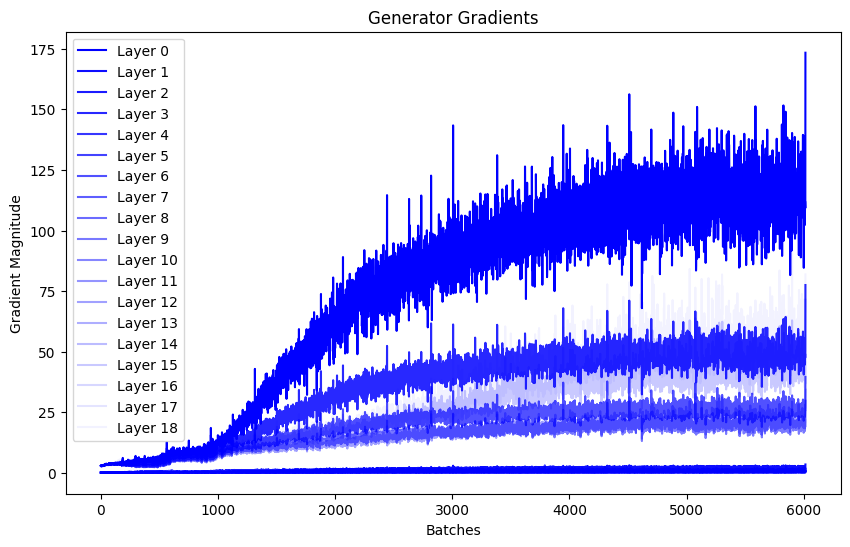

In [104]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Batches')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
# plt.savefig("../plots/architecture/gw_g_gradients_status_quo_32e.png")
plt.show()

### Loss

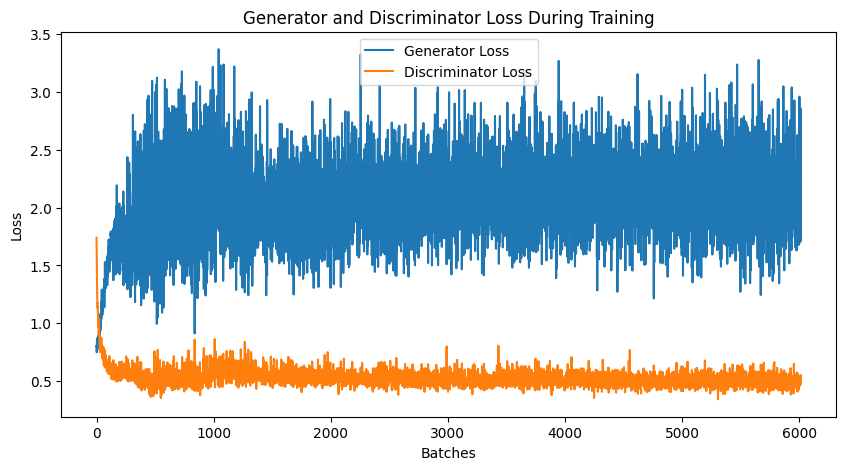

In [105]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator Loss")
plt.plot(D_losses,label="Discriminator Loss")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("../plots/architecture/gw_train_losses_final_32e.png")
plt.show()

### Generated Signals

In [1]:
batch = signal_list[31]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(407)
    y = batch[i, :, :].flatten()
    y = y * dataset.scaling_factor
    y = y * dataset.std + dataset.mean
    background_noise_generated = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int(407-256))
    # background_noise_generated_1st_half = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int((407-256)/2))
    # background_noise_generated_2nd_half = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int((407-256)/2 + 1))
    # y = np.concatenate((background_noise_generated_1st_half, y, background_noise_generated_2nd_half))
    # y = np.concatenate((background_noise_generated, y))
    ax.plot(x, y, color = 'red')

    ax.axvline(x=203, color='blue', linestyle='--', alpha=0.5)
    ax.set_title(f'Generated Signal {i + 1}')
    ax.grid(True)
    ax.set_ylim(ylim_signal)
    
    # Add axis titles
    ax.set_ylabel('distance * strain (cm^2)')
    ax.set_xlabel('n (timestamps)')

for i in range(407, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('../plots/architecture/gw_generated_signals_final_128e.png')
plt.show()

NameError: name 'signal_list' is not defined

### Save Generator

In [107]:
# torch.save(netG, "../models/stellar_core_collapse_signal_generator_dcgans.pt")